In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [19]:
# Build the model

class MyModel(Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = Dense(64, activation = 'relu')
        self.dense2 = Dense(10)
        self.dropout = Dropout(0.4)
        
    def call(self, inputs, training = True):
        x = self.dense1(inputs)
        if training:
            x = self.dropout(x)
        return self.dense2(x)
    

In [21]:
### Second Model ###

class MyModel(Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = Dense(64, activation = 'relu')
        self.dense2 = Dense(10)
        self.dense3 = Dense(5)
        self.softmax = Softmax()
        
    def call(self, inputs, training = True):
        x = self.dense1(inputs)
        y1 = self.dense2(inputs)
        y2 = self.dense3(y1)
        concat = concatenate([x, y2])
        return self.softmax(concat)

In [22]:
# Print the model summary

model = MyModel()
model(tf.random.uniform((1,10))) # Need to "build" the model by passing in an input.
model.summary()

Model: "my_model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             multiple                  704       
_________________________________________________________________
dense_11 (Dense)             multiple                  110       
_________________________________________________________________
dense_12 (Dense)             multiple                  55        
_________________________________________________________________
softmax (Softmax)            multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [26]:
# Create a custom layer

class MyLayer(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__() # Call the constructor of the base class. Parameters are passed in for backward
        # compatiability.
        
        ### This layer has 2 parameters, weights and bias ###
        
        ### For Weights, use the add_weights method, remember weights have to be initialized => can use tf's initialiser
        ### to initialize the weights. add_weights also need to specify the shape.
        
        self.w = self.add_weight(shape = (input_dim, units),
                                initializer = 'random_normal')
        
        self.b = self.add_weight(shape = (units,),
                                initializer = 'zeros')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b # .call() method specifies what to do with the layer when called.

In [44]:
dense_layer = MyLayer(3,5)

input_ = tf.ones((1,5))

output_ = mylayer(input_)

print(output_)
print()
print(dense_layer.weights)

tf.Tensor([[ 0.04916824 -0.0386636   0.18243596]], shape=(1, 3), dtype=float32)

[<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>, <tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[-0.02429316, -0.04974375, -0.02204271],
       [ 0.06036478, -0.0412969 ,  0.02492414],
       [ 0.01863968, -0.03908765,  0.00256075],
       [ 0.01024273,  0.02232684,  0.03105814],
       [ 0.03564503,  0.02371574, -0.01835054]], dtype=float32)>]


In [32]:
# Specify trainable weights

class MyLayer(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__() # Call the constructor of the base class. Parameters are passed in for backward
        # compatiability.
        
        ### This layer has 2 parameters, weights and bias ###
        
        ### For Weights, use the add_weights method, remember weights have to be initialized => can use tf's initialiser
        ### to initialize the weights. add_weights also need to specify the shape.
        
        self.w = self.add_weight(shape = (input_dim, units),
                                initializer = 'random_normal',
                                trainable = False)
        
        self.b = self.add_weight(shape = (units,),
                                initializer = 'zeros')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b # .call() method specifies what to do with the layer when called.

In [34]:
dense_layer = MyLayer(3, 5)

In [35]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 1
non-trainable weights: 1


In [50]:
# Create a custom layer to accumulate means of output values

# dense_layer = MyLayerMean(3,5) EXAMPLE
class MyLayerMean(Layer):
    # __init__(), call(), build()
    
    def __init__(self, units, input_dim): # Always write the constructor first for the custom layer, __init__(self)
        # Always got 'self'
        super(MyLayerMean, self).__init__() # Call the base class constructor
        
        self.w = self.add_weight(shape = (input_dim, units), # shape = (5, 3)
                                initializer = 'random_normal')
        
        self.b = self.add_weight(shape = (units,), # shape = (5,), an array with 5 elements
                                initializer = 'zeros')
        
        self.sum_activation = tf.Variable(initial_value = tf.zeros((units,)), # shape = (5,), an array with 5 elements
                                         trainable = False)
        
        self.number_call = tf.Variable(initial_value = 0, # just a number
                                      trainable = False)
        
    def call(self, inputs):
        activations = tf.matmul(inputs, self.w) + self.b # calculate the activations
        # inputs.shape e.g. = (4,5), self.w.shape = (5,3), activations.shape = (4,3)
        self.sum_activation.assign_add(tf.reduce_sum(activations, axis = 0))
        # assign to self.sum_activation by adding it
        # to tf.reduce_sum(activations, axis = 0), shape = (1,3)
        self.number_call.assign_add(inputs.shape[0]) # inputs.shape = (4,5), inputs.shape[0] = 4
        # because if input.shape[0] = 4, then reduce_sum will sum over 4 numbers, so number_call has to be
        # input.shape[0] to get the correct average.
        
        return activations, self.sum_activation / tf.cast(self.number_call, tf.float32)
    
dense_layer = MyLayerMean(3,5)

In [51]:
# Test the layer

y, activation_means = dense_layer(tf.ones((4, 5)))
print(activation_means.numpy())

[ 0.13818933  0.02231198 -0.13812529]


In [52]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate = self.rate)

#### Implement the custom layers into a model

In [55]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer1 = MyLayer(units_1, input_dim_1)
        self.dropout1 = MyDropout(0.5)
        self.layer2 = MyLayer(units_2, units_1)
        self.dropout2 = MyDropout(0.5)
        self.layer3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
        
    def call(self, inputs):
        # Define forward pass
        
        x = self.layer1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.dropout2(x)
        x = self.layer3(x)

        return self.softmax(x)

In [56]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

Model: "my_model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_8 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout_2 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_9 (MyLayer)         multiple                  4160      
_________________________________________________________________
my_dropout_3 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_10 (MyLayer)        multiple                  2990      
Total params: 647,214
Trainable params: 174
Non-trainable params: 647,040
_________________________________________________________________


***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [57]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

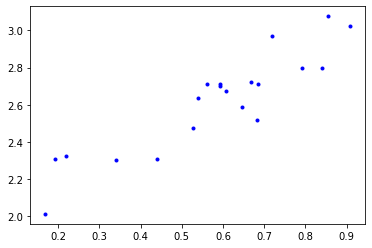

In [58]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [ ]:
from tensorflow.keras.layers import Layer

In [59]:
# Build a custom layer for the linear regression model

class LinearLayer(Layer):
    
    # Constructor should be defining the attributes of the layer, mostly the weights
    def __init__(self):
        super(LinearLayer, self).__init__()
        self.m = self.add_weight(shape = (1,),
                                initializer = 'random_normal')
        
        self.b = self.add_weight(shape = (1,),
                                initializer ='zeros')
    
    # call method will be instructions on what to do with the inputs and the layer's attributes.
    # inputs parameter is a MUST
    def call(self, inputs): # For this linear regressor, it is about finding the equation of the line.
        # y = mx + b
        return self.m * inputs + self.b

In [61]:
linear_regression = LinearLayer()

#### Define the loss function

In [62]:
# Define the mean squared error loss function

# To do differentiation of the loss function wrt to the trainable_variables, need to define a loss function first.
def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.8652406


#### Train and plot the model

In [66]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 0.05
steps = 25

for i in range(steps):
    
    ## It is tf.GradientTape(), it is a method.
    with tf.GradientTape() as tape:
        ## Get the predictions by passing x_train into the LR layer
        predictions = linear_regression(x_train)
        ## Calculate the loss
        loss = SquaredError(predictions, y_train)
    
    ## Calculate the gradient of the loss wrt to trainable_variables: m, b
    ## tape.gradient(y, x) = dy/dx
    gradients = tape.gradient(loss, linear_regression.trainable_variables)
    
    ## VARIABLE.assign_sub(ARGUMENT) => take VARIABLE, minus the ARGUMENT, take the result and assign to VARIABLE
    ## equivalent to VARIABLE = VARIABLE - ARGUMENT
    linear_regression.m.assign_sub(learning_rate * gradients[0])
    linear_regression.b.assign_sub(learning_rate * gradients[1])
    
    print(f"Steps {i}, Loss {loss.numpy()}")

Steps 0, Loss 0.017302842810750008
Steps 1, Loss 0.016055626794695854
Steps 2, Loss 0.015121527016162872
Steps 3, Loss 0.014421908184885979
Steps 4, Loss 0.013897891156375408
Steps 5, Loss 0.013505366630852222
Steps 6, Loss 0.01321131270378828
Steps 7, Loss 0.01299100648611784
Steps 8, Loss 0.012825919315218925
Steps 9, Loss 0.012702198699116707
Steps 10, Loss 0.012609432451426983
Steps 11, Loss 0.012539875693619251
Steps 12, Loss 0.012487662024796009
Steps 13, Loss 0.012448477558791637
Steps 14, Loss 0.01241903193295002
Steps 15, Loss 0.012396865524351597
Steps 16, Loss 0.012380183674395084
Steps 17, Loss 0.012367583811283112
Steps 18, Loss 0.0123580452054739
Steps 19, Loss 0.012350811623036861
Steps 20, Loss 0.012345291674137115
Steps 21, Loss 0.012341070920228958
Steps 22, Loss 0.012337803840637207
Steps 23, Loss 0.012335263192653656
Steps 24, Loss 0.012333272024989128


m:1,  trained m:[1.1435552]
b:2,  trained b:[1.8858697]


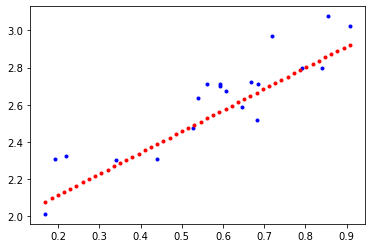

In [65]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

# >>> MOST IMPORTANT CELL IN THIS TUTORIAL <<<

In [32]:
# Define the custom layers and model

class MyLayer(Layer):
    
    def __init__(self, units):
        super(MyLayer, self).__init__()
        self.units = units # once define build(), have to change units to self.units
        # this is so that build() can use the attribute of the class instead of passing units into build
        # each time it is called.
        
    def build(self, input_shape): # once define build, can put dynamic input_shape
        
        self.w = self.add_weight(shape = (input_shape[-1], self.units),
                                initializer = 'random_normal',
                                name = 'kernel')
        
        self.b = self.add_weight(shape = (self.units,),
                                initializer = 'zeros')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate = self.rate)
    
class MyModel(Model):

    def __init__(self, units_1, units_2, units_3): # input_dim_1 is removed because now the input_shape
        # is dynamic
        super(MyModel, self).__init__()
        # Define layers
        self.layer1 = MyLayer(units_1) # MyLayer now only needs units as its only parameter
        self.dropout1 = MyDropout(0.5)
        self.layer2 = MyLayer(units_2)
        self.dropout2 = MyDropout(0.5)
        self.layer3 = MyLayer(units_3)
        self.softmax = Softmax()
        
    def call(self, inputs):
        # Define forward pass
        
        x = self.layer1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.dropout2(x)
        x = self.layer3(x)

        return self.softmax(x)

In [33]:
# Instantiate a model object

model = MyModel(64,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.02666681 0.00838856 0.00283081 0.00082394 0.00402917 0.00280319
  0.01892587 0.00570636 0.01199498 0.02062701 0.01366464 0.00836125
  0.00301557 0.11676556 0.01397085 0.02214128 0.0041015  0.02448681
  0.01004637 0.00884751 0.01191228 0.05015008 0.0051617  0.01250832
  0.02457879 0.01807708 0.24945162 0.00539131 0.01612431 0.00870814
  0.03619837 0.0391323  0.0068039  0.0217827  0.01095592 0.00462532
  0.00499805 0.00670671 0.00120674 0.00619659 0.02086482 0.04143979
  0.00964712 0.03044024 0.00572367 0.02301624]], shape=(1, 46), dtype=float32)
Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_3 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout_2 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_4 (MyLaye

#### Load the reuters dataset and define the class_names 

In [6]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

C:\Users\jymch\anaconda3\lib\site-packages\tensorflow_core\python\keras\datasets\reuters.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\jymch\anaconda3\lib\site-packages\tensorflow_core\python\keras\datasets\reuters.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [7]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [8]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

In [9]:
# Print the first data example sentence

print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [16]:
import numpy as np
import time

In [26]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print(x_train)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)
[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]


#### Define the loss function and optimizer



In [50]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    print("y_ is", y_)
    print("y is", y)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [51]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [52]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

# Keep results for plotting
train_loss_results, train_accuracy_results = [], []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs): # Start the training
    
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    # Training loop
    
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model,x,y,weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Compute current loss
        epoch_loss_avg(loss_value)
        # Compare predicted label to actual label
        epoch_accuracy(to_categorical(y), model(x))
        
    # End of epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    print(f"Epoch: {epoch}, Loss: {epoch_loss_avg.result()}, Accuracy: {epoch_accuracy.result()}")
    
    
print("Duration :{:.3f}".format(time.time() - start_time))

y_ is tf.Tensor(
[[1.9354352e-03 7.2612636e-02 7.7326028e-03 ... 1.5866172e-03
  1.8783658e-03 2.0826471e-03]
 [2.4766938e-03 9.2527876e-03 1.0420854e-03 ... 1.1296432e-03
  1.2562495e-03 1.6572882e-03]
 [1.2931650e-07 1.1620963e-04 2.3323446e-06 ... 1.3665705e-06
  1.8241778e-06 8.0204251e-07]
 ...
 [7.1718248e-05 2.1567525e-04 1.0651416e-02 ... 3.1486049e-04
  2.0664935e-04 2.8389855e-04]
 [5.0904293e-02 2.2957586e-01 3.4809742e-02 ... 5.2536353e-03
  5.2732467e-03 8.5731698e-03]
 [1.7526341e-05 3.5722417e-04 2.9963128e-05 ... 6.1414626e-06
  1.5531847e-05 1.9426794e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4  3  4  4  4  4  3  3 16  3  3  4  4 19  8 16  3  3 21 11  4  4  3
  3  1  3  1  3 16  1  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[6.8907277e-03 8.7299699e-01 8.8764150e-03 ... 4.3881300e-05
  1.0240805e-04 7.3139439e-05]
 [3.6431933e-04 2.7020904e-04 1.2232263e-05 ... 1.2446354e-04
  1.2724618e-04 1.7039278e-04]
 [4.4405158e-03 7.6814961e-01 8.3846292e-0

y is tf.Tensor(
[ 4 34  9 21  3 10  3  3  4  3 11 20  3  4  3 13 31 16  4  3 12  4  4  4
  3  4  3  3  3  3 11 34], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.47783168e-04 4.29684520e-02 1.18441798e-03 ... 2.41698799e-04
  2.60663655e-04 2.49005156e-04]
 [1.71571060e-06 1.08056884e-05 2.92680743e-05 ... 2.92602326e-05
  1.27998292e-05 1.26635987e-05]
 [4.57982242e-04 3.76123451e-02 1.16286788e-03 ... 5.11884864e-04
  5.40305686e-04 6.62231527e-04]
 ...
 [2.68685501e-02 3.29713225e-01 5.11093885e-02 ... 5.81578398e-03
  4.65481682e-03 6.32480858e-03]
 [2.12270278e-03 2.84598500e-04 5.59289365e-05 ... 5.10842248e-04
  3.69597401e-04 4.28762141e-04]
 [6.84615661e-05 1.58819443e-04 3.01925326e-03 ... 1.29829408e-04
  1.13100534e-04 1.79235489e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  3 20  1  3 40  3 25 39  3  1  3  4  8  3 13  3  0  3 19  3  3  3
  3  3  4  4 19  1 19 16], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.2494124e-06 5.3923071e-05 9.1377906e-06 ... 9.

y_ is tf.Tensor(
[[7.8811609e-05 2.3767608e-03 6.0957571e-04 ... 2.7482756e-04
  1.5929570e-04 1.9271602e-04]
 [9.2348301e-08 2.9305917e-05 3.3479212e-06 ... 9.1743885e-07
  7.0203822e-07 6.8534069e-07]
 [1.1233080e-03 5.4588504e-03 1.2220489e-02 ... 1.0004232e-03
  5.8698247e-04 5.2200304e-04]
 ...
 [6.1933332e-07 5.8165399e-05 5.2604291e-06 ... 3.8819430e-06
  3.7045925e-06 4.1511516e-06]
 [1.1004650e-03 8.2803935e-02 2.6225287e-03 ... 1.2197078e-03
  1.0769583e-03 1.0030508e-03]
 [8.1017753e-04 8.6453268e-03 1.4612556e-03 ... 4.8226636e-04
  4.8425246e-04 8.3330093e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3 11 11  4 18  4 21 11  4  4  3  4  3  4  0  3  3 36  4 13  3  4 16
 11 15  1  1 10  3  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.17459979e-06 6.82039463e-05 6.00625572e-06 ... 1.89631282e-06
  2.15673276e-06 2.67579617e-06]
 [6.44015090e-04 1.33059695e-02 1.84160157e-03 ... 1.08383351e-03
  7.77483394e-04 7.56574911e-04]
 [1.48795312e-04 6.84390543e-0

y_ is tf.Tensor(
[[4.62658610e-03 1.59095660e-01 3.69101502e-02 ... 1.82157115e-03
  1.56016741e-03 1.57798617e-03]
 [4.74033674e-04 9.13499575e-03 6.55869069e-03 ... 1.28057541e-03
  7.78994116e-04 1.01348036e-03]
 [4.09130789e-02 9.20892879e-02 2.69823056e-02 ... 1.03683695e-02
  5.94283640e-03 7.79013149e-03]
 ...
 [1.96092785e-03 8.95300414e-03 3.85801628e-04 ... 1.08740362e-03
  9.09636554e-04 7.75950029e-04]
 [7.76107845e-06 4.45187208e-04 3.40563784e-05 ... 4.35112543e-06
  6.23410824e-06 1.14883460e-05]
 [8.16560118e-04 2.10092124e-02 7.57038128e-03 ... 1.24615547e-03
  9.62622522e-04 1.17436773e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[11 21 11  3  3  4  3  4  3  4  4  4  3  3 13  4  3  4 19 17  4  3  3 11
 28  4 28  4  3 19  4  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.7643944e-03 1.4755343e-01 1.0295832e-02 ... 4.9658003e-03
  3.3642827e-03 3.0308056e-03]
 [5.6332676e-05 8.9437691e-03 4.6643987e-04 ... 1.1506187e-04
  9.7185082e-05 1.0684183e-04]
 [1.13

y_ is tf.Tensor(
[[5.4745242e-04 1.4032817e-03 1.0220308e-04 ... 1.6935292e-04
  1.5716466e-04 2.5395938e-04]
 [1.5927737e-05 1.2436986e-03 3.0931030e-04 ... 5.6816829e-05
  4.5794495e-05 4.8235728e-05]
 [2.0027614e-05 8.8592077e-04 2.3001310e-05 ... 5.2924435e-05
  4.4141354e-05 4.9940161e-05]
 ...
 [5.7802867e-05 1.0973781e-03 2.7998450e-04 ... 1.3981873e-04
  1.2992963e-04 1.9115492e-04]
 [1.4532266e-02 2.6862505e-03 3.3333064e-03 ... 5.8672656e-03
  3.7212183e-03 9.7038038e-03]
 [1.9694133e-07 4.5186316e-04 3.9388062e-05 ... 1.5256395e-06
  1.5850486e-06 1.7531407e-06]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  3  3 19  3  3  4  3 11  4 18  1  1  3 30  3  4 11 13 20  3  3  1 19
  4  4  1 19 11  3  4  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[5.1481795e-04 1.3079277e-03 9.1181799e-05 ... 1.5288088e-04
  1.3710925e-04 1.1473773e-04]
 [2.7274599e-04 1.5350818e-04 1.5660410e-03 ... 3.7515903e-04
  3.1063700e-04 6.3220185e-04]
 [3.0308706e-07 2.1464450e-04 1.2187072e-0

y_ is tf.Tensor(
[[2.8409870e-04 2.9535294e-03 2.8101093e-04 ... 3.5416437e-04
  2.8136314e-04 3.6939935e-04]
 [1.5961374e-03 4.2519830e-03 9.3505048e-04 ... 7.4452418e-04
  6.4676406e-04 6.7440106e-04]
 [7.7530720e-05 1.6366379e-02 2.2662325e-04 ... 1.4757474e-04
  1.4159868e-04 1.3269731e-04]
 ...
 [6.0610750e-05 3.6385588e-02 3.4473236e-05 ... 5.0622191e-05
  5.0059625e-05 3.2598815e-05]
 [1.0743507e-05 2.9414592e-04 3.2553908e-05 ... 6.4125961e-05
  4.0004245e-05 3.5408684e-05]
 [1.0281533e-05 1.7024213e-04 3.2025200e-06 ... 2.5752513e-06
  3.2500561e-06 4.7443878e-06]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4 20  3  8  3  9  3 11  3  9  3 21 18 20 25 16  2 26  4  3  3  4  3  8
  3 20  4  3  3 19  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.0667001e-05 8.5479729e-03 5.5538145e-05 ... 4.5007739e-05
  4.9378985e-05 5.7731697e-05]
 [5.2456115e-03 8.4159538e-02 1.9651067e-02 ... 1.9065674e-03
  1.5825782e-03 1.4722917e-03]
 [3.8798435e-03 1.7810715e-02 1.0653745e-0

y_ is tf.Tensor(
[[2.38276552e-05 3.83317965e-04 1.46008591e-04 ... 8.70835793e-05
  6.00017411e-05 8.13594597e-05]
 [1.21682613e-04 3.07225715e-03 5.28064149e-04 ... 3.48142639e-04
  2.30951351e-04 2.01315095e-04]
 [2.45426856e-02 6.65413663e-02 2.21662018e-02 ... 1.20244585e-02
  7.94858392e-03 1.11158816e-02]
 ...
 [3.49715879e-06 2.38303866e-04 2.29990710e-05 ... 1.50795622e-05
  1.54370773e-05 1.25370716e-05]
 [1.23348742e-04 6.56996965e-02 1.00767834e-03 ... 1.93451895e-04
  1.82815056e-04 1.51933520e-04]
 [6.92232624e-02 3.91304083e-02 1.54998284e-02 ... 1.23216547e-02
  6.53619738e-03 1.10082012e-02]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3 27 12 11 39  8  1 20 19  4  3  1  4  1  9 25  3 20 43  3  4  4  3
  3  3 21 20  3  4  3  9], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.4231535e-03 1.6408235e-02 4.7254428e-02 ... 9.6361252e-04
  9.7497960e-04 1.3150173e-03]
 [1.0033826e-03 1.4736685e-03 6.8104896e-04 ... 1.0415862e-03
  8.2185765e-04 1.1429308e-03]
 [6.10

y_ is tf.Tensor(
[[8.9610822e-04 2.8832013e-02 2.5703979e-03 ... 1.2248879e-03
  1.0837162e-03 9.9834229e-04]
 [2.9506475e-05 1.4096152e-03 9.8782351e-05 ... 5.7474354e-05
  5.5415207e-05 4.5780918e-05]
 [1.4097681e-02 1.3596566e-02 5.4341275e-03 ... 9.3078073e-03
  5.7848939e-03 8.3638951e-03]
 ...
 [6.8016653e-03 7.9001859e-02 1.3288147e-02 ... 3.7951698e-03
  3.7740392e-03 4.8181447e-03]
 [2.7909036e-05 5.0987484e-04 3.5379958e-04 ... 1.3000146e-04
  7.8669153e-05 8.2967264e-05]
 [3.0961659e-02 2.5507063e-01 3.3308122e-02 ... 6.1884602e-03
  5.7449071e-03 8.2035651e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  8  3 11  3 16  4  3 19 11  4  3 16  3  4  4  4  3  3  3  4  8  3
  3  3  4 11  3  3  3  1], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.0565750e-02 1.3700687e-02 2.8014414e-03 ... 8.8997977e-03
  4.1137855e-03 4.8207580e-03]
 [8.7935014e-06 6.3940085e-04 1.0755519e-04 ... 4.3486576e-05
  3.4862460e-05 2.4756126e-05]
 [1.3298883e-04 1.9953719e-03 2.9073164e-0

y_ is tf.Tensor(
[[1.48526682e-02 4.09167022e-01 5.16648665e-02 ... 4.22449550e-03
  4.67261299e-03 5.71727101e-03]
 [6.88129876e-06 1.54647350e-04 2.02725437e-06 ... 8.97281211e-07
  2.20734660e-06 2.74103422e-06]
 [3.60787749e-06 6.66864740e-04 4.42158344e-05 ... 1.84464279e-05
  1.21267558e-05 1.02419581e-05]
 ...
 [2.44837045e-03 9.32583865e-03 3.34978593e-03 ... 1.25673343e-03
  1.47553300e-03 1.87030912e-03]
 [1.26300035e-02 6.27291381e-01 1.52431289e-02 ... 1.30587770e-03
  1.52966089e-03 1.86797895e-03]
 [2.05200195e-07 1.18793168e-05 2.81604457e-06 ... 1.81195389e-06
  1.46033040e-06 1.24905227e-06]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 1  4  3  3  3  3  6  4  4  4 11 19  5  3  4  3  4  4 40  4 21  3 11  3
  4  4  3  4  4  4  1  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.13231202e-07 1.68623024e-04 1.52001885e-05 ... 1.93902952e-06
  3.63813660e-06 2.98128066e-06]
 [3.58395366e-04 2.92051653e-03 4.98157926e-04 ... 1.47163664e-04
  1.83418379e-04 2.23912764

y is tf.Tensor(
[11 17 10  3  3  3 34  4  1  4  4  3  3 37 20  3  3  3  3  4 16  3  4  3
  4  4 16 16  3  3  3 11], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.6158432e-02 5.2578454e-03 1.5431266e-02 ... 1.6828209e-02
  7.3415427e-03 1.2206287e-02]
 [1.3816237e-03 9.3902133e-02 9.1675110e-03 ... 1.4398984e-03
  1.2324692e-03 1.2388091e-03]
 [1.9131952e-04 1.0309140e-03 1.7316353e-04 ... 3.3634846e-05
  5.6009259e-05 6.6880602e-05]
 ...
 [4.8780744e-03 5.3396024e-04 1.2256017e-02 ... 2.3653330e-03
  1.5836863e-03 2.4514408e-03]
 [2.4021709e-02 3.0072433e-01 3.0840294e-02 ... 5.9187361e-03
  4.7905180e-03 5.5018053e-03]
 [6.8782124e-04 4.4959778e-04 1.6294654e-03 ... 8.2556729e-04
  2.6032983e-04 3.2142625e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[18  3  4 16  3 19  1 19  8  6  4  4 19  5  3  4 31  4 19 20  3  4 19  4
  3  3  4  4  3 13 36 11], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.92230659e-04 4.34499467e-03 2.02995652e-04 ... 5.03412084e-05
  9.95641531e-05 9.9

y_ is tf.Tensor(
[[1.16702332e-03 3.53725191e-04 6.94369373e-05 ... 1.12034346e-03
  4.52397915e-04 5.35799831e-04]
 [8.30237477e-05 3.04081081e-03 7.52097054e-04 ... 1.76177462e-04
  1.25572478e-04 1.42564328e-04]
 [4.88553802e-03 3.38541418e-01 5.25886565e-02 ... 2.70177843e-03
  2.85374233e-03 2.93338788e-03]
 ...
 [1.48570712e-03 2.30943002e-02 9.80055309e-04 ... 6.73571834e-04
  9.61056736e-04 1.05206727e-03]
 [3.59633523e-05 4.76850459e-04 2.01880379e-04 ... 1.13390095e-04
  8.45352115e-05 8.42835725e-05]
 [6.32995786e-03 1.41922652e-03 4.14692983e-03 ... 9.91404988e-03
  3.00382916e-03 5.11078211e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[20  3 24  3  3 16 20 19  3  4  3  2 21 39  4  3  3  3  3  3 11  7 16 20
 10 16  3  1 19  3  3 21], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[6.0418043e-03 2.2130674e-02 1.9131375e-03 ... 4.5313877e-03
  2.8620060e-03 3.4027393e-03]
 [4.6098580e-06 7.0260408e-05 1.3504942e-05 ... 1.3746818e-05
  1.3264513e-05 1.3396549e-05]
 [2.42

y_ is tf.Tensor(
[[1.38207129e-03 4.62883152e-03 2.58757209e-04 ... 1.11790467e-03
  8.71071417e-04 9.25812114e-04]
 [8.04916708e-05 1.34059181e-03 3.55984317e-04 ... 1.51833272e-04
  1.29482796e-04 1.27642983e-04]
 [6.99948519e-04 3.37718031e-03 2.54642044e-04 ... 2.19061127e-04
  2.67636351e-04 3.43796593e-04]
 ...
 [2.68285250e-04 1.62191584e-03 3.90101341e-04 ... 4.69831197e-04
  3.04828311e-04 3.19448503e-04]
 [1.39174645e-05 5.85731771e-03 1.40293836e-04 ... 2.01586899e-05
  2.39174024e-05 1.65430101e-05]
 [5.94634112e-05 9.56405711e-05 1.83495613e-05 ... 6.49876310e-05
  7.35405483e-05 5.98607876e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[20  3  4 11  4  3 10  3  4  0  3  8  3 19  3  4  3  3  3  3  4  3 11  1
  4  3 11 11 13  3  3 20], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.55660221e-05 6.47021504e-03 3.15017649e-04 ... 9.34870623e-05
  8.96505735e-05 8.15556341e-05]
 [8.78309924e-03 6.71508670e-01 6.16111606e-03 ... 5.89391915e-04
  1.06768555e-03 1.16115774

y_ is tf.Tensor(
[[4.5785792e-02 5.4097444e-02 2.0442404e-02 ... 8.2632350e-03
  6.9443141e-03 1.0311305e-02]
 [2.8373001e-04 1.3597388e-03 2.8656507e-04 ... 8.8165246e-04
  3.6350288e-04 3.2045017e-04]
 [1.5550668e-04 3.3802661e-04 4.6060613e-04 ... 4.7485519e-04
  2.7131429e-04 2.7308130e-04]
 ...
 [1.0460751e-05 4.6338851e-04 4.0391937e-05 ... 2.6072030e-05
  2.3133018e-05 2.1926247e-05]
 [2.6338280e-04 1.5251352e-04 9.8355964e-04 ... 1.3641256e-04
  1.8425437e-04 2.5451463e-04]
 [7.8985660e-04 1.4291459e-02 1.5130748e-04 ... 2.4198888e-04
  3.7302318e-04 3.8529502e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 0 21  3  3 10  8  3 19  9  4  3  3  8 21  1  1  0 19  3 13  3  4  3 17
 19  4  9  4  3  3 16  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.9653751e-03 5.0162524e-01 9.3472479e-03 ... 1.2795090e-03
  1.2173983e-03 9.5229916e-04]
 [4.4606757e-05 1.0582784e-03 2.0412756e-04 ... 1.1448269e-04
  9.3847957e-05 9.3487070e-05]
 [2.1604990e-05 1.6397727e-03 1.7608272e-0

y_ is tf.Tensor(
[[5.6051740e-05 1.2997974e-04 1.0070721e-04 ... 3.4815366e-05
  4.5561093e-05 5.6746379e-05]
 [4.9663079e-03 1.1580338e-02 3.4963671e-04 ... 1.0749669e-03
  8.3921058e-04 8.1686681e-04]
 [1.3511597e-04 7.1671051e-03 5.7375455e-05 ... 1.4310573e-04
  1.3299227e-04 1.0811370e-04]
 ...
 [5.5539497e-04 1.8738996e-02 2.6180167e-03 ... 6.7689357e-04
  5.7484035e-04 6.0897967e-04]
 [1.4376891e-03 1.1459525e-03 2.8861236e-02 ... 1.9752057e-03
  1.1680886e-03 2.0270683e-03]
 [9.7122957e-04 1.2957967e-03 6.9800968e-04 ... 2.0482752e-04
  3.1077076e-04 4.3439842e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4 40  3  3  4  4  3 16 11  4 31  3  3 23 20  3  1  3 28  1  1  3 18 38
 11  4 16  3  4  3 16  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.3312981e-04 5.1230020e-03 1.2909697e-04 ... 1.4103131e-04
  1.5802683e-04 1.4894994e-04]
 [3.8125663e-06 2.0452162e-06 1.2666750e-03 ... 2.1821819e-05
  9.8227692e-06 1.5048119e-05]
 [2.3270983e-02 4.7364974e-01 2.2117371e-0

y_ is tf.Tensor(
[[7.3103663e-05 6.1859777e-03 2.4375535e-04 ... 9.0222864e-05
  9.7115015e-05 8.1381790e-05]
 [2.0729504e-03 2.5645038e-02 1.0792179e-03 ... 4.5549139e-04
  7.5070979e-04 8.3127781e-04]
 [8.3316292e-04 3.1838240e-03 2.6951532e-04 ... 2.6575575e-04
  3.8058462e-04 3.8219240e-04]
 ...
 [1.0488175e-05 1.8151943e-04 2.5329093e-05 ... 5.7173506e-06
  1.1722898e-05 1.2159002e-05]
 [5.7657156e-04 1.1262840e-03 1.3446349e-04 ... 1.1283433e-04
  1.5587079e-04 2.2228496e-04]
 [9.5668074e-04 6.6834232e-03 2.5303385e-04 ... 1.9572995e-04
  3.3112886e-04 3.5435357e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4  4 11  1  3 13  4  3  3 11  3  3  4  3  4  8  3  4  4  3 19 10  4
  4  1 34 16  4  4  4  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.0541016e-04 3.1242529e-05 7.8980159e-04 ... 1.0363806e-04
  1.6003278e-04 3.1481727e-04]
 [2.3439970e-04 8.8461523e-04 3.8416681e-04 ... 5.0032366e-04
  4.2684528e-04 5.4575969e-04]
 [2.5475745e-05 3.1648409e-03 2.0490230e-0

y_ is tf.Tensor(
[[6.67594373e-02 1.55487493e-01 2.31626518e-02 ... 4.83745290e-03
  3.96001898e-03 6.85122842e-03]
 [4.89850622e-03 6.67829141e-02 1.74522016e-03 ... 1.99060049e-03
  1.67485850e-03 1.68912194e-03]
 [3.18209059e-05 4.89144732e-05 1.13402260e-04 ... 2.45075527e-04
  1.00528254e-04 1.56166221e-04]
 ...
 [1.32693312e-04 3.92656866e-03 8.31161815e-05 ... 5.99129453e-05
  1.10867615e-04 9.41623148e-05]
 [2.35754042e-03 2.83935340e-03 3.39071965e-04 ... 1.53903442e-03
  1.18813151e-03 1.41773175e-03]
 [2.85667164e-04 7.16020819e-03 1.68862182e-03 ... 4.56121023e-04
  4.04736988e-04 4.08252701e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 0 19  3  8  3  0  3  3  3 30  4  3 13  3 16 19 26  4  4 16  3  4  4 10
  6 16 11  3  3  4 19  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.40963714e-04 7.09014572e-03 1.61904702e-03 ... 5.85741946e-04
  4.43440193e-04 4.72252606e-04]
 [4.65409767e-06 1.23488790e-04 3.64862490e-06 ... 8.77440471e-07
  2.43308023e-06 2.50386597

y_ is tf.Tensor(
[[4.35877118e-05 1.57556066e-03 1.22242549e-04 ... 2.06115565e-05
  3.32692543e-05 2.65025392e-05]
 [2.77229719e-05 3.05287482e-04 7.04775221e-06 ... 2.22256767e-05
  3.39887993e-05 4.07246807e-05]
 [1.39958607e-02 4.76373099e-02 4.20725942e-02 ... 1.05512915e-02
  6.09215535e-03 7.32041802e-03]
 ...
 [1.93027006e-07 7.40183576e-04 2.74047670e-06 ... 9.17907983e-07
  9.85287215e-07 6.05456819e-07]
 [7.04806764e-04 4.39984433e-04 1.59554072e-02 ... 1.60508149e-03
  7.07005733e-04 1.23146758e-03]
 [3.80123630e-02 1.31231979e-01 3.93247046e-02 ... 1.08549586e-02
  6.50295941e-03 1.06685478e-02]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  4 34  3  3  3  3 28  3  4 20  4  4  3 39 16 11  3 19  3  3  4  4 11
 14  4  3  3 16  3 16  1], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.1156996e-02 2.0156810e-02 2.3009747e-02 ... 5.7696938e-03
  5.1580630e-03 7.1205506e-03]
 [1.4513293e-02 7.4125985e-03 6.9432575e-03 ... 1.0958177e-02
  5.6825420e-03 7.8825708e-03]
 [2.46

y_ is tf.Tensor(
[[2.62014251e-02 3.71659547e-01 5.39592132e-02 ... 4.37889388e-03
  4.27495688e-03 5.10228379e-03]
 [3.01950186e-05 2.10994529e-03 4.26648447e-04 ... 1.01327794e-04
  7.93109430e-05 7.10914246e-05]
 [7.39054167e-06 4.92745312e-05 1.17820120e-04 ... 8.41175715e-05
  3.84244086e-05 5.30518810e-05]
 ...
 [5.16761020e-02 3.52025055e-03 4.57864907e-03 ... 7.05266278e-03
  4.64284606e-03 1.18178464e-02]
 [5.00641530e-04 4.48365370e-03 9.29777802e-04 ... 2.74112390e-04
  3.63662548e-04 3.48435162e-04]
 [1.15457020e-04 1.71650276e-02 1.94709294e-03 ... 1.92680789e-04
  1.96527544e-04 1.85084704e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 1  3  3 10  1 19 33  3  3  4 10  1 16  3 16 19 16  3  3  3 18  3  4 28
 19  4  4  3  3 25  4  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.3092183e-05 9.1880065e-04 8.7922628e-05 ... 1.2518391e-04
  8.6802800e-05 9.3276918e-05]
 [7.5045937e-06 4.3483553e-04 1.0709472e-04 ... 5.3035150e-05
  3.2209467e-05 3.1182961e-05]
 [3.56

y_ is tf.Tensor(
[[0.00314061 0.00040199 0.0001185  ... 0.00103119 0.00066593 0.00087347]
 [0.04110019 0.10699642 0.02211234 ... 0.00941286 0.00789128 0.0115111 ]
 [0.00031193 0.01155283 0.0017288  ... 0.00042492 0.00042457 0.00039939]
 ...
 [0.03822477 0.00632662 0.01122552 ... 0.01846077 0.00802588 0.01586611]
 [0.00101992 0.00482056 0.00156403 ... 0.00061618 0.00074879 0.00078967]
 [0.00087801 0.0030872  0.00024115 ... 0.00011356 0.00022302 0.00027419]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[20 32  3 20  4 41  4 40  3  4  2 13 14 12 19  4  3  3 16 13 10 13  3  4
  4 16 13  4 28 30  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.5051622e-02 9.3430672e-03 2.3667630e-02 ... 1.8307023e-02
  7.4439365e-03 1.1513167e-02]
 [2.3875891e-05 2.1514008e-03 5.3305062e-04 ... 7.1234848e-05
  6.2897874e-05 6.4903936e-05]
 [4.9610739e-05 1.5734979e-05 2.3020828e-05 ... 6.2883097e-05
  5.6501947e-05 7.0749527e-05]
 ...
 [1.9603509e-03 1.1014561e-03 2.0609018e-03 ... 3.9756321e-04
  

y_ is tf.Tensor(
[[1.8472085e-02 1.1719783e-01 7.4357432e-03 ... 4.1607525e-03
  4.6987254e-03 6.3750851e-03]
 [1.1435944e-03 1.6377203e-02 9.0718252e-04 ... 1.3456498e-04
  2.6291850e-04 2.7583094e-04]
 [2.1896338e-02 2.1361947e-02 1.6012469e-02 ... 1.0759083e-02
  7.1316822e-03 9.7533101e-03]
 ...
 [5.4161297e-05 2.5405150e-04 8.7113680e-05 ... 1.9794590e-04
  1.1446445e-04 1.2438787e-04]
 [7.6142358e-05 1.6200092e-03 1.0023081e-03 ... 3.3863663e-04
  1.5652733e-04 2.2212314e-04]
 [3.7903108e-06 9.1988116e-04 1.2808481e-04 ... 1.5327178e-05
  1.2833612e-05 1.3853397e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 1  4 42  3  9 16 37  3 16 11  4  4  9 12  3  4  1  3 16  4  3  3  3 41
 16 24  4  4 19  3  3  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.26002030e-05 1.50405092e-03 9.41007311e-05 ... 4.66483216e-05
  4.59454350e-05 3.55473821e-05]
 [4.34455245e-07 1.00513316e-04 6.87797547e-06 ... 3.40116799e-06
  2.38864050e-06 1.95071379e-06]
 [2.90866410e-06 2.06194411e-0

y_ is tf.Tensor(
[[6.55765907e-05 5.59511354e-05 4.95190488e-06 ... 2.99892963e-05
  2.78147145e-05 1.02586373e-05]
 [2.16535367e-02 5.43260239e-02 1.84197146e-02 ... 4.27604932e-03
  4.41939430e-03 5.31214243e-03]
 [2.11426318e-02 8.25142935e-02 4.45048884e-02 ... 5.66680590e-03
  5.06519759e-03 5.65223163e-03]
 ...
 [1.57387287e-03 3.47472429e-02 1.43083846e-02 ... 1.58499356e-03
  1.45629910e-03 1.68424274e-03]
 [4.64408804e-04 1.04576780e-03 1.96618043e-04 ... 1.21320380e-04
  1.83164375e-04 2.44004623e-04]
 [2.60752881e-06 1.06553998e-04 1.84663411e-04 ... 2.60688867e-05
  1.51728045e-05 1.54580648e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19 13 11  3 10  3  3 33  4  4  3  4  3  4  3  4 25  4 23  3  4 24 12  3
  3 39  3  4  3  4 19  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.26801799e-02 2.86718011e-02 1.43031739e-02 ... 1.45206833e-02
  8.32229853e-03 1.71624329e-02]
 [1.13451584e-04 3.23814247e-03 3.30538634e-04 ... 2.80094624e-04
  2.28583900e-04 2.15275213

y_ is tf.Tensor(
[[2.4063732e-03 8.8406444e-01 1.4711829e-02 ... 1.7927767e-04
  3.6827393e-04 2.2945169e-04]
 [3.8776244e-04 1.0576266e-02 9.9499861e-04 ... 3.0643438e-04
  3.8911973e-04 4.9934979e-04]
 [2.0743698e-02 9.1348752e-02 1.5685262e-02 ... 8.0335764e-03
  6.4526340e-03 7.5321323e-03]
 ...
 [9.7452648e-05 2.4619054e-05 5.8453634e-06 ... 1.5925003e-04
  9.7200093e-05 1.0049657e-04]
 [7.0561629e-07 5.8071068e-06 2.1239728e-07 ... 8.7646777e-07
  1.7089689e-06 8.5034384e-07]
 [3.7940452e-04 1.8634544e-03 2.9704056e-04 ... 8.9568761e-04
  5.4296112e-04 6.4047269e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 1  3 38 40 18 11  4  3  4 19 30 10  3 41 19 23  9  3 20  3  1  4  4  3
 16  4  8  1 30 20  4  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.6805936e-06 1.1122356e-03 1.9417101e-04 ... 4.1862593e-05
  3.1842130e-05 2.8396998e-05]
 [8.3086052e-05 2.0812759e-02 1.8070878e-04 ... 6.1203318e-05
  1.0871689e-04 6.6432018e-05]
 [1.5681836e-06 5.5863722e-03 5.7135035e-0

y_ is tf.Tensor(
[[9.92222340e-04 1.76896586e-03 1.38224976e-04 ... 1.49931788e-04
  7.68677783e-05 3.97074036e-05]
 [6.93720882e-04 2.42971890e-02 1.75493979e-03 ... 1.18525897e-03
  9.96082323e-04 1.02701655e-03]
 [4.79251576e-05 2.85132322e-03 3.50420538e-04 ... 1.01964768e-04
  1.12306385e-04 1.22010941e-04]
 ...
 [5.42746639e-05 9.53251589e-03 7.96055712e-04 ... 1.26067273e-04
  1.32499816e-04 1.37169147e-04]
 [5.57091273e-03 1.23420671e-01 3.09008602e-02 ... 5.58839180e-03
  3.85258929e-03 3.88561352e-03]
 [5.81928492e-02 7.00030103e-02 2.18278617e-02 ... 1.09294485e-02
  7.76784495e-03 1.34449936e-02]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[12  3  3  3 25  4  3 20  3  9  4 11 16  3 45 13  3  4  3 16  3 24  3  4
  3 20 32  3  4  3 11 10], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.5592890e-02 2.2329074e-01 2.4811247e-02 ... 4.2981324e-03
  3.6128091e-03 5.0388072e-03]
 [1.3986066e-06 1.4071383e-04 7.7052591e-06 ... 7.7931727e-06
  6.6208645e-06 5.9117328e-06]
 [8.44

y_ is tf.Tensor(
[[1.53698238e-05 2.02113384e-04 8.90347746e-06 ... 5.83510746e-06
  1.07648902e-05 1.01755213e-05]
 [5.11344442e-05 3.55633767e-03 2.77409155e-04 ... 1.26553161e-04
  1.33461450e-04 1.09051754e-04]
 [2.12452447e-04 4.99234023e-03 2.94578698e-04 ... 4.41652752e-04
  3.06903617e-04 2.97667313e-04]
 ...
 [3.47387628e-03 8.13728757e-03 9.22207721e-04 ... 2.41520302e-03
  1.58345234e-03 1.40113349e-03]
 [1.01636550e-04 3.46163101e-03 2.69980333e-03 ... 4.44451260e-04
  3.26020934e-04 3.35151068e-04]
 [2.31634714e-02 2.85597920e-01 4.52551618e-02 ... 6.68244204e-03
  6.27541402e-03 7.66662322e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  3  3  4  3  3  3  3 18  4  1  9  4 13  4  3  2  3  4  3  4 20  4  4
 11  3 18  3  3  8  3  1], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.5819896e-02 2.6184228e-01 3.6583375e-02 ... 7.0456052e-03
  6.5266797e-03 8.3674602e-03]
 [1.5360843e-04 2.8223924e-03 4.0548370e-04 ... 5.1607469e-05
  1.0698376e-04 9.0703164e-05]
 [4.97

y_ is tf.Tensor(
[[7.9495010e-05 4.3292344e-04 2.8112478e-04 ... 4.8609087e-04
  2.1035867e-04 2.9482596e-04]
 [6.1467371e-04 5.1121772e-03 4.4925548e-03 ... 1.7333388e-03
  1.1114908e-03 1.3653022e-03]
 [2.3827697e-04 4.4322559e-03 1.3061531e-04 ... 5.2089483e-05
  1.2308956e-04 1.1147259e-04]
 ...
 [3.4725099e-04 9.7258771e-03 7.0257898e-04 ... 4.6312518e-04
  4.5195897e-04 4.2364973e-04]
 [2.0406447e-02 5.6012988e-02 1.6530426e-02 ... 9.0343310e-03
  7.2382353e-03 1.0533537e-02]
 [9.7477219e-05 3.5880017e-03 4.2482425e-05 ... 1.7000402e-05
  3.9830105e-05 2.9566268e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  4 20 19  3 11  8 25 16  1  3  3 37 13  4  4 16  4 16  1  4  4  3
  4 25 19  3  4  3 29  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.1235355e-05 4.8544491e-03 2.1769943e-04 ... 7.8915313e-05
  1.0917850e-04 1.0868774e-04]
 [1.9810377e-03 3.1896494e-03 1.7495222e-03 ... 1.1796078e-03
  1.2288454e-03 1.7323641e-03]
 [1.9496965e-04 9.4961375e-03 8.0036791e-0

y_ is tf.Tensor(
[[1.6788658e-02 2.6689738e-03 6.5396880e-03 ... 1.4990288e-02
  4.1153007e-03 7.1297600e-03]
 [3.7319933e-05 1.1560146e-04 1.7934867e-04 ... 1.1537876e-04
  1.0323052e-04 1.4971301e-04]
 [3.9137238e-05 8.8590467e-03 4.1984982e-04 ... 8.7690969e-05
  9.1223323e-05 8.0829013e-05]
 ...
 [2.8869390e-02 3.7007430e-03 4.5656141e-02 ... 2.8018517e-02
  5.4557701e-03 1.4100330e-02]
 [5.2972511e-09 2.6830294e-05 4.7926051e-07 ... 6.6141773e-08
  8.1579365e-08 5.3792778e-08]
 [2.8530756e-04 1.3768766e-04 8.9307880e-04 ... 1.9665713e-04
  2.6631163e-04 4.5460142e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[21  3  3 17 13  2 19  3  3 30 16  4 43  3 41  3  3 19  3  3 10  3  4 20
  9 29 15  4  3 18  3 17], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.8602735e-03 1.2625288e-04 7.1078944e-03 ... 1.8679161e-02
  1.7803737e-03 4.7029243e-03]
 [6.6523171e-05 3.3754595e-03 3.9297965e-04 ... 1.6622065e-04
  1.6136952e-04 1.5585379e-04]
 [1.4333882e-03 2.5680991e-02 4.1723283e-0

y is tf.Tensor(
[23  3  1  3 40 16 19  8  3 19 10 20  4  3  4  3 20 24  4  4  3 11  8  4
  3  9  4 25  3  3  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.5248587e-05 2.3507047e-03 6.2078401e-04 ... 1.9019900e-04
  2.2480167e-04 1.8857278e-04]
 [8.0235109e-02 5.1053934e-02 2.4514340e-02 ... 6.2991083e-03
  6.3650580e-03 9.2472890e-03]
 [3.5699546e-02 2.0850023e-04 3.5120433e-04 ... 7.6750806e-03
  7.4228458e-04 2.2365046e-03]
 ...
 [7.9664629e-04 7.4794149e-04 3.6213179e-03 ... 6.1765756e-04
  8.2246930e-04 9.0001116e-04]
 [6.1374612e-04 6.2177751e-05 6.5847830e-04 ... 8.0549754e-03
  5.6397368e-04 1.3149047e-03]
 [2.7270417e-03 2.1240176e-03 1.8845366e-04 ... 2.3759971e-03
  1.0972394e-03 1.5952184e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4  9  3  9  3  3  3 16 19 16 27  4 16  3 19  7  4  3  3  3  4  3 11
  3  4 16  1 28 16 21 12], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.31561535e-05 4.26629646e-04 2.07154942e-03 ... 3.49944348e-05
  3.27219968e-05 1.9

y_ is tf.Tensor(
[[2.35482701e-03 1.34120733e-01 4.47460404e-03 ... 5.27740049e-04
  1.12107373e-03 7.97826680e-04]
 [3.96572606e-04 5.59167042e-02 3.57595738e-03 ... 3.56012635e-04
  5.23772032e-04 4.24546917e-04]
 [7.19124964e-03 4.53705430e-01 4.37014885e-02 ... 2.40039686e-03
  3.74022569e-03 3.28353094e-03]
 ...
 [6.03529904e-03 1.64755601e-02 3.01043466e-02 ... 4.09360137e-03
  4.35981480e-03 5.24858665e-03]
 [1.84804261e-08 1.94466816e-06 6.16503426e-09 ... 1.58722226e-08
  1.00313805e-07 5.01814696e-08]
 [2.20194415e-04 1.53207220e-02 1.12078422e-04 ... 1.55198213e-04
  1.69620340e-04 1.17456613e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  3  1  3  4  3  3  3  3  3 19  1  3  3 11  9  1  3  4  3  4  3 16  4
 16  3 40  3  3  4  4 19], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[6.56181648e-02 5.20760827e-02 1.83677673e-02 ... 1.17965695e-02
  7.30755739e-03 1.28664598e-02]
 [4.19006712e-04 9.62598085e-01 3.85306217e-03 ... 3.51253002e-05
  1.64722645e-04 9.44882995

y_ is tf.Tensor(
[[1.1769670e-02 1.7179604e-01 8.2223237e-02 ... 5.7995184e-03
  5.5002444e-03 5.7147611e-03]
 [6.4373751e-07 1.6252929e-04 1.7103803e-05 ... 2.5729248e-06
  4.0586178e-06 2.7206929e-06]
 [8.5426756e-04 2.9476261e-02 2.0337014e-03 ... 4.5565586e-04
  7.4812048e-04 7.1814086e-04]
 ...
 [1.1009468e-02 3.8393576e-02 5.8902968e-02 ... 4.0828302e-03
  4.8403954e-03 5.9324941e-03]
 [1.8671004e-02 2.5972393e-01 4.3905113e-02 ... 4.0850099e-03
  5.3942911e-03 5.4019075e-03]
 [2.2148285e-03 1.2204145e-03 2.8049049e-04 ... 9.8156009e-04
  7.2648621e-04 7.6348393e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 2  3 19  1  4 20 11 29  3  4 19  3 16  3 19  3  3  3  4 20  3  4  4 23
  4  3  3  9  4 16  1 19], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[8.5731912e-03 9.2964135e-02 5.3359427e-02 ... 3.6351315e-03
  5.1065111e-03 4.8480877e-03]
 [9.2033915e-05 4.6311622e-03 5.1031064e-04 ... 3.0211487e-04
  2.0491438e-04 2.0571031e-04]
 [2.5189959e-03 1.7127501e-02 9.4284368e-0

y_ is tf.Tensor(
[[2.74060830e-03 1.86855301e-01 2.84800469e-03 ... 9.88191110e-04
  1.60133210e-03 1.55949697e-03]
 [7.78003960e-06 3.42187472e-04 2.93323319e-06 ... 1.95284042e-06
  7.25638847e-06 6.33091531e-06]
 [2.89545231e-03 1.53520005e-02 6.86810992e-04 ... 1.58228411e-03
  1.69389555e-03 2.03691097e-03]
 ...
 [1.83422596e-03 5.64245209e-02 5.25287073e-03 ... 1.95719162e-03
  1.77819980e-03 2.05974211e-03]
 [2.45611341e-06 6.38147292e-04 8.40788998e-05 ... 1.07723781e-05
  1.26371970e-05 8.22701622e-06]
 [2.62406352e-03 1.38289081e-02 9.40417871e-04 ... 1.66426273e-03
  1.61168480e-03 1.65996538e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4 20  4  3  3  4  4 11 34  4  3  2 32 19  3  4 19  2  3  3  4 25  4
  3 20  3  1 28  3  3 40], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[5.3126919e-03 2.9533070e-02 4.9458477e-03 ... 4.3700961e-03
  3.3843606e-03 3.7654822e-03]
 [1.5160371e-05 9.8884688e-04 1.4960731e-05 ... 6.7485148e-06
  1.9157287e-05 1.1730455e-05]
 [1.36

y_ is tf.Tensor(
[[1.7865306e-05 2.0642465e-04 9.6996046e-05 ... 3.9361441e-04
  8.0144971e-05 8.5381194e-05]
 [7.7607438e-06 2.0667745e-03 3.4045239e-04 ... 5.6289460e-05
  3.8804610e-05 4.3741347e-05]
 [3.6076034e-04 1.7399986e-04 1.9757878e-03 ... 5.2833412e-04
  5.3244311e-04 6.7287416e-04]
 ...
 [1.0225466e-06 5.7856432e-05 9.0927197e-06 ... 5.9027798e-06
  7.9299944e-06 5.3882495e-06]
 [1.1629145e-06 3.4108762e-05 2.1543416e-05 ... 2.5273810e-05
  1.0529133e-05 1.1734988e-05]
 [3.9412209e-04 7.6987296e-03 1.5775057e-02 ... 1.3458397e-03
  8.7101822e-04 9.5496833e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  4  3 12 19  8  3 11  1 13  8  1 17  3  3  3 11  8 20 19  1  3 10
 14  3 28  3  3  3  3  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[5.7020243e-06 2.3141925e-03 1.4722905e-04 ... 2.6406709e-05
  2.6868305e-05 2.2200615e-05]
 [4.5235462e-02 1.2385058e-02 2.3789480e-02 ... 9.0536112e-03
  6.1364537e-03 9.7389119e-03]
 [5.0450577e-03 8.0574673e-01 1.0332174e-0

y_ is tf.Tensor(
[[4.66393394e-04 1.38779730e-02 3.33804317e-04 ... 1.52676483e-04
  2.95603124e-04 2.87677860e-04]
 [2.00357963e-03 6.07002573e-03 3.36772017e-02 ... 6.60798606e-03
  2.69090408e-03 3.21915164e-03]
 [1.14091374e-04 1.94381606e-02 1.29021588e-03 ... 6.87587089e-05
  2.00150680e-04 1.15820658e-04]
 ...
 [9.84188373e-05 1.95397604e-02 2.27196084e-04 ... 1.02539867e-04
  1.65602018e-04 1.28564134e-04]
 [4.51491633e-03 1.02629827e-03 3.42111196e-03 ... 3.83983483e-03
  2.62943539e-03 4.13910346e-03]
 [2.08859856e-05 4.75101551e-05 3.54193580e-05 ... 1.84705659e-05
  3.28340866e-05 3.09928510e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4 36  3  4  3  3 20  2  3  4 20  4  2  4  1  3  3 42  4 16  3  3  3 11
 16  3 19  4  3  4 20  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.0888613e-03 1.6466022e-02 2.1067623e-03 ... 1.8863800e-03
  1.3812723e-03 1.5276414e-03]
 [2.9589862e-02 3.7318546e-02 1.0486722e-03 ... 3.3628533e-04
  1.7190441e-04 2.1338445e-04]
 [2.84

y_ is tf.Tensor(
[[2.80847587e-03 8.76184844e-04 1.09183963e-03 ... 1.39767805e-03
  1.44135766e-03 1.91161118e-03]
 [1.51807070e-03 1.50806485e-02 6.30797585e-04 ... 6.42342726e-04
  1.01089582e-03 8.61373672e-04]
 [2.98494833e-05 8.47985386e-04 1.03415623e-05 ... 3.81666905e-06
  1.60629861e-05 1.04730589e-05]
 ...
 [5.96709651e-06 5.53259233e-05 7.85281372e-06 ... 3.19469086e-06
  1.01160185e-05 8.52987341e-06]
 [3.16778868e-02 1.87559484e-03 2.57606339e-03 ... 1.37643218e-02
  5.48273418e-03 1.31341387e-02]
 [1.67654769e-03 7.46844187e-02 6.21748306e-02 ... 1.09565584e-03
  1.26166712e-03 9.64222185e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19  4  4  4  3  3 20 11  3 18  4  3  4 13 11 11  4 14 15  3  4  3  4  3
  3 21 20  3  4  4 25 28], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.09080156e-06 5.64259419e-04 2.69188895e-04 ... 1.50294063e-05
  1.95903231e-05 1.41839246e-05]
 [2.47800238e-02 7.02065649e-03 5.81240235e-03 ... 9.96815972e-03
  6.35555061e-03 1.00224428

y_ is tf.Tensor(
[[2.8759767e-03 9.6862996e-04 1.2335812e-03 ... 4.8580896e-03
  1.8689233e-03 2.2434450e-03]
 [1.6344640e-02 3.0596838e-03 1.0206258e-02 ... 4.7224392e-03
  2.9424131e-03 2.9793468e-03]
 [1.2431812e-02 1.5538947e-01 3.7526388e-02 ... 5.3284541e-03
  5.1789503e-03 5.1379707e-03]
 ...
 [1.1778775e-03 1.4611908e-02 3.5414004e-03 ... 1.9483342e-03
  1.7588929e-03 1.9747713e-03]
 [2.4079114e-05 1.9079875e-03 1.2176668e-04 ... 8.5210893e-05
  9.6034149e-05 7.5825148e-05]
 [3.0013032e-03 7.3487326e-03 1.4843143e-02 ... 2.0725301e-03
  2.2408902e-03 2.9391041e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[21 11  1  1  3  4  3 20  3  3 13  3  3 16  3 16  3 41  3  3  4  1  4 19
  3 34  3 12 26  3  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.05363627e-02 5.62260160e-03 1.64259113e-02 ... 1.37818269e-02
  6.09464617e-03 1.59176812e-02]
 [3.81197111e-04 3.74502415e-04 6.50553091e-04 ... 1.37632480e-04
  2.26500080e-04 2.87107163e-04]
 [4.04785998e-04 9.62043643e-0

y_ is tf.Tensor(
[[3.78575692e-07 4.06951913e-05 5.03243427e-06 ... 3.19732749e-06
  4.72350575e-06 4.68347616e-06]
 [5.26811741e-03 1.09160319e-02 1.11627588e-02 ... 6.18935796e-03
  4.44206176e-03 4.92333667e-03]
 [1.68193961e-04 1.16749639e-02 1.77397241e-03 ... 1.96878274e-04
  3.45846493e-04 2.72606121e-04]
 ...
 [4.13416410e-06 3.81569436e-04 3.60082886e-05 ... 1.13765709e-05
  2.30019396e-05 1.69220002e-05]
 [7.51929078e-03 7.22887516e-02 9.26891901e-03 ... 3.28796078e-03
  4.08403110e-03 4.11302550e-03]
 [1.40355519e-06 1.01467280e-03 1.10956586e-04 ... 8.43496400e-06
  1.60945947e-05 8.20223340e-06]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3 11  3  1 19  4  4  3  3  3 11  4  4  4 16  3 11  8  3 20  3 11 31  3
  3 17  3 11  4  3  4  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.6125269e-03 3.3044700e-02 9.3718469e-03 ... 1.0115834e-03
  1.8462464e-03 1.5461667e-03]
 [1.8824769e-04 4.4072932e-04 1.0493372e-04 ... 1.0401589e-04
  1.8307644e-04 2.2893744e-04]
 [1.17

y_ is tf.Tensor(
[[1.20519235e-05 9.14882810e-04 1.66726677e-04 ... 4.57509923e-05
  6.57782148e-05 5.01232898e-05]
 [2.25855489e-04 1.71411736e-03 2.04028038e-04 ... 1.77099413e-04
  2.74364691e-04 2.03295043e-04]
 [7.50698309e-05 1.64916296e-03 5.52873127e-04 ... 2.28004283e-04
  2.42243812e-04 2.21302937e-04]
 ...
 [1.58682145e-04 2.45659234e-04 2.38177972e-03 ... 4.21797042e-04
  4.24429920e-04 3.63510509e-04]
 [1.87817663e-02 5.25353491e-01 4.39758040e-02 ... 2.68943631e-03
  2.60157255e-03 3.73327523e-03]
 [1.18792792e-04 8.24975222e-03 6.63069834e-04 ... 2.55388240e-05
  9.65308936e-05 7.92117353e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4  3  4  4  4  4  3  3 16  3  3  4  4 19  8 16  3  3 21 11  4  4  3
  3  1  3  1  3 16  1  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[5.5787910e-05 9.8814851e-01 2.9418203e-03 ... 2.7234282e-06
  1.1935912e-05 9.7442417e-06]
 [1.1882287e-03 1.8371153e-04 9.2904367e-05 ... 3.0847434e-03
  8.9293218e-04 1.3593571e-03]
 [8.97

y_ is tf.Tensor(
[[2.77839590e-05 6.13325255e-06 7.50177605e-07 ... 1.19040855e-07
  7.56465226e-07 1.02674107e-06]
 [9.40553565e-03 2.38793530e-02 1.89868603e-02 ... 9.01524164e-03
  6.03257492e-03 6.77316217e-03]
 [2.69874800e-02 4.83832834e-03 5.36183687e-03 ... 1.61942479e-03
  1.59560179e-03 1.36742741e-03]
 ...
 [5.84491545e-07 1.95752073e-04 5.70075599e-06 ... 3.89327306e-06
  5.21619813e-06 2.90845037e-06]
 [2.93230824e-03 3.60814924e-03 1.18096033e-03 ... 3.63406143e-04
  4.04781633e-04 2.00494032e-04]
 [9.60004181e-02 7.75998412e-03 9.60747618e-03 ... 1.85339712e-02
  5.86607959e-03 1.41977342e-02]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4 34  9 21  3 10  3  3  4  3 11 20  3  4  3 13 31 16  4  3 12  4  4  4
  3  4  3  3  3  3 11 34], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[9.92778041e-06 1.20244559e-03 9.30262686e-05 ... 4.35162947e-05
  4.25928047e-05 4.53575813e-05]
 [9.46318721e-07 6.55809126e-05 8.88131308e-06 ... 9.00778741e-06
  8.54796963e-06 5.84711415

y is tf.Tensor(
[ 4  3 20 19  3 10 21 13 10  8 13 41 10  1  1  3  4  3  4 22 16  3  4 19
 10  4  9  4  3 19  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[5.9084627e-03 2.6821992e-01 2.0759869e-02 ... 3.2317201e-03
  3.2461530e-03 2.7661906e-03]
 [2.9678636e-03 4.6347849e-02 1.0871505e-02 ... 2.5180569e-03
  2.7937137e-03 3.6239761e-03]
 [6.2588606e-06 2.9115458e-03 5.4723019e-05 ... 1.7709159e-05
  2.5188065e-05 1.5302736e-05]
 ...
 [4.3609402e-06 6.0750794e-05 2.5634336e-07 ... 6.6042503e-06
  8.8586694e-06 3.7660259e-06]
 [8.0874860e-03 1.8586142e-01 2.5711808e-02 ... 2.8142792e-03
  3.9506224e-03 4.3056086e-03]
 [7.2670059e-06 7.2196638e-04 4.4744584e-04 ... 4.0939331e-06
  9.0171507e-06 2.9377211e-06]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 0  3  3  4 16  8 14  1  4  3 20 16 12  4  3 10  3  4 11 31 18  3  3 20
  3  1  1 26 16 19  1 11], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.99313688e-05 1.63787173e-03 7.75933207e-04 ... 2.13723179e-04
  1.42670164e-04 1.3

y_ is tf.Tensor(
[[2.8169106e-04 4.3184799e-03 1.4194478e-03 ... 5.4961361e-04
  5.2484503e-04 5.1561056e-04]
 [5.2285341e-05 5.3710253e-03 4.0763244e-04 ... 1.9750834e-05
  6.0046939e-05 4.1138843e-05]
 [1.0075001e-02 6.4792633e-02 5.6416467e-03 ... 2.4241267e-03
  3.2511228e-03 4.1296431e-03]
 ...
 [1.4299541e-04 7.6100104e-02 1.3465909e-03 ... 4.8270227e-05
  1.7784293e-04 1.2322662e-04]
 [1.1440389e-02 2.5164951e-02 5.1886938e-03 ... 8.2955314e-03
  5.0948551e-03 6.3966881e-03]
 [2.5170216e-06 2.6600783e-05 5.7781235e-05 ... 3.5317189e-05
  2.5755526e-05 3.3479282e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4 20 31  3  4 20  3  3 19  4  4 20 24  3  8 11 41 28  4  3 16  4  3
  3  4  3  4  4  4  8 16], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.79776757e-05 2.12851563e-03 3.55797647e-06 ... 1.47724713e-05
  3.07421178e-05 1.35084265e-05]
 [2.53660865e-02 1.47523448e-01 3.14432345e-02 ... 2.54230155e-03
  3.22975195e-03 3.22884950e-03]
 [1.40256137e-02 7.14125261e-0

y_ is tf.Tensor(
[[3.36704368e-04 9.49347556e-01 1.10545186e-02 ... 3.18660932e-05
  9.83258433e-05 8.45909744e-05]
 [8.82052444e-03 6.10153610e-03 2.34866273e-02 ... 6.82997610e-03
  2.30052602e-03 2.25291424e-03]
 [2.07776893e-02 4.86515611e-02 1.04429172e-02 ... 1.09598357e-02
  7.38104293e-03 1.11756558e-02]
 ...
 [6.12294651e-04 2.02506417e-04 1.15836665e-05 ... 2.65071634e-04
  2.68947304e-04 4.13845759e-04]
 [9.38863680e-03 2.17153095e-02 6.74723834e-02 ... 4.44935588e-03
  3.76128801e-03 6.23954320e-03]
 [1.38088042e-04 6.04789639e-05 7.12859310e-06 ... 1.11328474e-04
  5.44911891e-05 3.50597693e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[24 36 20  4  4  3  3  1 19  3  4 19 11  3  3 38  4 24  3  3 19  3 25 10
  3 16  4  4  1 20 16 19], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.8972109e-04 3.5880834e-02 1.8447975e-03 ... 9.7039354e-04
  1.1307142e-03 1.0134410e-03]
 [3.7554256e-04 1.0183073e-03 1.8928362e-04 ... 3.9384572e-04
  4.5743733e-04 4.1632249e-04]
 [4.71

y_ is tf.Tensor(
[[1.0385897e-03 3.4388069e-03 7.7913544e-04 ... 5.8122503e-04
  7.5137743e-04 9.4961084e-04]
 [1.4897975e-05 3.8458165e-04 3.0845924e-05 ... 1.0764258e-05
  2.1672311e-05 2.5975000e-05]
 [1.1634814e-02 7.1368823e-03 1.4409717e-02 ... 4.3963292e-03
  2.0681508e-03 2.0522147e-03]
 ...
 [1.3367559e-06 7.8723271e-05 3.6329533e-05 ... 9.3038952e-06
  1.1705377e-05 1.0051020e-05]
 [6.5635628e-04 2.1610929e-04 8.2600852e-03 ... 9.6040510e-04
  5.7069806e-04 8.5240154e-04]
 [2.0002238e-03 6.1025694e-03 3.4596943e-04 ... 4.1236702e-04
  5.9143623e-04 8.8424986e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  4 11 19 19 10 29 25  4 19  4 22 21  4  8  3  3  4 11 15  8  3 44  3
  3  3  3  3  3  3 16  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[5.3810559e-02 3.0140143e-02 3.6074705e-02 ... 1.1916207e-02
  6.9476399e-03 1.0554338e-02]
 [2.5106531e-03 9.5751341e-03 9.3345931e-03 ... 1.9364344e-03
  2.1323592e-03 1.9567220e-03]
 [8.1719054e-06 1.9145893e-03 3.8124334e-0

y_ is tf.Tensor(
[[6.1849737e-06 1.1767010e-05 1.9223262e-06 ... 1.3037549e-06
  3.4512198e-06 2.7752230e-06]
 [1.0267014e-03 1.2439804e-04 9.3888571e-05 ... 4.1427082e-04
  2.4248775e-04 2.2078319e-04]
 [1.0820491e-04 3.1220054e-04 2.6251837e-06 ... 5.6093022e-06
  1.6365908e-05 1.4917041e-05]
 ...
 [1.3478990e-02 1.0711622e-03 4.9945018e-03 ... 1.8205859e-02
  3.7977155e-03 6.7846174e-03]
 [2.3375450e-02 3.2604784e-02 2.4798730e-02 ... 7.4614729e-03
  6.3192518e-03 9.8809227e-03]
 [2.6065525e-06 1.7957816e-04 1.7497913e-06 ... 4.3973873e-07
  1.8649912e-06 1.3444486e-06]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4 20  4  3  1  4  3  4 16 19 11  3  3 20 10 19  6  4  4  3  3  3 12  3
  3 17  1 19 20 18 27  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.0173684e-03 2.8485576e-02 4.8064645e-03 ... 2.7403389e-03
  2.8956695e-03 3.1196913e-03]
 [2.3481416e-04 3.1312811e-03 2.6829923e-03 ... 1.1162452e-03
  7.7392446e-04 7.2864338e-04]
 [2.5033202e-02 5.6800069e-03 6.3759327e-0

y_ is tf.Tensor(
[[1.1858577e-05 2.8923005e-04 7.8463614e-05 ... 4.5403634e-05
  5.7881432e-05 3.3486649e-05]
 [1.0032313e-02 1.0743262e-02 1.8901011e-03 ... 5.5989833e-03
  4.1262526e-03 6.4422023e-03]
 [7.4107852e-04 9.5547575e-01 5.3364704e-03 ... 5.5706205e-05
  1.5560279e-04 1.6511705e-04]
 ...
 [1.0760549e-03 2.6427461e-03 2.9161072e-03 ... 7.1082771e-04
  3.7478589e-04 2.5272992e-04]
 [2.1639414e-02 5.0291172e-03 8.4616430e-03 ... 1.2517391e-02
  6.3671977e-03 1.5908448e-02]
 [8.1714062e-04 6.4688036e-05 4.9146543e-05 ... 1.3339804e-03
  5.2975758e-04 7.2274264e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3 20  1  3 13 25 16  3  9 17 11 21 19 11  3  3  3 44  4  3  3  3 16  4
  3  4  3  3 19 11 25 20], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.3444205e-05 1.7241372e-03 6.5364336e-05 ... 5.1721399e-05
  8.0053222e-05 5.9136179e-05]
 [1.8891731e-05 1.2551083e-03 3.3508259e-05 ... 5.0729363e-05
  6.6043911e-05 4.3042121e-05]
 [4.2002127e-04 2.1045965e-03 3.0513617e-0

y_ is tf.Tensor(
[[4.5989396e-04 8.2054380e-03 4.8574228e-03 ... 6.3866941e-04
  9.0493745e-04 7.8751211e-04]
 [2.0736832e-07 1.9262507e-06 6.9548914e-06 ... 1.3623770e-05
  4.1118710e-06 3.7855809e-06]
 [8.2554119e-03 2.5954198e-03 2.2326536e-03 ... 9.4595635e-03
  3.2210990e-03 4.6651396e-03]
 ...
 [2.2905048e-03 1.1554979e-03 2.0734644e-03 ... 8.6530246e-04
  1.0263958e-03 1.1117434e-03]
 [1.1050688e-04 5.6927041e-05 6.3476369e-07 ... 4.0316187e-05
  1.6603712e-05 1.7761917e-05]
 [7.0880023e-03 2.7798045e-01 8.0566548e-02 ... 2.6945355e-03
  4.1521317e-03 3.7586724e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3 18  3 31  9  4 19  4 19  3 21  3  4  4  3  9 18 19  4  4  3  4  3
  3  3  3  3  3 16 40  1], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.7295036e-04 6.9277945e-07 6.1179808e-04 ... 8.2590263e-03
  1.5778336e-04 3.8992605e-04]
 [3.3779871e-03 2.6746280e-02 5.7324991e-03 ... 2.3556098e-03
  2.5498017e-03 3.0634543e-03]
 [2.5488716e-05 1.3403626e-02 2.3224381e-0

y is tf.Tensor(
[11  8  3 19  4  3 19  3 23  3  4  4 11  1  3  4 16 19 16  3  4  4  4  3
  3 11  3 19 40 25  4  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.2365300e-02 1.6406981e-02 7.2419971e-02 ... 1.2427617e-02
  7.6861209e-03 1.3833329e-02]
 [1.1867296e-05 4.0390191e-04 1.2113545e-04 ... 3.0630497e-05
  4.3753229e-05 4.2664793e-05]
 [3.4946285e-03 8.7460041e-01 7.6984905e-04 ... 1.4978801e-04
  5.2969262e-04 5.5076275e-04]
 ...
 [1.0383217e-06 1.0971895e-03 3.7242233e-05 ... 2.6692142e-06
  7.5269440e-06 4.3341906e-06]
 [5.7247216e-06 2.2570882e-04 5.4602107e-05 ... 2.1880402e-05
  2.4642664e-05 1.9341272e-05]
 [1.2728346e-03 2.6869042e-02 1.7119509e-03 ... 3.1550750e-04
  7.8336080e-04 6.7267870e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[23  3  1  3 40 16 19  8  3 19 10 20  4  3  4  3 20 24  4  4  3 11  8  4
  3  9  4 25  3  3  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[0.00016456 0.02359134 0.00132236 ... 0.00028522 0.00029411 0.00023489]
 [0.08540307 

y_ is tf.Tensor(
[[3.91088538e-02 2.32526362e-01 3.61051783e-02 ... 5.31413779e-03
  6.31242944e-03 8.39416776e-03]
 [9.48547677e-04 8.56018066e-01 4.16326197e-03 ... 9.06672867e-05
  4.65392717e-04 3.88910790e-04]
 [4.69323350e-05 1.56326890e-02 1.16735394e-03 ... 6.41203296e-05
  1.30782151e-04 1.12298614e-04]
 ...
 [2.42879221e-04 2.22210726e-03 2.23748051e-04 ... 2.09335940e-05
  6.87853972e-05 8.36739491e-05]
 [2.37862569e-05 9.66822565e-01 1.44277210e-03 ... 5.07721097e-06
  1.80641091e-05 7.77396144e-06]
 [4.99761121e-08 9.62954364e-05 3.67142718e-07 ... 2.71572048e-07
  5.13540840e-07 3.40748528e-07]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[10  1  3 11  4  4  3 16 11 11 18  3  4  3  7  3  4 10 35  3  4 16  3 28
  3 20  3  4  4  4  1  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.9809389e-03 2.7170109e-03 2.2838258e-03 ... 3.0947453e-03
  1.3638180e-03 1.4567348e-03]
 [4.6570968e-02 1.3395511e-02 4.7442466e-03 ... 4.4487454e-03
  4.7077890e-03 8.6167203e-03]
 [1.00

y_ is tf.Tensor(
[[6.32698610e-02 6.89503597e-03 6.50946377e-03 ... 1.04060322e-02
  6.04413170e-03 1.25862155e-02]
 [8.79741492e-05 2.15081684e-03 1.30685547e-03 ... 2.20384172e-04
  2.64655275e-04 2.32265622e-04]
 [8.18948479e-07 1.95176894e-04 9.79310280e-05 ... 5.55679617e-06
  6.74216517e-06 6.30400518e-06]
 ...
 [1.56538431e-06 2.03990028e-04 1.82556414e-05 ... 8.14175382e-06
  9.31456725e-06 8.70027543e-06]
 [5.60915978e-05 1.52842695e-04 3.95414681e-05 ... 8.46789408e-06
  2.55312789e-05 2.85720853e-05]
 [2.50715036e-02 3.40112038e-02 2.77712420e-02 ... 1.41433990e-02
  7.23894732e-03 9.99804121e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[25  3  3 19 16  4  3  4 19  3  1 11  4 12 13  3  3 24  3 16 45 19  3  4
  4  4 11 16  3  3  4 11], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[6.24084705e-03 6.10695064e-01 5.51671498e-02 ... 3.65211832e-04
  9.92314774e-04 9.97344032e-04]
 [9.40035625e-06 4.24567028e-04 2.63711816e-04 ... 4.85788587e-05
  5.40916008e-05 4.30742039

y_ is tf.Tensor(
[[1.3613086e-02 1.4746055e-04 6.2328284e-03 ... 2.5070040e-02
  2.4466650e-03 4.4138632e-03]
 [8.1393940e-05 5.5859191e-04 1.1984702e-04 ... 2.5342581e-05
  7.2784809e-05 9.8619013e-05]
 [2.4886016e-04 3.2229617e-03 3.3240868e-03 ... 3.1474658e-04
  5.1094528e-04 4.9391156e-04]
 ...
 [6.8254210e-04 1.3513201e-02 4.1046424e-05 ... 2.0568749e-04
  2.4141055e-04 1.7890305e-04]
 [9.5771802e-06 3.5511758e-04 1.6579121e-06 ... 7.2022121e-06
  1.4038009e-05 7.0362453e-06]
 [6.2547283e-06 5.3297234e-05 1.2973354e-05 ... 2.7836356e-06
  6.9560342e-06 9.6127842e-06]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[18  4  4 19  3 18 14  1  9  4  4  3 36  4 20  8  1  4  3 21 21  4 11  4
  7 12  3  4 28 19 19  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.6111588e-02 7.6294102e-02 2.0351224e-02 ... 9.3153082e-03
  7.5482051e-03 1.0223671e-02]
 [1.4195750e-03 7.4407049e-03 6.3317805e-04 ... 1.7273548e-04
  3.4811429e-04 3.9736074e-04]
 [1.1999304e-04 8.7453955e-05 3.2713735e-0

y_ is tf.Tensor(
[[7.8063032e-08 2.3898191e-04 1.1076689e-04 ... 4.2398906e-07
  1.5524695e-06 7.4197186e-07]
 [1.1034983e-02 7.8799307e-02 4.1459210e-02 ... 1.6199683e-03
  2.8200040e-03 2.6968834e-03]
 [1.9072568e-05 5.4815328e-06 5.6718203e-04 ... 9.9970093e-05
  6.1636856e-05 1.1270606e-04]
 ...
 [5.2943472e-03 3.4188890e-01 1.6719754e-01 ... 3.3392683e-03
  3.3994156e-03 3.9247465e-03]
 [2.0573444e-03 8.3538002e-01 6.4133261e-03 ... 3.0468174e-04
  7.2781742e-04 5.6035706e-04]
 [1.4367959e-04 1.6962780e-03 1.2989786e-03 ... 4.0833288e-04
  3.9945036e-04 5.3107890e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  1 16  3  3  3 19 20 19  8  4  3  3  4  3  3 11 19  4 43 11  4  4  3
  4  4  4  4  3 24  1  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[5.3702206e-05 2.6336966e-05 4.2209191e-05 ... 2.5389827e-05
  5.7674690e-05 9.1772890e-05]
 [4.6782475e-03 1.2106195e-02 1.2779302e-02 ... 3.5674435e-03
  3.6822380e-03 4.7485847e-03]
 [3.7081645e-06 2.9520257e-04 2.3498774e-0

y is tf.Tensor(
[ 4  3  3  3  3  0  4  3 19  4 10 10  4  3 34  4 11  3 29  4  8 11 30 20
  4  1  3 11  8  3  3 20], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.0837850e-05 5.2515487e-04 4.2187461e-05 ... 2.0756814e-05
  4.5259720e-05 3.7675774e-05]
 [6.3787462e-05 1.0025927e-03 3.1996006e-04 ... 2.4936900e-05
  6.7908528e-05 7.3427327e-05]
 [1.3677389e-03 9.6675092e-01 1.2419875e-03 ... 7.7386876e-06
  3.9172362e-05 3.2829863e-05]
 ...
 [8.4474878e-03 1.0165239e-01 6.4481318e-02 ... 1.6811872e-03
  2.7378369e-03 3.2769213e-03]
 [1.1850031e-02 4.2479523e-03 1.0547936e-02 ... 5.7463790e-03
  4.4436706e-03 8.6370287e-03]
 [1.7003202e-03 7.0912712e-03 7.0365093e-04 ... 3.1854666e-04
  6.3144643e-04 7.5680087e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  4  1  6  3  3 21  3 36 10  3  3 21  3  4  4  3  4 13  4  3 26 25 19
  3  3 16 19  3 13 39 13], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.19282358e-05 3.31206131e-03 3.08071874e-04 ... 4.35775764e-05
  6.59523284e-05 4.3

y_ is tf.Tensor(
[[1.3802259e-04 9.9524511e-03 6.6109939e-04 ... 1.7460024e-04
  2.7421440e-04 2.3274070e-04]
 [2.2430094e-03 3.2835986e-02 3.0080948e-04 ... 4.5855675e-04
  8.2250033e-04 7.2166225e-04]
 [2.8671604e-04 1.4087056e-03 2.0984537e-04 ... 6.1350955e-05
  1.3254928e-04 1.3852907e-04]
 ...
 [1.2789128e-04 3.2726757e-04 1.7817419e-04 ... 3.5123547e-05
  8.5609165e-05 1.1781672e-04]
 [7.1453548e-04 2.2375269e-02 7.0082903e-04 ... 8.9043031e-05
  2.4686832e-04 2.3510914e-04]
 [5.0723163e-04 3.2207940e-03 3.0308150e-04 ... 6.9309288e-05
  2.1426618e-04 2.0174394e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4  4 11  1  3 13  4  3  3 11  3  3  4  3  4  8  3  4  4  3 19 10  4
  4  1 34 16  4  4  4  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.43273311e-04 1.35835283e-03 1.62254870e-02 ... 4.53511340e-04
  6.31369883e-04 7.74571963e-04]
 [4.30746768e-05 1.10671455e-02 2.24753312e-04 ... 5.25101605e-05
  1.18886957e-04 8.80743610e-05]
 [5.12722872e-05 1.34391780e-0

y_ is tf.Tensor(
[[3.28346250e-05 2.14747097e-02 1.34578894e-03 ... 5.78896907e-05
  9.05937122e-05 4.82915857e-05]
 [5.34399319e-03 1.42880704e-03 1.43511279e-04 ... 3.67549178e-03
  1.35047932e-03 2.31575058e-03]
 [3.00718184e-05 1.77647395e-03 1.06328982e-03 ... 1.22305210e-04
  1.35093855e-04 1.07384469e-04]
 ...
 [3.17056518e-04 3.66176292e-03 1.83093385e-03 ... 3.41467996e-04
  4.97153669e-04 6.21108222e-04]
 [1.45376238e-04 5.78366872e-03 1.10965874e-03 ... 3.35451768e-04
  3.46738438e-04 2.70190358e-04]
 [2.05755656e-04 1.27182575e-02 1.14898561e-04 ... 1.70632906e-04
  2.76480045e-04 2.34341642e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  8  3  3 25 30  8 16  3  3  4  1 16  3  3 13  3  3  4 40  4 20  1 19
 20  3 12  3 13  4  3  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.0366263e-04 1.0815006e-03 6.4743689e-04 ... 1.6522311e-04
  3.4815675e-04 6.7192252e-04]
 [1.4058729e-02 9.2136236e-03 3.7648061e-03 ... 1.0903505e-02
  3.6483854e-03 4.0082955e-03]
 [1.04

y_ is tf.Tensor(
[[4.34972844e-06 4.86173958e-04 4.68615326e-05 ... 1.57674949e-05
  2.81996181e-05 2.19830472e-05]
 [2.59018950e-02 7.12681264e-02 5.95374964e-02 ... 6.80415332e-03
  5.21596055e-03 5.64363413e-03]
 [4.91089770e-04 1.49741145e-02 3.35023203e-03 ... 1.32212206e-03
  9.99236247e-04 1.09319238e-03]
 ...
 [2.17075198e-04 6.28410419e-03 4.55064233e-04 ... 4.34292815e-05
  1.35656403e-04 1.35346520e-04]
 [1.53627770e-04 4.67736163e-06 2.41349509e-04 ... 4.73891059e-03
  2.20307920e-04 2.56646948e-04]
 [1.29905262e-03 2.35980302e-02 4.03006701e-03 ... 1.30543788e-03
  1.56283821e-03 1.66469766e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3 44  3 19  4 22  4  3 30 14 19  3 16  3 19  3 20  3  4  3 19 16 13  3
 19  3  3  8  4  4 21  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[8.21103714e-03 2.36179658e-05 1.71574974e-03 ... 2.96499450e-02
  1.50522112e-03 3.91468965e-03]
 [2.32609715e-02 1.75041124e-01 4.95094573e-03 ... 2.02894583e-03
  2.21019122e-03 1.47796795

y_ is tf.Tensor(
[[6.72223132e-06 4.52854292e-04 1.43773301e-04 ... 3.48432804e-05
  3.64546577e-05 4.11130895e-05]
 [1.81060074e-07 1.16083684e-04 8.83160169e-07 ... 2.08443289e-08
  2.53543874e-07 1.50769765e-07]
 [5.30582099e-07 1.70410829e-04 4.82242103e-05 ... 2.65332824e-06
  6.33201898e-06 3.66326231e-06]
 ...
 [1.38186920e-03 2.29367265e-03 8.48331954e-04 ... 1.95942889e-03
  8.54115991e-04 5.40294568e-04]
 [5.59147745e-02 2.08827592e-02 7.19126407e-03 ... 6.91659702e-03
  5.61519200e-03 1.31621575e-02]
 [6.09777417e-05 3.41657724e-04 1.70088228e-04 ... 2.97078077e-05
  6.79217410e-05 1.04135797e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4  3 19  3  3  7  3  4  3 19 19  3 39  3  3  4  3  4  4 12 13  3  4
  3  3 20  3 19 11  4  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[8.54365353e-04 1.41089661e-02 6.64800964e-03 ... 2.41361209e-03
  1.62018999e-03 1.85559341e-03]
 [1.54033890e-02 1.31333768e-02 1.92988701e-02 ... 1.46416575e-02
  7.23240152e-03 1.17019005

y is tf.Tensor([19 13  3  4  4  4  4 19  3  4  3 19 19  3  3  3  4 19 19 25  3 25], shape=(22,), dtype=int64)
Epoch: 2, Loss: 1.5875332355499268, Accuracy: 0.765085756778717
y_ is tf.Tensor(
[[3.9222644e-04 1.6371164e-02 3.8698610e-04 ... 2.4619736e-04
  5.1254616e-04 7.5127248e-04]
 [4.8067930e-04 1.5533587e-02 1.7610217e-03 ... 3.4370134e-04
  6.2578195e-04 6.6097383e-04]
 [1.1401945e-06 1.0343074e-03 7.2732446e-04 ... 5.4548054e-06
  1.2264549e-05 1.2453910e-05]
 ...
 [9.8758843e-03 3.5464119e-03 1.7666239e-02 ... 6.2294737e-03
  3.9325706e-03 6.3221995e-03]
 [8.4143896e-03 8.0473739e-01 3.0015798e-02 ... 8.4598832e-05
  2.9323710e-04 3.4900868e-04]
 [1.1829484e-04 6.9743930e-03 1.9517403e-04 ... 1.4134841e-05
  6.5561602e-05 6.1854844e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4  3  4  4  4  4  3  3 16  3  3  4  4 19  8 16  3  3 21 11  4  4  3
  3  1  3  1  3 16  1  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[6.1130836e-03 6.1398375e-01 4.5674559e-02 ... 3.9848

y_ is tf.Tensor(
[[5.58955799e-05 2.04168664e-05 1.75069796e-03 ... 2.04925265e-04
  1.06445717e-04 7.06981373e-05]
 [5.05756798e-05 9.52214468e-03 3.35907447e-04 ... 5.59354776e-05
  9.35423523e-05 7.75055596e-05]
 [4.89334923e-07 1.51361586e-04 3.28604474e-05 ... 2.18050286e-06
  4.52558879e-06 3.89291654e-06]
 ...
 [3.11228127e-04 9.65685785e-01 3.99457198e-03 ... 1.41360097e-05
  5.79865482e-05 2.50435733e-05]
 [3.58806574e-05 7.06560619e-04 1.39231386e-04 ... 9.51405309e-05
  1.09275425e-04 8.91742166e-05]
 [3.02504886e-05 3.99921741e-03 4.20794502e-04 ... 4.94539890e-05
  8.61382359e-05 6.10812131e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[16  3  3  3  3 24  4  9 37 19  3 19  4 18  4  4  3 13 16  3 23  4  3 11
 27  3  4 13  4  1  3  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[5.58661595e-05 9.81216272e-06 6.42111945e-06 ... 7.06057790e-06
  1.46417915e-05 3.54206531e-05]
 [1.78194270e-02 2.98167719e-03 6.90446515e-03 ... 2.69572940e-02
  5.26217511e-03 7.76767731

y_ is tf.Tensor(
[[9.8684644e-03 2.0285267e-01 2.9030712e-02 ... 4.5006545e-03
  5.1545394e-03 5.2286647e-03]
 [8.6052384e-04 3.3148136e-02 3.9622486e-03 ... 9.4931858e-04
  1.1265136e-03 1.0603507e-03]
 [2.2576239e-06 1.9614745e-03 2.2291704e-05 ... 7.7247378e-06
  1.0043989e-05 5.6049917e-06]
 ...
 [5.7588425e-04 7.0767556e-03 1.5120102e-04 ... 5.2361155e-04
  5.0003116e-04 3.3774867e-04]
 [9.7576845e-03 6.7229919e-02 8.7063676e-03 ... 3.2849682e-03
  4.1289646e-03 4.3908935e-03]
 [4.8043094e-06 3.8601374e-05 6.2868756e-05 ... 2.4363430e-06
  1.4833194e-06 2.7900583e-07]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 0  3  3  4 16  8 14  1  4  3 20 16 12  4  3 10  3  4 11 31 18  3  3 20
  3  1  1 26 16 19  1 11], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[5.81295826e-05 2.60132062e-03 3.35526915e-04 ... 1.57858056e-04
  1.21132121e-04 1.17598356e-04]
 [2.99883686e-04 2.98985410e-02 1.43421418e-03 ... 3.16035439e-04
  4.15550341e-04 4.54994937e-04]
 [6.64282183e-04 4.31070011e-0

y_ is tf.Tensor(
[[0.01011228 0.01308795 0.00083053 ... 0.00241673 0.00154168 0.00137741]
 [0.0173485  0.08058733 0.0338782  ... 0.00356871 0.00425509 0.00478861]
 [0.02412371 0.05542227 0.01609582 ... 0.00560278 0.0028714  0.00194839]
 ...
 [0.00061651 0.00623824 0.00091553 ... 0.00085404 0.00079268 0.00099313]
 [0.0005856  0.00127919 0.00026192 ... 0.00015326 0.000235   0.00043895]
 [0.00041025 0.00327005 0.00075391 ... 0.00096121 0.00055845 0.00054561]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19 13 11  3 10  3  3 33  4  4  3  4  3  4  3  4 25  4 23  3  4 24 12  3
  3 39  3  4  3  4 19  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.6127903e-02 2.1265784e-02 1.3902483e-02 ... 7.0514884e-03
  5.6693777e-03 1.6154289e-02]
 [7.5255349e-07 6.0612883e-04 1.0782807e-05 ... 1.6861728e-06
  3.7550067e-06 1.8297858e-06]
 [1.0920899e-05 3.8013060e-04 4.9867824e-05 ... 3.8571561e-05
  3.4101115e-05 3.4573673e-05]
 ...
 [5.2580344e-05 1.1068783e-03 6.8741234e-04 ... 3.3980233e-04
  

y is tf.Tensor(
[ 3  3  3  4  4  3 11  3  3  4 10  4 16  4 18  4  6  3 34 11  3  4 19  3
  3  3 17  1  4 20  3 29], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.0481946e-04 3.7740861e-04 4.1195708e-05 ... 5.3471321e-04
  2.2947535e-04 1.2001097e-04]
 [1.0595190e-01 9.3321623e-03 1.7920636e-02 ... 1.5608584e-02
  6.5353136e-03 1.1651555e-02]
 [2.6610831e-04 3.0113662e-02 1.2294279e-03 ... 4.8313680e-04
  4.1814079e-04 4.4084413e-04]
 ...
 [3.4711036e-05 6.3583364e-05 1.2636304e-05 ... 1.2700589e-05
  2.4567165e-05 3.9160921e-05]
 [3.5011638e-02 2.3419665e-01 1.6500298e-02 ... 2.1463267e-03
  3.6257901e-03 6.6459831e-03]
 [6.5297440e-02 9.7264737e-02 2.1561533e-02 ... 1.0675091e-02
  4.9705678e-03 5.8998684e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19  0  3  2  4  3  4  4  3 25  4 10 16  8 16  3 16  3  3  9 19 20  3  3
  4  3  4  4 19  4 10  0], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.3772473e-05 9.8355424e-01 2.2118280e-03 ... 6.4285317e-08
  8.7726983e-07 8.201601

y_ is tf.Tensor(
[[1.4377733e-02 9.2913136e-03 1.4976727e-02 ... 5.3595342e-03
  4.1808509e-03 5.8765151e-03]
 [1.4313184e-05 3.1285611e-04 2.3599000e-06 ... 2.2845425e-06
  5.9220142e-06 4.0685650e-06]
 [7.2516957e-03 5.7143538e-04 7.4489927e-04 ... 1.6208149e-02
  1.6083559e-03 2.2521927e-03]
 ...
 [4.5704279e-02 1.2543474e-01 2.2666054e-02 ... 7.6472852e-03
  7.0667085e-03 1.2359548e-02]
 [2.8304305e-02 6.4805619e-02 2.7222918e-02 ... 6.1758375e-03
  6.4344988e-03 1.0286194e-02]
 [2.7392554e-04 4.3476978e-03 4.3552151e-04 ... 7.4719646e-05
  1.4856203e-04 1.7366825e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[13  4 35  3  3  3  1  3  3 16  3  4 16 16 11 11  4  4  3  3  3 31 19 31
 11  3  4 20  4 23 13  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.1818163e-02 6.4401197e-01 8.3736693e-03 ... 6.9000473e-04
  1.0923380e-03 1.5887250e-03]
 [1.0948046e-03 2.1587063e-02 1.2028343e-03 ... 3.9714185e-04
  7.4700604e-04 6.8988634e-04]
 [2.3847237e-05 9.1817807e-03 2.1577113e-0

y is tf.Tensor(
[ 3  3  3  3  3  3 16  4  3 12 11 43  8  3 16  3 28 44 42  3 19  4 21 16
 16  4  3  1 20  4 16  0], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[5.6274520e-04 6.3725683e-04 4.8311299e-04 ... 2.1707104e-03
  8.2626892e-04 1.2396605e-03]
 [1.2347613e-05 4.7930921e-04 4.3642907e-05 ... 1.4908346e-05
  3.4182121e-05 3.2003732e-05]
 [6.2883683e-03 1.0262678e-02 1.8026115e-02 ... 5.2478123e-03
  4.3348246e-03 7.1376017e-03]
 ...
 [8.0726612e-03 3.5996608e-02 7.5438187e-02 ... 3.3546120e-03
  3.8004471e-03 7.1558217e-03]
 [7.8032564e-05 2.1731879e-03 1.6330471e-03 ... 5.3313683e-04
  2.4007980e-04 2.3165377e-04]
 [5.2147330e-04 4.1108942e-03 5.7745178e-04 ... 2.9159198e-04
  4.2980560e-04 5.4572045e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4 17 32  3  4 11 19  3  3 24 16 13 16 20  6  3  4 18  1  4 25  1 16
 21  3  3 25 20 16  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.2431712e-02 2.6014442e-02 4.3598600e-02 ... 1.4418515e-02
  7.6348791e-03 1.805268

y_ is tf.Tensor(
[[1.0037063e-04 9.2627844e-03 3.2692433e-03 ... 2.9639140e-04
  3.0639861e-04 2.8852385e-04]
 [6.1721687e-04 4.1915802e-03 1.5300729e-03 ... 1.6521525e-03
  9.3000662e-04 7.4439065e-04]
 [2.5335643e-02 1.2066004e-02 1.4923759e-02 ... 1.1086615e-02
  6.5309494e-03 1.0381621e-02]
 ...
 [5.1403204e-05 2.3163352e-04 1.0432479e-04 ... 2.2498595e-04
  1.4932269e-04 2.0565184e-04]
 [3.9905244e-05 6.9583338e-03 2.4533860e-04 ... 6.3728454e-05
  9.4534240e-05 6.6465844e-05]
 [4.5547891e-02 4.7340494e-02 2.2423888e-02 ... 1.3730526e-02
  8.4139258e-03 1.2366930e-02]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3 27 12 11 39  8  1 20 19  4  3  1  4  1  9 25  3 20 43  3  4  4  3
  3  3 21 20  3  4  3  9], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.2870685e-02 3.7972458e-02 3.0925913e-02 ... 9.2603983e-03
  7.4469578e-03 1.3730211e-02]
 [1.4901866e-04 6.5186323e-04 2.5697262e-04 ... 1.8499162e-04
  2.4890280e-04 2.4294482e-04]
 [9.2014605e-05 2.7361915e-03 8.0610102e-0

y_ is tf.Tensor(
[[1.4588787e-04 1.0534278e-02 3.8390030e-04 ... 2.2363277e-04
  2.4349720e-04 1.4921666e-04]
 [7.8671204e-05 4.6052821e-03 6.8799488e-04 ... 2.0693702e-04
  1.8283509e-04 1.5368870e-04]
 [9.5068756e-03 2.7754577e-02 4.7786310e-03 ... 4.8392629e-03
  4.1705607e-03 4.8391372e-03]
 ...
 [2.2715211e-03 9.7588032e-02 4.5486521e-03 ... 1.0330247e-03
  1.5598275e-03 1.6486646e-03]
 [1.5635964e-06 3.8390461e-04 1.9718726e-05 ... 1.0129830e-05
  9.9300269e-06 5.9710451e-06]
 [1.5447008e-03 6.9709504e-01 1.1860359e-02 ... 3.0180786e-04
  1.0956619e-03 6.8422436e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  8  3 11  3 16  4  3 19 11  4  3 16  3  4  4  4  3  3  3  4  8  3
  3  3  4 11  3  3  3  1], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.9213065e-03 1.9387934e-04 2.2413828e-04 ... 1.0304502e-02
  1.0520975e-03 2.0849959e-03]
 [1.1527516e-06 1.2479626e-03 1.7594435e-06 ... 1.3259272e-06
  3.2681373e-06 1.9916981e-06]
 [1.9436438e-05 1.1499724e-03 1.2278327e-0

y_ is tf.Tensor(
[[1.8208772e-05 8.6480770e-07 6.5298012e-04 ... 3.1841786e-03
  4.3126165e-05 5.1115268e-05]
 [2.8505465e-06 2.8416197e-04 4.1871442e-04 ... 2.1846156e-05
  1.9551344e-05 1.8737437e-05]
 [2.0140749e-03 3.0073074e-03 2.6466791e-04 ... 1.7713703e-04
  2.7508670e-04 1.7134230e-04]
 ...
 [9.2983966e-05 5.1611792e-06 1.1984209e-06 ... 4.7262246e-04
  3.2204101e-05 4.0149003e-05]
 [7.5235630e-06 5.1948737e-05 3.2132586e-05 ... 8.9053894e-05
  2.9529408e-05 1.2424456e-05]
 [1.3346103e-05 1.4474291e-04 4.2146094e-05 ... 1.6419213e-05
  3.3427285e-05 4.1104540e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[21  3 19 20  3  3  3 19  4  9  3 10  9  3  3 13  3 16  3 16  3  3  8 19
  3 15  8  3  4  8  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[6.4815125e-05 6.9972849e-04 1.5589030e-05 ... 8.2558072e-06
  3.4738798e-05 3.4843742e-05]
 [7.9940967e-03 8.3612893e-03 2.5541350e-02 ... 7.3134466e-03
  4.4338033e-03 5.7373005e-03]
 [3.3613414e-05 1.0060236e-04 7.7977231e-0

y_ is tf.Tensor(
[[2.93342280e-04 7.01658428e-03 3.77540407e-03 ... 4.85846831e-05
  1.77570037e-04 6.21431900e-05]
 [4.67445003e-03 9.04527493e-03 1.54054270e-03 ... 6.19448349e-03
  2.58257845e-03 3.40908021e-03]
 [4.30261252e-06 1.92795519e-03 5.89662581e-04 ... 1.77791699e-05
  1.95340654e-05 1.23435375e-05]
 ...
 [1.49829304e-02 2.85560818e-04 2.45903688e-03 ... 9.61527321e-03
  2.89762067e-03 1.14684319e-02]
 [4.84123739e-05 7.23333796e-05 5.16764449e-05 ... 1.44577516e-05
  3.07099217e-05 4.79077098e-05]
 [9.13883210e-04 1.21839996e-02 7.54387700e-04 ... 2.48847762e-04
  6.05833542e-04 6.39371050e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[11  8  3 19  4  3 19  3 23  3  4  4 11  1  3  4 16 19 16  3  4  4  4  3
  3 11  3 19 40 25  4  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.6814329e-02 1.0792720e-02 3.8243271e-02 ... 6.8573672e-03
  5.4271803e-03 1.3285756e-02]
 [3.7295424e-05 1.8326219e-02 3.0358548e-05 ... 1.3865449e-05
  5.6218625e-05 4.9475173e-05]
 [3.52

y_ is tf.Tensor(
[[3.6598839e-02 2.7449131e-01 3.1268049e-02 ... 2.3353763e-03
  4.5856680e-03 6.5240627e-03]
 [3.9948329e-05 6.3179596e-04 9.2867895e-06 ... 6.4465094e-06
  2.5367966e-05 2.4272025e-05]
 [7.2012437e-05 1.2940834e-02 2.8641798e-04 ... 9.9946767e-05
  1.1544400e-04 9.3832939e-05]
 ...
 [8.1664465e-02 6.3038119e-03 1.0003467e-02 ... 1.0268155e-02
  5.5641332e-03 1.1271707e-02]
 [2.7416940e-03 1.5933785e-03 5.5361851e-03 ... 1.2453038e-03
  1.5268013e-03 2.1429609e-03]
 [6.8859512e-04 4.6193562e-03 2.9432584e-04 ... 4.2184422e-04
  5.7592936e-04 5.0220231e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[10  4  3  4  3  3  3  4  3  0  4  9 30  1  3  4  6  4 19  3 13  1  4  4
  4  3 23 16 26 32 16 19], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.6174893e-03 1.2669434e-02 1.5995158e-01 ... 1.9592966e-03
  1.4518437e-03 1.8303087e-03]
 [7.0407526e-07 7.4066914e-04 1.1243131e-06 ... 8.9203053e-07
  2.2459549e-06 1.1128913e-06]
 [2.4826830e-04 2.3941465e-03 3.2293095e-0

y_ is tf.Tensor(
[[1.8793771e-04 1.7399524e-04 8.8774810e-05 ... 3.8874641e-05
  8.4117346e-05 1.1303584e-04]
 [1.4765516e-04 3.4591223e-03 1.4022236e-03 ... 3.0720374e-04
  2.4532463e-04 2.8573597e-04]
 [1.0709979e-05 1.1491325e-03 8.7917477e-05 ... 3.3802720e-05
  4.0599876e-05 3.4211324e-05]
 ...
 [5.5823140e-05 1.6376014e-05 2.1889280e-03 ... 1.1629793e-04
  7.7312296e-05 2.7320336e-04]
 [4.7745756e-03 9.1666080e-02 4.2006029e-03 ... 9.9995057e-04
  2.1480089e-03 2.5180290e-03]
 [6.9303119e-06 4.9760059e-05 5.7213864e-04 ... 1.9739704e-05
  2.9251676e-05 6.4959975e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  3  3  3  6  3 26  4  3  1  1  3 21  4 20 13  2  3  3 40 41  4  3  3
  3  4  7  4 11 16  4 16], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.2921200e-02 7.5816907e-02 2.6388325e-02 ... 1.6343843e-02
  8.5169151e-03 1.4816595e-02]
 [5.6927770e-06 9.8859232e-09 8.9800452e-08 ... 3.9409875e-05
  3.7039474e-06 6.1648825e-06]
 [2.3372645e-06 4.1934177e-03 3.9950854e-0

y_ is tf.Tensor(
[[2.6427946e-05 1.3228657e-03 3.6105535e-05 ... 9.0905087e-06
  2.3186081e-05 1.9317938e-05]
 [2.8218401e-03 3.1222175e-03 4.5873932e-04 ... 3.8322090e-04
  6.3887448e-04 9.0332597e-04]
 [5.7449477e-05 1.1415031e-03 2.1947345e-03 ... 2.8541294e-04
  2.0598636e-04 2.1002004e-04]
 ...
 [5.8822107e-04 8.9056900e-04 4.0770905e-05 ... 1.0283103e-04
  1.2326444e-04 7.7974611e-05]
 [5.1597867e-04 1.5914943e-03 7.7419024e-04 ... 1.6068059e-03
  6.2670821e-04 7.0014736e-04]
 [4.0728087e-04 4.7074922e-05 7.1741677e-05 ... 1.9688581e-03
  3.8163670e-04 6.3691370e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  4  3 19  3  3 11  3  4  3  3  4  3  3 16  3  3  4 19 16 36  4  3 11
 35  4  3  3  3 19  3 20], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.32063533e-05 6.43152336e-04 2.64459028e-04 ... 6.87419160e-05
  5.33954772e-05 4.38709758e-05]
 [2.46976735e-04 2.40813228e-04 3.81394857e-05 ... 1.32720397e-05
  4.25021317e-05 5.94532503e-05]
 [9.75906011e-03 5.67040622e-0

y_ is tf.Tensor(
[[1.3720202e-04 3.8202741e-04 2.1169406e-05 ... 2.8895482e-04
  1.3167689e-04 7.7175995e-05]
 [2.9680209e-02 4.9712408e-02 3.6148138e-02 ... 1.2384432e-02
  8.1177596e-03 1.1424287e-02]
 [3.5939873e-03 6.1018884e-01 5.7139695e-03 ... 4.1038182e-04
  1.2546808e-03 7.5278158e-04]
 ...
 [6.7023525e-04 3.5452994e-03 4.5232122e-05 ... 1.4384750e-04
  2.5795613e-04 2.6154751e-04]
 [2.5041576e-05 5.2873409e-05 3.5617875e-05 ... 1.7991964e-05
  3.4551111e-05 4.7518024e-05]
 [4.9664471e-02 6.8575016e-04 1.2931242e-03 ... 7.4691446e-03
  1.7878681e-03 2.2257953e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19  9  1  4  3  3  3  9  3  3  4 16  4 10  3  4  3  4  1  3 25 19  3  3
  1  1  3 16  3  4  4  9], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.8968842e-04 6.8515157e-03 2.9070799e-03 ... 2.8005693e-04
  5.3480855e-04 7.2554493e-04]
 [4.1636736e-06 5.3115602e-04 4.9385253e-05 ... 6.5542454e-06
  1.2180326e-05 1.2652291e-05]
 [4.8038131e-05 4.0433691e-03 2.1628595e-0

y_ is tf.Tensor(
[[4.65361300e-05 2.10399795e-02 8.57245614e-05 ... 3.41025975e-06
  2.07506073e-05 2.00645336e-05]
 [1.25883074e-04 5.82626148e-04 2.74579324e-05 ... 2.24604064e-05
  6.18755803e-05 7.76150555e-05]
 [1.54580912e-02 3.37815404e-01 3.60570662e-02 ... 3.78991966e-03
  4.84973472e-03 5.82617614e-03]
 ...
 [1.49810473e-02 4.87706885e-02 3.86297167e-03 ... 1.01517607e-03
  2.49192771e-03 2.95987236e-03]
 [2.34672446e-02 4.90176026e-03 1.17033981e-02 ... 1.36725325e-02
  6.01163320e-03 1.64292529e-02]
 [3.36882323e-02 7.54547566e-02 1.36265242e-02 ... 5.87688340e-03
  6.70085102e-03 9.05120187e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  4  1  6  3  3 21  3 36 10  3  3 21  3  4  4  3  4 13  4  3 26 25 19
  3  3 16 19  3 13 39 13], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.0426805e-06 1.7898134e-04 5.1879783e-06 ... 4.3954665e-06
  6.9602411e-06 9.0626845e-06]
 [8.8010187e-05 3.6734773e-03 3.8840561e-04 ... 2.6843650e-04
  1.7278422e-04 2.5068398e-04]
 [4.18

y_ is tf.Tensor(
[[2.9311764e-06 9.5358468e-04 6.2939107e-05 ... 4.6095893e-06
  1.1455922e-05 9.0789626e-06]
 [8.1260159e-04 1.3967121e-02 1.5068563e-03 ... 5.2145903e-04
  5.8154936e-04 2.2973100e-04]
 [4.8243660e-03 1.4339900e-02 1.8193802e-03 ... 7.4223871e-04
  1.3077674e-03 1.8961260e-03]
 ...
 [4.8383419e-07 1.9065118e-06 1.7772930e-08 ... 3.1885536e-09
  5.1064465e-08 2.6072273e-08]
 [1.9505339e-04 7.3084882e-03 2.0032909e-03 ... 4.0333410e-04
  4.3210090e-04 4.2476514e-04]
 [9.0425665e-04 4.1335467e-03 1.3233506e-02 ... 1.1674820e-03
  8.4565056e-04 5.6455226e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3 11  4  3  3  1 36  4  4  3  4 28  3  3  1  4 29  3  3  4  4 16  3 27
 41 18  2  4  3  4  3 11], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.4199511e-04 1.3205626e-03 8.5129245e-04 ... 1.4784768e-04
  3.4862367e-04 4.9277791e-04]
 [2.5395850e-02 1.9344254e-01 2.2882987e-02 ... 6.5591456e-03
  7.2412733e-03 9.6387696e-03]
 [1.7844778e-06 7.1530703e-05 1.4695847e-0

y_ is tf.Tensor(
[[8.5983443e-04 1.2749166e-02 7.4571534e-04 ... 2.9101933e-04
  6.2950671e-04 8.4878883e-04]
 [1.4858278e-03 2.3267159e-02 3.1205708e-02 ... 2.3799820e-03
  1.9047539e-03 2.5488825e-03]
 [1.4353250e-04 1.8131633e-04 7.8946119e-04 ... 1.0045012e-04
  1.6631874e-04 2.5545864e-04]
 ...
 [7.6703582e-04 5.4544536e-03 1.5872169e-03 ... 7.3456520e-04
  9.2562113e-04 1.4618376e-03]
 [1.8458074e-04 2.4128122e-04 3.9651219e-05 ... 1.3504035e-03
  2.5769364e-04 1.5877892e-04]
 [9.0720570e-03 1.6981234e-01 3.4418993e-03 ... 2.5478706e-03
  3.3142688e-03 2.7287896e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  3  4 11  3  4 20  3  4 10  1  3  3  3  4  4 20  3 38 16  8  3  4  3
  4  4  3  4  3  3 20 19], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.48505211e-01 2.48669907e-02 6.76377537e-03 ... 8.54372140e-03
  4.05273261e-03 8.95429775e-03]
 [5.79021778e-03 3.37817110e-02 1.30478234e-03 ... 1.05985580e-03
  1.70443929e-03 2.50943936e-03]
 [3.93129420e-03 6.35854900e-0

y is tf.Tensor(
[ 4 16 20  4  4  0 11  1 20  4  3 13  4  4 11 11 43 14  3 16  3  4 20 37
 16  3  4 11  4  4  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.3083427e-02 1.4250391e-02 2.0507127e-03 ... 1.0196540e-02
  3.8911661e-03 4.0963460e-03]
 [1.4091803e-04 4.9418712e-04 5.5180866e-05 ... 3.0561634e-05
  6.4970729e-05 8.0575715e-05]
 [7.5728589e-05 1.6799031e-03 1.0750789e-04 ... 1.9375695e-05
  6.9134381e-05 6.4738459e-05]
 ...
 [4.9564049e-05 1.4331839e-03 1.0299570e-04 ... 1.3767338e-05
  5.4732380e-05 6.1372171e-05]
 [1.8535521e-04 5.8178282e-03 3.2564935e-03 ... 6.0727319e-04
  4.8191557e-04 4.5571188e-04]
 [3.9249146e-03 8.0099984e-05 9.2947431e-04 ... 1.6535196e-02
  2.0507697e-03 5.7100118e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19  4  4  3  1  4  4  3  1  5  3  2 16 16 23  3  4  9  3  3  1  4  4 21
 43 19 19  1  1  4  3 20], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.34304811e-04 9.69555695e-04 5.36771331e-05 ... 2.41648268e-05
  7.93875588e-05 1.3

y_ is tf.Tensor(
[[2.23749070e-04 5.29503465e-01 1.69634640e-01 ... 5.74206715e-05
  1.43592551e-04 6.34121316e-05]
 [3.46009529e-06 1.23635808e-04 1.12938797e-04 ... 7.56645313e-05
  2.17084780e-05 2.67502855e-05]
 [6.81369602e-06 1.89826373e-04 1.34846938e-04 ... 4.79238151e-05
  3.93887385e-05 5.15334468e-05]
 ...
 [5.04333945e-03 4.30662930e-02 5.74745750e-03 ... 8.96803569e-04
  2.02851463e-03 2.21865880e-03]
 [3.42873298e-02 1.08723750e-03 3.49134835e-03 ... 4.46913438e-03
  2.94858660e-03 1.24967825e-02]
 [3.51449624e-02 1.93700031e-03 6.66768942e-03 ... 3.93116884e-02
  4.42763697e-03 1.21197738e-02]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 1  3  3 16  4 22  3  3  4  3  4 31  4 19 12 19  2  3 18  4  3  1  4  4
  4 13  3  4  3  4 25 18], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.80788001e-03 4.50952357e-05 1.44609821e-05 ... 1.26251532e-03
  2.74096121e-04 2.81752000e-04]
 [4.04614862e-03 1.11477065e-03 2.50426616e-04 ... 6.07383728e-04
  4.88397200e-04 3.60537117

y_ is tf.Tensor(
[[4.9827321e-07 1.8082907e-05 4.4452366e-07 ... 2.3369360e-08
  2.5849138e-07 1.5437919e-07]
 [2.9750150e-02 4.3163602e-03 2.2389119e-02 ... 3.2203399e-02
  6.9161383e-03 1.7553004e-02]
 [9.5640197e-03 2.1061662e-03 7.8709526e-03 ... 3.0946771e-03
  1.4864674e-03 8.2517834e-04]
 ...
 [1.6294445e-05 4.8152767e-03 1.2971980e-04 ... 3.0712989e-05
  6.1717903e-05 3.1985226e-05]
 [2.3868324e-03 1.1193925e-03 1.7846612e-03 ... 5.1694718e-04
  8.0037751e-04 4.0522724e-04]
 [3.9183911e-02 3.3664785e-03 5.1810644e-03 ... 2.2904476e-02
  5.3408300e-03 8.9073936e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4 34  9 21  3 10  3  3  4  3 11 20  3  4  3 13 31 16  4  3 12  4  4  4
  3  4  3  3  3  3 11 34], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.7112909e-03 6.9345385e-02 6.3317134e-03 ... 1.4192595e-03
  1.7621798e-03 1.8583081e-03]
 [7.2227522e-05 1.0608692e-03 1.7216026e-04 ... 1.8487389e-04
  1.3822665e-04 1.3612182e-04]
 [8.8548062e-05 5.8757956e-03 4.8596816e-0

y_ is tf.Tensor(
[[2.1397263e-05 2.8334309e-03 1.7670295e-04 ... 5.7717323e-05
  6.7328489e-05 8.4602478e-05]
 [2.1121024e-05 1.9748912e-03 6.9218971e-05 ... 5.7411638e-05
  5.8558391e-05 4.0750569e-05]
 [4.4826680e-04 1.5139288e-02 6.0624932e-03 ... 7.5061183e-04
  4.4064835e-04 1.5569704e-04]
 ...
 [1.0528342e-05 4.0262227e-04 2.0807397e-04 ... 8.5394931e-05
  4.5850898e-05 4.2282831e-05]
 [9.4837265e-04 7.8943975e-02 3.3568693e-03 ... 7.9147430e-04
  9.3791966e-04 8.4286719e-04]
 [1.3968466e-04 8.7818885e-03 6.0423848e-04 ... 3.7256825e-05
  1.3156080e-04 1.2112333e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3 11 11  4 18  4 21 11  4  4  3  4  3  4  0  3  3 36  4 13  3  4 16
 11 15  1  1 10  3  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.60933506e-04 4.06708859e-04 2.53969862e-04 ... 2.06896089e-04
  2.73069250e-04 4.24583559e-04]
 [6.72573242e-06 1.18004612e-03 7.96308959e-05 ... 1.92861025e-05
  2.87637104e-05 1.99615260e-05]
 [9.27598012e-06 2.14139072e-0

y_ is tf.Tensor(
[[1.1884691e-05 1.6207904e-04 1.3372197e-05 ... 4.0724775e-05
  4.3560209e-05 2.4330862e-05]
 [6.7535755e-03 2.1666288e-01 1.1399988e-02 ... 1.0403295e-03
  2.2998881e-03 1.7000388e-03]
 [6.4635687e-03 1.8536279e-04 2.4648672e-02 ... 2.1982640e-02
  3.1285745e-03 4.6832766e-03]
 ...
 [4.3664916e-04 5.2535003e-03 1.3987885e-03 ... 1.2799773e-04
  3.2739461e-04 3.4156890e-04]
 [3.8166904e-06 2.0015630e-04 1.3268059e-04 ... 3.2404329e-05
  2.8755310e-05 2.6175765e-05]
 [7.5824844e-04 4.9304585e-03 1.9562982e-03 ... 1.4815319e-03
  1.0048369e-03 1.4089942e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3 21  3 11  3 20  2  3  3 20 19  4  3  4 10  3 32  3 20  4  3 19 12
 11  8 20 20  4  4  3  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.9010607e-02 4.3566283e-02 5.4678958e-02 ... 1.2704363e-02
  7.9485364e-03 1.0315646e-02]
 [2.0789707e-04 4.1212351e-03 2.6048487e-03 ... 5.3232256e-04
  5.1259354e-04 5.2038179e-04]
 [5.7266925e-02 3.8900547e-02 8.7893698e-0

y is tf.Tensor(
[ 4  3  3 19  3  3  4  3 11  4 18  1  1  3 30  3  4 11 13 20  3  3  1 19
  4  4  1 19 11  3  4  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.31580746e-03 2.39053965e-02 1.03617407e-04 ... 1.37315539e-04
  3.37321660e-04 1.19551572e-04]
 [1.10848015e-02 2.50635538e-02 3.06221433e-02 ... 6.74360245e-03
  5.63955493e-03 9.38695483e-03]
 [1.55551534e-05 7.34531460e-03 1.32296380e-04 ... 7.48286184e-05
  5.89601623e-05 3.12710690e-05]
 ...
 [2.02480864e-04 6.96719391e-03 4.30989458e-04 ... 2.13822641e-04
  3.32820287e-04 3.98100936e-04]
 [1.13856862e-03 6.93635410e-03 6.26996742e-04 ... 6.27996749e-04
  9.23091022e-04 7.48431077e-04]
 [1.74968445e-03 6.24542423e-02 7.36510148e-04 ... 2.71376339e-04
  7.06124178e-04 6.69923204e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19 16  3  4 26  4  4 19 37 10  3 19  3  3  4  3 20  8  4  3  9  4  3 13
  3 11  3 16  4  3  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[8.29768833e-03 1.34805162e-02 1.56436451e-02 ...

y_ is tf.Tensor(
[[3.2916972e-03 1.2814289e-02 7.2057815e-03 ... 3.7047616e-03
  3.3118308e-03 4.1811056e-03]
 [1.4158056e-04 2.2786381e-02 8.2017556e-03 ... 8.1855018e-05
  8.7201050e-05 2.5861505e-05]
 [1.8086685e-03 2.7199183e-03 1.5734250e-04 ... 4.0644291e-03
  1.0734114e-03 2.1230951e-03]
 ...
 [1.9926246e-07 5.7499979e-05 7.0310730e-06 ... 6.0046200e-06
  2.7054361e-06 1.7308188e-06]
 [1.8232617e-04 2.0130867e-02 8.0813904e-04 ... 3.2351172e-04
  3.7573729e-04 2.4186056e-04]
 [4.0538418e-03 5.3735054e-04 2.5656887e-03 ... 1.8498527e-02
  2.8023922e-03 5.3390209e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3 11  8  3 19 11 13  4 19 16 28  4  3  3  2  4 32  1  4  3 19  4  3 19
  9  1  4  3 40  3  3 34], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.39416312e-04 2.74445865e-05 1.35045650e-03 ... 6.54408382e-03
  5.00965747e-04 6.62544335e-04]
 [8.61194203e-05 3.25099652e-04 4.26403385e-05 ... 3.80112760e-05
  7.13215995e-05 5.94373887e-05]
 [1.43456098e-04 1.42112803e-0

y_ is tf.Tensor(
[[4.71499574e-04 1.31566863e-04 1.24967355e-05 ... 3.69844318e-04
  2.47206131e-04 2.23621435e-04]
 [8.66267597e-04 7.32695044e-05 6.97018858e-03 ... 2.17445125e-03
  7.03551283e-04 1.99631276e-03]
 [3.75505984e-02 9.65269655e-02 3.24145667e-02 ... 1.00465966e-02
  7.81669747e-03 1.08206309e-02]
 ...
 [1.95681205e-05 2.08420609e-03 6.18292324e-05 ... 2.82215260e-05
  5.85535381e-05 4.36911832e-05]
 [1.13748487e-04 1.73278007e-04 4.22166486e-05 ... 1.15440809e-03
  3.62639199e-04 2.30765931e-04]
 [6.44430192e-03 8.16798747e-01 9.29366332e-03 ... 2.05866105e-04
  6.44633255e-04 7.95139524e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19 16  1 11  3  4 31  3  3  8 11  4  4  3  4  4 21  3  4  3  4 31  3 20
  1  9 19 35 11  3  8  1], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.44077640e-04 1.56046415e-03 1.08274806e-04 ... 1.88139402e-05
  6.76723721e-05 7.93581494e-05]
 [7.43886631e-05 1.02123069e-02 1.03082122e-04 ... 6.31781295e-05
  1.46643855e-04 1.03653692

y_ is tf.Tensor(
[[5.3534717e-05 3.8906129e-03 7.2909176e-04 ... 2.2827879e-04
  2.3355924e-04 1.8768893e-04]
 [5.6376425e-03 4.2992327e-02 6.6672675e-03 ... 4.2906310e-03
  3.8797865e-03 3.8398919e-03]
 [9.5964569e-05 1.6858546e-03 3.5393434e-05 ... 4.0517152e-06
  2.7677228e-05 2.7997097e-05]
 ...
 [9.9520641e-04 1.8269388e-02 2.5291180e-03 ... 1.5191796e-03
  1.1576336e-03 1.0466760e-03]
 [1.3288102e-02 3.1828921e-02 6.5150075e-03 ... 6.5999846e-03
  5.3883358e-03 6.6543478e-03]
 [5.4428529e-04 6.6329911e-03 2.0515005e-04 ... 2.9346073e-05
  1.1818970e-04 1.3099074e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  4 20 19  3 11  8 25 16  1  3  3 37 13  4  4 16  4 16  1  4  4  3
  4 25 19  3  4  3 29  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.1472073e-08 1.3416117e-05 5.0552865e-07 ... 4.4586076e-07
  9.5287010e-07 6.4398404e-07]
 [2.1732184e-03 2.3892656e-02 2.1269014e-03 ... 8.8370231e-04
  1.6887877e-03 1.3947063e-03]
 [2.6079551e-06 3.9657520e-05 7.4038680e-0

y_ is tf.Tensor(
[[3.2691032e-04 1.8688923e-02 1.2474935e-02 ... 7.9897424e-04
  8.9124753e-04 8.3363906e-04]
 [1.4052902e-04 3.5118826e-03 1.8674765e-03 ... 9.6554443e-04
  4.1638350e-04 3.2984684e-04]
 [9.3185995e-03 4.3604518e-03 4.2970334e-03 ... 1.0327942e-02
  4.3430259e-03 5.3121243e-03]
 ...
 [7.4004466e-03 3.1737454e-02 4.7088037e-03 ... 2.0393974e-03
  3.2226925e-03 3.2888975e-03]
 [3.4288736e-03 1.3821012e-02 1.4416244e-03 ... 1.6075887e-03
  1.6858211e-03 1.1020808e-03]
 [1.0260562e-03 6.0779303e-01 2.6273873e-02 ... 3.6159242e-04
  1.2651527e-03 9.8533428e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3 18  3 31  9  4 19  4 19  3 21  3  4  4  3  9 18 19  4  4  3  4  3
  3  3  3  3  3 16 40  1], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.5995899e-03 4.8536265e-05 2.8319312e-03 ... 1.8323774e-02
  5.4888736e-04 7.4697955e-04]
 [3.5887019e-04 1.7008448e-03 2.1639897e-03 ... 1.2736967e-03
  8.6282584e-04 1.0995060e-03]
 [9.2456321e-05 5.2712793e-03 4.2478569e-0

y_ is tf.Tensor(
[[7.4263730e-06 1.8038750e-03 1.6013262e-04 ... 1.4354627e-05
  3.8446527e-05 2.4199731e-05]
 [6.4533733e-02 7.7970405e-03 9.2349220e-03 ... 9.6918084e-03
  5.4739034e-03 1.4105604e-02]
 [1.6917503e-02 6.3470588e-04 1.8118899e-03 ... 1.5000525e-02
  1.5924223e-03 2.0670057e-03]
 ...
 [6.5161907e-03 2.3981502e-02 3.4461387e-02 ... 5.7873740e-03
  5.1818127e-03 5.3549325e-03]
 [5.4829582e-03 8.9958293e-04 2.7425841e-03 ... 1.7679406e-02
  3.0140402e-03 4.2080283e-03]
 [1.4074249e-02 1.4259405e-01 7.8365877e-03 ... 4.9117878e-03
  5.2699135e-03 4.9780468e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4  9  3  9  3  3  3 16 19 16 27  4 16  3 19  7  4  3  3  3  4  3 11
  3  4 16  1 28 16 21 12], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[8.00796843e-04 6.39020186e-03 4.85639321e-03 ... 2.85444141e-04
  2.42142662e-04 1.08003806e-04]
 [4.11212095e-05 2.50855368e-03 7.02250167e-04 ... 1.57646777e-04
  1.06004503e-04 8.26741016e-05]
 [4.75446461e-03 8.81573081e-0

y_ is tf.Tensor(
[[5.95821962e-02 2.26902477e-02 8.38061515e-03 ... 1.56633407e-02
  6.57416787e-03 1.20053208e-02]
 [1.06898695e-02 4.57612187e-01 7.17260242e-02 ... 2.12534377e-03
  3.98637913e-03 4.20484133e-03]
 [2.28670547e-06 1.34128073e-04 2.45308165e-05 ... 1.02597942e-05
  1.07535971e-05 9.52106438e-06]
 ...
 [1.68264695e-02 2.18157265e-02 1.21254725e-02 ... 1.29554765e-02
  7.32112583e-03 1.10853417e-02]
 [2.29059035e-04 1.22395309e-03 2.08713827e-04 ... 3.29622853e-05
  1.06895219e-04 9.88895408e-05]
 [5.05996752e-04 2.92381458e-03 1.48071477e-03 ... 9.81812773e-05
  1.05987092e-04 5.25605174e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 9  1  3  3  3 28 20 16  4  3  8  3 11  3 37  3  3  0  4  3 16  3 13  1
  3  3 34 20 18 16  4 11], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.40975351e-04 1.47738466e-02 9.80627141e-04 ... 3.47160414e-04
  3.54012591e-04 2.92522425e-04]
 [2.35725734e-02 3.00607651e-01 5.93618117e-02 ... 4.61469823e-03
  5.84532041e-03 7.67010497

y_ is tf.Tensor(
[[0.00068916 0.00027161 0.00140827 ... 0.00048323 0.00061431 0.00092581]
 [0.00048758 0.05322245 0.00146927 ... 0.00048795 0.00060236 0.00048906]
 [0.00226981 0.01404692 0.00158321 ... 0.00030185 0.00075898 0.0008194 ]
 ...
 [0.00754366 0.09847581 0.01070502 ... 0.00276104 0.00395951 0.00499649]
 [0.00010993 0.00315185 0.00061886 ... 0.00022951 0.00022209 0.00022111]
 [0.00028849 0.00312673 0.00155123 ... 0.0009113  0.00057867 0.00073097]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[16  3  4  3  4  4  3 21  3 11  4  3  3  4 16 16  3  3 18  3  4  3  3 28
  4  3  3  3  3  4  3  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.7367514e-05 9.8166626e-04 1.0740480e-04 ... 3.9888313e-05
  5.3878328e-05 5.1383460e-05]
 [7.0897381e-06 7.8924588e-04 3.7542934e-05 ... 2.7059503e-05
  3.1663501e-05 2.8049419e-05]
 [1.2026034e-05 2.1820772e-03 2.6726344e-04 ... 1.8655619e-05
  3.9203755e-05 3.6079840e-05]
 ...
 [3.7104464e-03 5.7942621e-02 2.4053566e-03 ... 6.2635855e-04
  

y_ is tf.Tensor(
[[5.38537465e-03 1.52015407e-02 1.42879738e-03 ... 2.15439638e-03
  2.20340095e-03 2.15743924e-03]
 [1.04544649e-03 7.64643727e-03 1.26879860e-03 ... 2.91128614e-04
  5.15224237e-04 5.37410204e-04]
 [2.10724752e-02 3.29109967e-01 5.53051569e-02 ... 3.18875397e-03
  4.74361004e-03 6.74673449e-03]
 ...
 [1.85525118e-04 1.56355486e-03 4.67695558e-04 ... 1.32349422e-04
  2.62566551e-04 2.31395956e-04]
 [2.90063489e-03 2.00945907e-03 3.73158138e-04 ... 1.99970952e-03
  1.41283637e-03 1.67324429e-03]
 [5.72858407e-05 4.53154731e-04 7.41712211e-05 ... 1.02569989e-04
  1.26862898e-04 1.08420674e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19  4  1 19 20 11  4  4  4  4  3  3  3  3  3  3  1  3  4  3  3  4  3 20
  1 16  3  3  3  3 20  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.98689619e-04 7.56440249e-06 1.11813606e-05 ... 1.98356318e-03
  2.30342383e-04 4.19174321e-04]
 [1.08330205e-05 8.56820319e-04 3.18308321e-06 ... 9.84801659e-07
  6.40334247e-06 4.91986839

y_ is tf.Tensor(
[[1.98029389e-04 5.02011180e-03 7.42504082e-04 ... 2.94734724e-04
  2.25183685e-04 2.39289730e-04]
 [2.96942308e-03 1.30230755e-01 7.52781797e-03 ... 1.21834141e-03
  2.27345293e-03 2.05701520e-03]
 [1.71475738e-04 6.52280753e-04 4.18605842e-03 ... 3.18192877e-04
  4.25915263e-04 5.12775790e-04]
 ...
 [1.85624976e-02 2.58587807e-01 4.92285304e-02 ... 6.04820345e-03
  6.19880948e-03 1.06226085e-02]
 [2.29340978e-03 4.31416094e-01 2.39712745e-02 ... 5.73844241e-04
  1.62534299e-03 1.42716873e-03]
 [1.72277157e-06 4.37657902e-04 1.27989013e-04 ... 8.87196347e-06
  1.68494716e-05 1.05280242e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  1 16  3  3  3 19 20 19  8  4  3  3  4  3  3 11 19  4 43 11  4  4  3
  4  4  4  4  3 24  1  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[6.9083727e-04 5.2807381e-04 7.7019533e-04 ... 2.1128342e-04
  3.7370980e-04 7.7904045e-04]
 [2.5852636e-04 5.5696152e-04 1.9063493e-03 ... 2.7297766e-04
  3.7463947e-04 5.0533179e-04]
 [1.72

y_ is tf.Tensor(
[[7.6153869e-04 3.5238873e-02 2.7409091e-04 ... 8.9552552e-05
  3.4638128e-04 2.9378640e-04]
 [6.4983857e-03 1.7742084e-02 2.2049791e-03 ... 1.7965493e-03
  1.9298099e-03 1.4259861e-03]
 [7.6009638e-07 2.5053981e-03 7.5136604e-06 ... 8.6818068e-07
  4.1626517e-06 2.2346462e-06]
 ...
 [3.5226284e-04 2.4556380e-03 2.5600283e-03 ... 1.2907599e-03
  8.1192551e-04 8.0510398e-04]
 [7.0091335e-07 1.1089051e-03 5.7330701e-05 ... 5.8083192e-06
  7.7073164e-06 4.4684230e-06]
 [1.9909271e-04 4.4090748e-03 5.0512125e-04 ... 9.4987474e-05
  2.6463406e-04 2.6699947e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4 19  3  3  3  1  3  6  3 16  3  3  4 19  4  3 20 30 34 16  3  3  0  5
  3 19  3  3 19 21  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.82706227e-04 6.41598424e-04 8.33347003e-05 ... 4.59461407e-05
  9.14462144e-05 1.11561269e-04]
 [1.54029447e-04 7.90898595e-03 5.84802125e-04 ... 1.70241910e-04
  3.31557618e-04 3.27116577e-04]
 [9.03068762e-03 1.18935322e-0

y_ is tf.Tensor(
[[3.0066358e-05 2.4885140e-04 6.8952231e-06 ... 3.3202296e-06
  1.0476136e-05 9.1291740e-06]
 [1.7088782e-08 1.0188131e-05 3.0585093e-06 ... 3.5259723e-07
  5.8250163e-07 4.6341137e-07]
 [7.4207381e-04 4.1391883e-02 1.4472684e-03 ... 5.1330798e-04
  9.0128265e-04 7.9039915e-04]
 ...
 [2.0162172e-04 1.7652879e-03 1.7276881e-04 ... 3.7489570e-04
  3.6645439e-04 4.1485636e-04]
 [2.5070063e-04 1.1865304e-02 1.3835025e-03 ... 2.5178291e-04
  4.4553101e-04 5.5596151e-04]
 [4.2392936e-02 5.6846064e-02 2.6185263e-02 ... 1.1314594e-02
  8.0152443e-03 1.1846844e-02]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  3  3  1  3 38 40  3  4 31 18 36  3 19  3  4  3  3  3  4  3 19 19  3
  1 11  3 19  4  3  3  9], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.4011708e-04 5.3758817e-03 7.6558942e-04 ... 7.1779868e-05
  1.6748936e-04 2.0158307e-04]
 [1.7851994e-04 3.6335742e-04 9.1201502e-05 ... 1.8169811e-05
  4.9856768e-05 6.9020854e-05]
 [2.2080147e-03 5.4673306e-05 4.2010648e-0

y is tf.Tensor(
[ 1  3  4  3  3  4  4  4  5 20  3  4 16 11 19 32  3  3  3 19  3  3  1  3
  4  3  3  3  3 16 40  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.3773571e-04 3.3623571e-04 2.6451953e-04 ... 4.1207932e-03
  4.3700769e-04 2.3076228e-04]
 [5.9278977e-06 1.2118107e-03 3.4522047e-05 ... 1.9213607e-05
  2.7725015e-05 2.5262048e-05]
 [2.8057693e-06 1.6263308e-03 7.8750294e-05 ... 9.1000702e-06
  2.0619713e-05 1.3632139e-05]
 ...
 [3.5792211e-05 4.1600033e-03 1.7209844e-04 ... 1.0465600e-04
  1.0241061e-04 7.1281371e-05]
 [5.2429214e-03 8.8188956e-03 1.6838064e-02 ... 5.3103007e-03
  4.1689528e-03 6.5121069e-03]
 [5.0003869e-03 5.8232281e-02 8.0706226e-03 ... 1.5048602e-03
  2.4485078e-03 2.6876638e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19  3  3  1  3  4 11  3  1  4  3  3 28  4  4  3  3 19  3  4 31  3  4  3
  3  3 42  3  0  3 16  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.45859709e-02 6.04672171e-03 1.16019994e-02 ... 1.15233762e-02
  6.08668476e-03 1.3

y_ is tf.Tensor(
[[2.2724087e-03 8.3355280e-03 7.7272981e-04 ... 1.0890593e-04
  2.3669866e-04 4.7757497e-04]
 [1.7890075e-02 7.5430371e-02 3.3499844e-02 ... 8.9633167e-03
  7.6626451e-03 1.1676017e-02]
 [6.6874158e-03 5.5316105e-02 3.8514774e-02 ... 4.1867746e-03
  4.8802556e-03 6.7657656e-03]
 ...
 [1.1275200e-03 7.9285558e-03 5.4738741e-02 ... 1.8951141e-03
  1.2483426e-03 1.0866375e-03]
 [2.6809884e-02 2.8029779e-01 2.6994603e-02 ... 3.8075477e-03
  4.7873263e-03 4.5054634e-03]
 [3.2635909e-02 3.1487516e-01 4.5503967e-02 ... 4.2201001e-03
  5.0677508e-03 9.4365524e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4 22 10  1  3  3 19 16 12  3  3 16  4  3  3  3 11  3  3 28  1  3  4  3
  3  1  4 11  3  2 11 10], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.8158391e-05 1.6247453e-05 3.0747492e-06 ... 3.1197728e-06
  6.9331595e-06 7.9857582e-06]
 [1.3398804e-05 2.5735984e-03 4.4586286e-05 ... 4.0037371e-06
  1.9584551e-05 1.2583891e-05]
 [1.9919178e-03 1.4692696e-02 2.3048889e-0

y_ is tf.Tensor(
[[7.9567850e-05 2.3854277e-03 1.4362939e-05 ... 3.9543725e-06
  2.5427458e-05 1.7797520e-05]
 [2.7876604e-05 2.3753282e-03 2.0079846e-04 ... 1.0858391e-04
  1.0817544e-04 6.3063286e-05]
 [2.9793289e-05 1.4904298e-02 3.1218023e-04 ... 4.0025392e-05
  9.3085611e-05 4.8871592e-05]
 ...
 [8.2843333e-05 3.7330252e-03 6.7576434e-04 ... 3.1118895e-04
  2.3625606e-04 1.9474841e-04]
 [7.4219529e-04 3.9909654e-03 5.6470564e-04 ... 6.6769586e-05
  2.1167063e-04 1.7933852e-04]
 [8.6645689e-03 1.0735681e-03 1.4049111e-02 ... 4.5661796e-03
  2.9620887e-03 6.2624584e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  3  3  4  3  6 32  3  4  3  4  3  3  3 19 11  0  4  4  4  3  4  4  3
 45  4  3  3 10  3 18 16], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.17658533e-03 8.53978693e-01 8.58030934e-03 ... 1.02762613e-04
  4.12322115e-04 2.10638929e-04]
 [3.51870449e-06 7.65928242e-04 2.92292443e-05 ... 3.78138907e-06
  1.35699620e-05 1.39950307e-05]
 [7.98886776e-06 1.12050075e-0

y_ is tf.Tensor(
[[5.3121214e-04 7.4651436e-04 6.9881506e-05 ... 3.9354450e-04
  3.9263879e-04 3.3955355e-04]
 [6.9498196e-02 2.1051003e-02 1.1217803e-02 ... 7.0609911e-03
  5.5078282e-03 1.2495373e-02]
 [4.4114669e-04 4.0709686e-02 1.1590092e-03 ... 2.1856365e-04
  4.3569834e-04 3.3323577e-04]
 ...
 [2.8893296e-02 4.0635741e-03 3.3162732e-02 ... 3.1914469e-02
  6.4463802e-03 1.4855758e-02]
 [3.2728889e-03 1.1775088e-02 8.1314696e-03 ... 3.9834646e-03
  3.4057708e-03 4.2177862e-03]
 [6.2178948e-04 2.7474975e-03 4.2234029e-04 ... 1.5884425e-04
  4.1296813e-04 3.5387487e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[20 32  3 20  4 41  4 40  3  4  2 13 14 12 19  4  3  3 16 13 10 13  3  4
  4 16 13  4 28 30  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.1328387e-02 8.7233726e-03 1.4328795e-02 ... 1.9526333e-02
  6.1035901e-03 7.3772613e-03]
 [1.1578654e-03 7.1416078e-03 1.4672905e-03 ... 1.3118732e-03
  1.1193642e-03 9.9703961e-04]
 [2.3906364e-04 4.8032601e-04 1.2989610e-0

y is tf.Tensor(
[ 1  4 42  3  9 16 37  3 16 11  4  4  9 12  3  4  1  3 16  4  3  3  3 41
 16 24  4  4 19  3  3  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.56286841e-07 3.14238423e-05 7.64968991e-06 ... 1.60787829e-06
  4.34024878e-06 2.81680582e-06]
 [6.76208219e-06 3.02151806e-04 4.56695096e-04 ... 6.92581161e-05
  4.04937527e-05 3.38422215e-05]
 [7.10088415e-08 3.46981396e-05 1.57329589e-06 ... 6.84666588e-07
  9.31779880e-07 5.13120312e-07]
 ...
 [4.83319382e-05 2.10141670e-03 7.44861318e-04 ... 1.25792969e-04
  1.81138923e-04 1.37202253e-04]
 [7.10554479e-04 1.21683795e-02 1.59791991e-04 ... 4.60585507e-05
  1.75922789e-04 1.35151087e-04]
 [7.44404877e-03 1.12406716e-01 1.52333811e-01 ... 4.75865882e-03
  4.98412456e-03 7.16215326e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  3 13  3  3  3 11  3 11  3  3  4  3  9 20  4 16  3 16 11  4  4 34
  4  4  0  3  3  3  4  2], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.2131593e-04 5.3269374e-03 3.7066711e-04 ... 6.

y_ is tf.Tensor(
[[4.2286278e-03 8.8205978e-02 1.9011073e-02 ... 1.8686776e-03
  2.0071897e-03 1.1412989e-03]
 [9.3749014e-04 5.3065652e-03 2.7321314e-03 ... 3.6534009e-04
  7.1971474e-04 9.3142578e-04]
 [1.0395382e-05 3.6382789e-04 4.3130909e-05 ... 6.6127846e-05
  5.3146163e-05 2.6711823e-05]
 ...
 [7.7885627e-05 3.5022658e-03 1.4148976e-04 ... 9.5414267e-05
  1.3759664e-04 1.4431837e-04]
 [2.1561431e-03 7.8564316e-02 3.1421941e-03 ... 7.4537448e-04
  1.6305454e-03 1.9658005e-03]
 [1.2552018e-05 3.8885884e-03 5.5353008e-05 ... 1.4624599e-05
  5.0345971e-05 2.7591263e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[11  4  3 19 16  3  4 11 19 19 19 16  1  3 19 19  4  3  3  3  3  3  4 19
 11  4  4  3  3  3  1  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[0.0005689  0.0433667  0.00719042 ... 0.00058641 0.00088369 0.00090572]
 [0.00067997 0.00162966 0.00056633 ... 0.00015982 0.00031274 0.00063233]
 [0.00476256 0.01348762 0.00281976 ... 0.00207716 0.00225055 0.00381393]
 ...
 [0.

y_ is tf.Tensor(
[[1.41786505e-03 2.14166399e-02 1.46484142e-03 ... 1.48116529e-03
  1.12580508e-03 5.24709700e-04]
 [6.77766874e-02 2.69694328e-02 7.22538354e-03 ... 3.48351477e-03
  3.27007426e-03 1.11220330e-02]
 [2.48902302e-06 1.25901628e-04 1.43281750e-05 ... 1.31429315e-05
  1.35635601e-05 1.19918632e-05]
 ...
 [5.37645110e-06 1.33399053e-05 6.73706495e-07 ... 2.72391333e-07
  1.31054571e-06 3.30671105e-06]
 [5.37392199e-02 1.00106642e-01 1.28701730e-02 ... 3.60542024e-03
  4.52163583e-03 1.05433874e-02]
 [7.78270587e-02 6.23945184e-02 8.92778672e-03 ... 6.19489467e-03
  3.35968635e-03 2.82385340e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19  0  3  2  4  3  4  4  3 25  4 10 16  8 16  3 16  3  3  9 19 20  3  3
  4  3  4  4 19  4 10  0], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.3821942e-03 8.9586139e-01 1.8905811e-02 ... 1.4167792e-06
  6.6094949e-06 8.7303588e-06]
 [1.1139768e-02 9.6328504e-02 3.3465598e-02 ... 7.8895111e-03
  4.6935054e-03 3.6425623e-03]
 [1.54

y_ is tf.Tensor(
[[5.0925722e-05 4.4192238e-05 7.7439727e-06 ... 5.9451986e-06
  1.4552000e-05 2.8636297e-05]
 [5.7796788e-05 6.7643664e-04 1.2878434e-05 ... 9.2270120e-06
  2.9031466e-05 5.0827861e-05]
 [4.7697830e-03 1.4146936e-02 2.7963640e-02 ... 2.1736533e-03
  1.9022191e-03 1.3113865e-03]
 ...
 [4.5337725e-05 5.2752076e-03 9.5986057e-04 ... 7.0156784e-05
  1.5746457e-04 1.3935840e-04]
 [5.8448082e-03 1.8217538e-02 7.9308435e-02 ... 2.7936734e-03
  3.1530943e-03 5.5960068e-03]
 [1.1815554e-03 1.1993917e-02 5.9663109e-04 ... 1.5204605e-04
  2.8937013e-04 3.8357844e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  4 11 19 19 10 29 25  4 19  4 22 21  4  8  3  3  4 11 15  8  3 44  3
  3  3  3  3  3  3 16  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.77905965e-02 1.13898935e-02 3.71352136e-02 ... 2.41270736e-02
  6.93097664e-03 1.10219512e-02]
 [2.05286941e-03 3.32420580e-02 4.41779234e-02 ... 9.35908814e-04
  1.92440010e-03 1.82609062e-03]
 [1.44429680e-06 2.96352169e-0

y_ is tf.Tensor(
[[1.4300720e-03 6.7503112e-03 6.0748652e-04 ... 3.4278599e-04
  6.3525973e-04 6.3194061e-04]
 [2.8202448e-05 1.2845594e-02 2.3967896e-04 ... 5.8198184e-05
  9.0895825e-05 5.0411883e-05]
 [7.2763916e-03 3.5652459e-02 6.3433036e-02 ... 7.6335999e-03
  3.4636902e-03 2.9307124e-03]
 ...
 [8.3030798e-05 2.1909536e-03 3.1478636e-04 ... 2.9116590e-04
  2.1484424e-04 1.8560975e-04]
 [1.5785851e-02 3.8161274e-04 7.9296874e-03 ... 1.3604870e-02
  3.7392438e-03 6.1275451e-03]
 [3.1249878e-05 4.4965982e-02 3.3210724e-04 ... 2.4457933e-05
  6.5392866e-05 6.2987820e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3 31  4  3  3 11  1  4  4 18 11  3  4  3  3  4 29 13 19 11 19  4  3
  4 24  3 31  4  3 19  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.8285235e-03 1.3990451e-03 6.8218453e-04 ... 1.0248781e-03
  1.0516397e-03 8.6108630e-04]
 [7.1501586e-04 1.1943253e-03 5.0896946e-03 ... 2.7929177e-03
  1.7602476e-03 2.8795868e-03]
 [8.0239810e-03 3.1451225e-01 6.2317785e-0

y_ is tf.Tensor(
[[5.0471439e-03 7.2591525e-01 2.5940895e-02 ... 1.0809556e-03
  1.9653325e-03 2.2582472e-03]
 [4.4818455e-03 3.2952897e-02 2.5387483e-03 ... 1.8516631e-03
  2.0634839e-03 1.6519659e-03]
 [3.6794263e-06 6.2108091e-03 2.9373870e-05 ... 8.6371865e-06
  2.0942809e-05 8.8214938e-06]
 ...
 [3.2825736e-04 1.0966818e-02 2.7836347e-04 ... 3.7357560e-05
  1.4749734e-04 1.0412878e-04]
 [2.1620729e-04 1.4486934e-02 1.5116000e-03 ... 3.2726565e-04
  4.4080822e-04 3.7025500e-04]
 [2.2050519e-02 7.5743452e-02 7.3378853e-02 ... 1.3607344e-02
  7.3533002e-03 9.4883787e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19 19  3 24  4 35  3  1 13  9 13  3  4  1 11  8  4 12 19  4  3  3 11 16
  9 19  3  4  4  4  3  2], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[9.8813232e-04 5.2585918e-02 5.6028650e-03 ... 7.2224124e-04
  1.1735510e-03 1.1479405e-03]
 [4.7308030e-03 6.4996548e-04 6.0757657e-04 ... 3.5336176e-03
  2.1510215e-03 3.1256163e-03]
 [5.4081026e-03 7.4291313e-01 4.9985226e-0

y_ is tf.Tensor(
[[2.2050566e-03 4.7541414e-03 1.6276832e-03 ... 1.9962124e-03
  1.6873758e-03 2.4510936e-03]
 [4.8139358e-05 5.7164015e-04 3.9835311e-05 ... 4.5380280e-06
  1.6810676e-05 2.0186706e-05]
 [3.6852332e-03 2.5051329e-03 5.6036888e-04 ... 3.0791834e-03
  1.3657847e-03 1.4931039e-03]
 ...
 [9.8396507e-05 5.0291023e-03 5.1655940e-04 ... 1.1997401e-04
  2.2521702e-04 2.3219471e-04]
 [1.3484443e-04 3.3341517e-04 2.1812988e-03 ... 4.7701324e-04
  1.0259685e-04 6.4051434e-05]
 [4.3260909e-05 1.4007147e-03 4.6495177e-04 ... 6.3823109e-06
  3.1609361e-05 3.6512080e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  4 19  3  3  3 20  3  3  3 23  3 25  3  4 33  3  4  4  4  4 20  3 25
  3  3 35 19 34  3 11  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.5031828e-05 2.9475836e-03 1.2349825e-04 ... 2.0603760e-05
  5.4425091e-05 4.1974188e-05]
 [6.8563591e-06 5.1740902e-03 1.1055836e-04 ... 7.7690956e-06
  2.7460848e-05 2.6650714e-05]
 [1.1801902e-02 1.3152978e-02 2.0473760e-0

y is tf.Tensor(
[ 7  8  1  3  4  6  4 19  4 11 16  3  3 11 16 16 10  4  3 19 10  1  3 19
 43 19 20 18 39  3  1  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[6.8672387e-07 3.1910815e-05 4.5859219e-06 ... 3.2348221e-06
  4.8872034e-06 5.0830704e-06]
 [4.9186358e-04 2.0479683e-03 6.4769440e-04 ... 1.1807834e-03
  6.5336132e-04 9.7803364e-04]
 [1.4774374e-02 2.5986233e-01 6.2145159e-02 ... 4.2203278e-03
  6.1357971e-03 8.5558482e-03]
 ...
 [7.3156384e-04 3.3210956e-03 7.3553843e-04 ... 1.2969227e-03
  9.4545342e-04 1.2108765e-03]
 [3.2155403e-05 5.9798904e-02 9.9700861e-05 ... 1.6020345e-05
  5.6067616e-05 3.1614254e-05]
 [1.0799604e-05 3.3703079e-03 1.5283391e-03 ... 3.3642256e-05
  5.8351052e-05 4.7190308e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  1  4 37 16 20 39  4  3 18 16 11  4  3  3  3  4  4  9  4  4  3  3
  3  4  1  3  4  3  4  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[6.60993755e-05 1.14630566e-04 3.37220763e-06 ... 1.58455600e-06
  7.87202589e-06 1.0

y_ is tf.Tensor(
[[2.8642622e-05 2.8835449e-03 2.7040028e-04 ... 3.8925667e-05
  8.1880542e-05 9.2321890e-05]
 [3.6913098e-04 1.3052610e-02 1.3336731e-03 ... 8.3663862e-04
  5.9664162e-04 5.6099315e-04]
 [1.1390086e-03 1.5926457e-03 2.7766725e-04 ... 1.2747959e-04
  2.7997128e-04 3.7363591e-04]
 ...
 [6.3309315e-05 7.1151326e-03 1.3808996e-04 ... 7.9463272e-05
  1.3288355e-04 1.2963063e-04]
 [9.3282266e-03 1.6227424e-03 9.2908181e-03 ... 2.0337055e-02
  3.1899833e-03 3.6072016e-03]
 [1.3922470e-03 2.2717290e-02 3.9555270e-02 ... 1.0299205e-03
  8.8823785e-04 6.6955254e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  4  3  4  3  3  4 34  3  3 41 20 23  4  4  1  4  1  4  3  2  3 30
  3 17 16  3 13  3 36 11], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.0356379e-02 1.6974980e-01 1.2997341e-02 ... 3.1340497e-03
  4.6495944e-03 8.1835082e-03]
 [6.3288386e-04 1.1463183e-02 1.3905199e-03 ... 8.2222745e-05
  2.6316170e-04 3.9601309e-04]
 [1.4423906e-04 6.4754498e-04 6.8983051e-0

y_ is tf.Tensor(
[[4.5114767e-02 1.9696617e-01 3.2194640e-02 ... 5.6719421e-03
  5.8669234e-03 9.8854983e-03]
 [6.2095169e-03 9.2760911e-03 4.6129830e-04 ... 1.4799922e-03
  1.3189096e-03 1.1997499e-03]
 [1.4731099e-06 5.2952394e-04 9.7593511e-06 ... 4.3615310e-06
  6.7950987e-06 5.7513380e-06]
 ...
 [3.5591740e-02 1.1698880e-01 1.5572465e-02 ... 7.3348084e-03
  7.1804840e-03 9.4431154e-03]
 [2.0030158e-04 2.6763685e-03 6.0906634e-05 ... 1.6421822e-05
  6.7099667e-05 1.2101460e-04]
 [2.3814160e-02 4.4706178e-01 1.7650148e-02 ... 1.1276111e-03
  1.9819958e-03 2.7350876e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[24 40  3 20  3  3 11  3  1  4  1 19  3  8  4  3  4  3 45  3 20  1  4  3
 38 10  9 31  4 26  3 10], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.9718819e-07 2.8388728e-03 2.8886569e-05 ... 1.1460160e-06
  5.3486524e-06 3.4334460e-06]
 [8.2651604e-05 8.8893640e-04 1.2601998e-04 ... 6.5038206e-05
  1.2883056e-04 2.2184257e-04]
 [5.8000610e-04 9.0946220e-02 3.0465694e-0

y_ is tf.Tensor(
[[5.96015634e-05 2.42499309e-03 5.75943792e-04 ... 8.04473457e-05
  1.43149184e-04 1.34473768e-04]
 [6.93611894e-03 7.24252220e-03 1.03520486e-03 ... 1.13231887e-03
  1.52496621e-03 3.02044419e-03]
 [1.42772626e-02 6.97166145e-01 7.14216707e-03 ... 5.69669530e-04
  1.48135854e-03 1.94062409e-03]
 ...
 [1.53452152e-06 3.26399604e-05 2.78260159e-05 ... 2.13931144e-05
  1.33650810e-05 1.53001565e-05]
 [1.95260551e-02 1.06055118e-01 4.30140831e-02 ... 7.29232142e-03
  6.57580607e-03 7.29159079e-03]
 [2.83391587e-03 5.65278484e-03 1.16627915e-02 ... 2.21269135e-03
  2.29876791e-03 3.68915033e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4  1 42  4 24 16  3  1 30  3  3 19  3  3  4 11  3  4  3 40  4  3 16
  3 11 19  3  3  3 27 16], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.8505668e-04 1.7076745e-03 4.6965663e-04 ... 7.5995288e-04
  4.0069816e-04 4.6011541e-04]
 [6.1521836e-04 8.9484811e-02 1.3751539e-03 ... 1.3897485e-04
  4.1626624e-04 3.4688425e-04]
 [1.04

y_ is tf.Tensor(
[[1.40958247e-04 7.18867173e-04 4.01660873e-05 ... 1.74167144e-04
  1.61913485e-04 1.07100677e-04]
 [1.97204724e-02 3.58922221e-02 1.33424513e-02 ... 9.48495418e-03
  7.44480407e-03 1.07061584e-02]
 [8.87644663e-03 7.76014566e-01 1.15091261e-02 ... 3.82604077e-04
  1.01698528e-03 9.46702727e-04]
 ...
 [5.78586366e-07 4.85000055e-06 2.92408231e-07 ... 8.57750777e-08
  4.89037291e-07 5.67806296e-07]
 [1.05957415e-05 2.15240816e-05 2.09938071e-06 ... 1.00359171e-06
  2.93344669e-06 3.62426863e-06]
 [7.67998695e-02 1.42804824e-03 3.07084760e-04 ... 2.01103603e-03
  4.64879005e-04 7.51146523e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19  9  1  4  3  3  3  9  3  3  4 16  4 10  3  4  3  4  1  3 25 19  3  3
  1  1  3 16  3  4  4  9], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.7450525e-03 4.1684196e-03 3.7262116e-03 ... 1.1634044e-03
  1.2849987e-03 2.1818567e-03]
 [3.0747765e-06 1.8377672e-04 4.0528412e-06 ... 7.0214596e-06
  1.1210591e-05 1.3610091e-05]
 [3.22

y_ is tf.Tensor(
[[1.1310541e-03 6.3525853e-03 1.1123428e-03 ... 1.9628297e-04
  3.8659442e-04 5.5747881e-04]
 [3.5261470e-05 2.3729274e-04 8.0333220e-06 ... 7.9785559e-06
  2.0875559e-05 2.9115903e-05]
 [1.7830570e-03 9.5516068e-01 1.6156950e-03 ... 4.3303560e-05
  1.5401382e-04 1.7780637e-04]
 ...
 [2.6107008e-02 1.0517418e-01 6.0274135e-03 ... 1.5134028e-03
  3.5992966e-03 6.3914703e-03]
 [5.2311919e-03 5.6027120e-04 4.9181390e-03 ... 4.7094515e-03
  2.5951311e-03 6.8736691e-03]
 [1.1937362e-02 1.3775577e-02 1.8068021e-03 ... 2.4061662e-03
  3.2029313e-03 5.1930752e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  4  1  6  3  3 21  3 36 10  3  3 21  3  4  4  3  4 13  4  3 26 25 19
  3  3 16 19  3 13 39 13], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.05703850e-06 3.76031276e-05 5.40716683e-05 ... 1.73987810e-05
  1.50236965e-05 1.61744319e-05]
 [2.06659183e-06 3.15285833e-05 5.49501747e-05 ... 4.65448356e-05
  1.99373881e-05 2.50176781e-05]
 [2.46367045e-03 3.96257639e-0

y_ is tf.Tensor(
[[7.4573740e-04 1.7884193e-03 1.9942841e-04 ... 6.6476168e-05
  1.8643952e-04 3.3966455e-04]
 [8.7849312e-06 9.7241783e-01 6.1766317e-05 ... 3.0217925e-07
  6.2341983e-06 3.4747745e-06]
 [1.3377263e-07 2.8700395e-05 1.1971295e-05 ... 1.1846339e-06
  1.7359403e-06 1.2564458e-06]
 ...
 [1.0675172e-02 1.5973124e-01 3.9719615e-02 ... 2.2887802e-03
  4.0500206e-03 4.6942616e-03]
 [7.6985070e-06 6.8369394e-05 8.6532411e-05 ... 6.1599740e-06
  1.4206791e-05 2.9199133e-05]
 [4.4408649e-02 2.7525293e-02 2.3436235e-02 ... 1.3635910e-02
  7.2330991e-03 9.7202566e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[16  1  3  4  3  8  0 19  9  3 19  3 16  4 20 16  4  3  3  4  3  3  3  3
 20  4  3 19 20 13  4 32], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.9804301e-04 4.1892761e-03 6.1606974e-05 ... 5.6747642e-05
  1.8358325e-04 2.2999263e-04]
 [6.8636523e-06 1.1543708e-06 4.0576033e-08 ... 1.2555744e-06
  1.2781973e-06 4.2978948e-07]
 [2.0316141e-02 2.0316131e-01 2.6237413e-0

y_ is tf.Tensor(
[[1.5801954e-03 5.1109782e-05 1.5992332e-04 ... 4.0310281e-03
  9.9174434e-04 1.5339765e-03]
 [1.5077680e-04 4.0901434e-03 2.4808578e-03 ... 4.6457234e-04
  3.9992610e-04 3.6929804e-04]
 [1.3114637e-02 3.7078601e-03 1.3182852e-02 ... 1.4865901e-02
  5.2714450e-03 1.0286787e-02]
 ...
 [1.4999327e-03 7.2203195e-03 3.0390447e-04 ... 1.5030350e-04
  3.5548894e-04 5.7610380e-04]
 [6.5020169e-05 1.1980666e-03 2.5586993e-05 ... 4.5602439e-05
  4.9651753e-05 2.3553775e-05]
 [3.6688339e-06 2.1495375e-04 5.4683584e-05 ... 1.9603471e-05
  2.1764388e-05 1.8734361e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[20  3  3 11 13  3 16  3  4  8  3  6  4  3  3  4  3  3  3 19 16  3 13  4
  4  4 45 16  3  4 19  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.2682271e-03 2.7201757e-02 1.0511344e-03 ... 2.6026720e-04
  7.8987854e-04 1.5098772e-03]
 [1.7946158e-03 3.0349506e-02 6.9098659e-03 ... 1.9485424e-03
  1.9223318e-03 2.5492967e-03]
 [7.4780779e-04 7.3185889e-03 1.6045254e-0

y_ is tf.Tensor(
[[6.0403966e-03 1.2398318e-02 2.0765429e-02 ... 4.7721672e-03
  3.8497006e-03 6.3641854e-03]
 [5.0641307e-07 4.3030936e-04 4.0109771e-05 ... 3.9972206e-06
  4.5620318e-06 3.2765956e-06]
 [2.7823308e-02 1.4987014e-02 3.1710237e-02 ... 8.8522825e-03
  5.9753335e-03 1.1308372e-02]
 ...
 [1.5508957e-06 2.9181210e-05 7.1969657e-04 ... 2.2118134e-05
  1.7992670e-05 2.3498331e-05]
 [4.4394846e-04 4.1200123e-03 2.4842564e-04 ... 1.7333744e-04
  3.7035879e-04 5.8201666e-04]
 [1.1683202e-04 1.4100054e-02 1.0422614e-03 ... 2.0637749e-04
  2.3826324e-04 3.3064120e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 6  3 13  3  4  4 11  3  4  3  3  3  3  4 16  3  3 13 11 24  4 23  4 19
  3 18  3  4  4 16  3  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.9955092e-05 1.9815674e-05 2.3156499e-06 ... 1.1316453e-06
  5.2535711e-06 1.7221148e-05]
 [5.5680357e-07 7.1936514e-04 5.4701522e-06 ... 9.7893519e-07
  2.9925861e-06 3.2722353e-06]
 [2.6571698e-04 1.5440763e-05 2.6347561e-0

y_ is tf.Tensor(
[[7.5786078e-04 7.5866067e-01 2.4157850e-02 ... 5.0321654e-05
  1.2192280e-04 6.5450549e-05]
 [5.8231245e-07 1.0733680e-04 7.5345015e-06 ... 2.9659795e-06
  3.3636977e-06 2.5908200e-06]
 [1.9962943e-05 5.6689983e-04 3.5576412e-04 ... 1.5046712e-04
  9.2194925e-05 1.0570674e-04]
 ...
 [3.4104631e-04 9.2209801e-03 1.8745326e-03 ... 1.6683889e-04
  3.8058241e-04 4.5472861e-04]
 [1.3696616e-02 1.1616242e-03 3.8257383e-03 ... 7.7122068e-03
  3.8248661e-03 1.0964622e-02]
 [1.5265560e-02 4.2408603e-04 6.4843893e-03 ... 3.7825882e-02
  4.1477052e-03 8.7849991e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 1  3  3 16  4 22  3  3  4  3  4 31  4 19 12 19  2  3 18  4  3  1  4  4
  4 13  3  4  3  4 25 18], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.2299605e-04 1.3530941e-04 4.1774688e-06 ... 1.7800680e-04
  6.3156484e-05 2.7900369e-05]
 [2.1750273e-04 3.2343662e-05 6.4494584e-06 ... 6.5041197e-05
  5.2717896e-05 1.8160150e-05]
 [1.5589209e-04 6.7237443e-03 1.2486243e-0

y_ is tf.Tensor(
[[8.6973896e-06 3.6186495e-04 1.9822332e-06 ... 7.5609350e-08
  1.0139262e-06 7.3282644e-07]
 [1.5735507e-02 3.3281665e-02 2.7057970e-02 ... 1.3230356e-02
  6.3373940e-03 6.1344658e-03]
 [1.6398314e-02 3.5604302e-02 7.2754957e-02 ... 7.8188591e-03
  4.8149968e-03 5.1523512e-03]
 ...
 [1.7217795e-05 9.1360253e-04 1.9972790e-04 ... 5.5427961e-05
  7.1158967e-05 6.8574547e-05]
 [8.4146205e-03 2.3247492e-02 2.9689642e-03 ... 1.1199214e-03
  1.5210776e-03 8.8310958e-04]
 [2.4787502e-02 2.3881276e-03 1.3722730e-02 ... 2.2046268e-02
  5.7935365e-03 9.3533313e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4 34  9 21  3 10  3  3  4  3 11 20  3  4  3 13 31 16  4  3 12  4  4  4
  3  4  3  3  3  3 11 34], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[9.0723091e-07 3.9635572e-04 1.2056459e-05 ... 2.7618455e-06
  4.5896604e-06 3.5383207e-06]
 [1.2576763e-06 3.7043667e-04 7.4778189e-05 ... 5.0036620e-06
  7.5269613e-06 4.6681130e-06]
 [6.5765863e-07 1.7091872e-05 9.3327972e-0

y_ is tf.Tensor(
[[7.5192896e-05 4.7929762e-03 1.4401785e-03 ... 1.4706702e-04
  2.0248811e-04 1.5494182e-04]
 [1.0914794e-05 2.4007144e-04 1.4830344e-04 ... 7.1371804e-05
  5.0614439e-05 3.4038432e-05]
 [1.6858090e-04 6.8125932e-04 2.4769202e-04 ... 6.7701927e-05
  6.1651888e-05 1.3448307e-05]
 ...
 [9.6341158e-05 4.4249804e-03 5.1040524e-03 ... 3.5895433e-04
  2.4918720e-04 2.2833516e-04]
 [1.7173315e-05 5.6001177e-04 1.6427615e-04 ... 5.9640377e-05
  6.7885579e-05 4.5945511e-05]
 [3.2506208e-04 6.0430034e-03 2.6046362e-04 ... 1.3158047e-04
  2.9744589e-04 3.7262277e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3 11 11  4 18  4 21 11  4  4  3  4  3  4  0  3  3 36  4 13  3  4 16
 11 15  1  1 10  3  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.79102794e-03 9.08979867e-03 1.96950161e-03 ... 9.73754795e-04
  1.39023783e-03 1.74042943e-03]
 [3.65868691e-05 2.14462727e-02 7.99765810e-04 ... 6.97303403e-05
  1.09913286e-04 7.59387767e-05]
 [5.09249460e-08 1.04340952e-0

y_ is tf.Tensor(
[[8.4720738e-04 2.6192877e-04 4.7327689e-05 ... 1.4296476e-03
  5.6836195e-04 5.0433876e-04]
 [1.0564610e-04 1.3265536e-05 7.0115243e-04 ... 3.6174715e-03
  1.7030370e-04 6.4834341e-05]
 [4.6145312e-02 3.7306976e-02 3.6849935e-02 ... 6.3119419e-03
  5.2430225e-03 9.9190166e-03]
 ...
 [7.7371402e-03 2.9013488e-03 3.2608525e-03 ... 7.3523140e-03
  4.0624472e-03 7.0712613e-03]
 [1.2163964e-01 2.7518898e-02 2.7260935e-02 ... 9.7157238e-03
  5.1186830e-03 1.4597309e-02]
 [9.8329911e-05 3.7839429e-06 1.6754340e-04 ... 3.8807301e-04
  5.2251315e-05 1.7145025e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 8 21 13 16  4  4  3 11 11 13 23  4  4  4  3  4  3  3  4  4  4 19  3  4
  3  3 20  3  7 16 10 11], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.96491258e-06 1.25880164e-04 8.46949752e-06 ... 5.51640005e-05
  3.29456452e-05 1.17746222e-05]
 [1.01499883e-02 1.03915118e-01 1.72116030e-02 ... 3.77662154e-03
  4.76266583e-03 4.23900411e-03]
 [1.44132413e-03 7.47785147e-0

y_ is tf.Tensor(
[[1.9614804e-03 4.9240398e-01 9.9916756e-04 ... 8.1704384e-05
  3.8862729e-04 2.0859987e-04]
 [1.6421863e-03 8.5272854e-03 1.8374206e-03 ... 2.7570839e-04
  5.1124813e-04 1.1931601e-03]
 [3.9428852e-02 3.9061185e-02 2.2145176e-02 ... 1.5566465e-02
  8.5801305e-03 1.4324474e-02]
 ...
 [2.1681506e-03 2.9536290e-02 6.3770934e-04 ... 4.0050721e-04
  9.9086412e-04 9.0659334e-04]
 [1.3524615e-05 2.5176672e-05 5.3630199e-08 ... 3.0211399e-07
  1.4376551e-06 2.1310966e-06]
 [9.7420150e-07 3.6727273e-05 1.7105482e-06 ... 8.3291443e-06
  6.6440502e-06 2.6157027e-06]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 1  3 38 40 18 11  4  3  4 19 30 10  3 41 19 23  9  3 20  3  1  4  4  3
 16  4  8  1 30 20  4  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.58594921e-04 9.41218436e-03 1.08740362e-03 ... 2.37675151e-04
  3.10876756e-04 2.21003720e-04]
 [2.07497087e-05 9.60849132e-03 9.01192561e-06 ... 1.61127446e-06
  1.49782582e-05 1.31445895e-05]
 [2.08822280e-06 2.78307212e-0

y_ is tf.Tensor(
[[2.1440849e-01 5.7580145e-03 2.9710419e-03 ... 4.4346144e-03
  1.8484532e-03 1.0156284e-02]
 [3.0395179e-04 7.0820963e-03 2.4128132e-03 ... 6.1201095e-04
  6.7562528e-04 5.9291045e-04]
 [6.4995154e-05 2.6829317e-04 1.3993124e-05 ... 3.5034380e-05
  6.9238798e-05 9.9204590e-05]
 ...
 [2.1622202e-03 2.7291912e-03 7.1758181e-03 ... 1.5097552e-03
  1.4580623e-03 2.8955969e-03]
 [9.6209114e-06 4.3633850e-03 2.0021215e-04 ... 1.4650298e-05
  3.5562476e-05 2.3618544e-05]
 [6.3646621e-05 1.5209682e-03 3.5281773e-06 ... 1.5575841e-05
  2.6283391e-05 9.0452104e-06]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 0  3  4  4 17  1  3  4  3  3 19  4 16  4  4 21  9 40 13 19  4 30  3  4
  4  3  3 26  4 17  3 19], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[5.0251758e-05 1.4871728e-03 3.7212609e-05 ... 1.5099542e-05
  4.8218553e-05 4.9721566e-05]
 [8.9342811e-04 2.1189917e-04 3.2999497e-04 ... 2.4481376e-03
  8.3601789e-04 7.1420928e-04]
 [2.5150050e-07 3.3075595e-04 8.4978083e-0

y_ is tf.Tensor(
[[1.43730808e-02 2.48051360e-01 1.38116017e-01 ... 3.75850964e-03
  4.01051063e-03 5.55719016e-03]
 [6.23623346e-05 4.53866879e-03 1.43179177e-05 ... 4.85207784e-06
  2.71602948e-05 2.31897957e-05]
 [2.25419626e-06 8.94821642e-05 4.42766941e-05 ... 8.33045942e-06
  1.69002342e-05 1.55939961e-05]
 ...
 [2.02337856e-06 1.28828833e-04 1.24067465e-05 ... 4.26843690e-06
  1.08245149e-05 6.55910435e-06]
 [8.27081222e-03 2.02727388e-03 5.37202582e-02 ... 3.23408912e-03
  1.40497892e-03 4.19799378e-03]
 [1.47134671e-02 2.38778919e-01 6.53781965e-02 ... 3.20333219e-03
  4.53654258e-03 6.71160407e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 1  4 30  1  3  3 44  4 42 20  3  4 31 19  3 18 11  4 18 43  3  4 21 16
  3 16 34  4 10  3 13  1], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.16973717e-04 9.84628219e-04 1.05430474e-04 ... 2.70800392e-05
  8.32601218e-05 1.63221528e-04]
 [1.69915799e-03 5.77892503e-03 3.22736072e-04 ... 1.02768769e-04
  2.51097576e-04 3.06069443

y_ is tf.Tensor(
[[1.15191615e-05 8.93516059e-04 1.93208383e-04 ... 1.56548576e-05
  5.03258198e-05 3.66357599e-05]
 [2.00750515e-06 6.56123552e-03 9.06141395e-06 ... 9.93357844e-07
  5.95229130e-06 2.68019699e-06]
 [1.11989386e-03 1.12305477e-03 3.67797824e-04 ... 2.40246009e-04
  3.89048073e-04 5.87095565e-04]
 ...
 [3.20521358e-05 1.37478509e-03 5.46042691e-04 ... 1.25520179e-04
  1.60146548e-04 1.03506216e-04]
 [3.07029486e-03 1.28064364e-01 1.68901011e-02 ... 3.38840461e-03
  1.78616075e-03 8.10538535e-04]
 [7.37842493e-06 9.09110167e-05 3.68309920e-05 ... 2.70064174e-06
  1.36876952e-05 1.90584014e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  4  3 23  4  3  4 16  3  3 19  3 34  3  4  3 44  3  1  4  3  9 20
  4  3 16  1 13  3 36  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.0830834e-05 3.4098744e-03 3.6373950e-04 ... 9.1143636e-05
  1.2901676e-04 8.2425795e-05]
 [2.0371679e-04 5.7897004e-03 2.3492696e-03 ... 2.3578299e-04
  3.9420152e-04 3.9242228e-04]
 [8.06

y_ is tf.Tensor(
[[1.90298106e-05 1.92379218e-03 9.39986203e-04 ... 6.13614175e-05
  8.85887566e-05 5.90679556e-05]
 [4.15509194e-03 5.56359207e-03 2.89728362e-02 ... 1.01998560e-02
  4.64696484e-03 7.96184130e-03]
 [6.18686136e-06 8.40527209e-05 2.16948956e-05 ... 2.93671224e-06
  1.18042572e-05 1.16252722e-05]
 ...
 [1.31948839e-03 2.11946340e-03 2.91099452e-04 ... 4.14765236e-04
  7.53878790e-04 9.98157659e-04]
 [1.02264705e-04 3.30596091e-03 1.59253343e-03 ... 2.05184580e-04
  2.91352539e-04 2.25814991e-04]
 [3.32593103e-04 8.21355730e-03 3.59402853e-04 ... 4.72079155e-05
  1.72725820e-04 1.61301534e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3 16  3  3 21  3 16  3  3  4 11 19  3  4  3 14  9  2  3  1 11  4 19 20
  2  9 16  3 19 36  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.1303618e-05 3.1065745e-03 1.1658412e-03 ... 1.9447872e-04
  1.9377706e-04 1.3224068e-04]
 [2.3848056e-06 7.8134799e-05 3.9623425e-05 ... 1.1523345e-05
  1.4641595e-05 1.0939662e-05]
 [3.79

y_ is tf.Tensor(
[[2.7060891e-02 3.7148766e-02 2.5094604e-02 ... 7.0537790e-03
  7.1184239e-03 1.3757564e-02]
 [2.6513436e-07 1.4744185e-04 5.3707100e-07 ... 1.4369373e-07
  1.3148513e-06 6.2038788e-07]
 [2.3143969e-03 8.6287045e-01 9.0136416e-03 ... 4.3438459e-04
  7.0564827e-04 3.8973556e-04]
 ...
 [1.4808506e-04 3.6101784e-03 8.8515237e-04 ... 2.8897775e-04
  3.5457287e-04 2.8661574e-04]
 [8.5220279e-05 6.6270103e-04 1.3117809e-03 ... 2.5822257e-04
  2.3323060e-04 2.1976221e-04]
 [9.2589020e-05 4.4374581e-04 2.8626828e-05 ... 3.2995467e-05
  7.3319345e-05 9.5891934e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[23  3  1  3 40 16 19  8  3 19 10 20  4  3  4  3 20 24  4  4  3 11  8  4
  3  9  4 25  3  3  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.00565920e-07 2.03472009e-04 2.38825432e-05 ... 1.25239922e-06
  4.79932078e-06 3.72115142e-06]
 [1.03174381e-01 9.46158096e-02 1.71519071e-02 ... 5.98619832e-03
  3.53636988e-03 5.49198920e-03]
 [2.59377668e-03 9.57984652e-0

y_ is tf.Tensor(
[[3.49758863e-02 7.20808357e-02 3.57641764e-02 ... 1.41080655e-02
  8.81640427e-03 1.52906338e-02]
 [1.66992489e-02 5.15268147e-01 3.83859910e-02 ... 3.65947722e-03
  4.12864424e-03 4.14449116e-03]
 [6.56633620e-06 5.82652458e-04 1.02581347e-04 ... 1.01085161e-05
  1.56830811e-05 9.53510244e-06]
 ...
 [1.05833565e-03 4.11241176e-03 8.18605768e-04 ... 1.70346510e-04
  3.91391019e-04 5.40745561e-04]
 [2.51242318e-06 8.68574321e-01 6.66557252e-02 ... 6.15198644e-07
  4.67745167e-06 1.43102648e-06]
 [3.44775913e-06 2.07069548e-04 6.70291365e-06 ... 7.52706546e-06
  1.44758778e-05 9.15831060e-06]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[10  1  3 11  4  4  3 16 11 11 18  3  4  3  7  3  4 10 35  3  4 16  3 28
  3 20  3  4  4  4  1  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[6.98399823e-03 1.06010949e-02 7.58568104e-03 ... 5.62430406e-03
  4.09774855e-03 4.38264804e-03]
 [5.27892448e-02 9.24161673e-02 1.37832407e-02 ... 5.93882240e-03
  5.91728557e-03 9.05043352

y_ is tf.Tensor(
[[9.31420131e-04 1.90846436e-03 3.17121819e-02 ... 1.72779569e-03
  1.05237833e-03 1.66894356e-03]
 [1.40345248e-03 2.41204966e-02 2.92140665e-03 ... 1.15901325e-03
  1.34819921e-03 1.39769225e-03]
 [2.99617299e-04 4.43684915e-03 8.15257954e-04 ... 3.82092185e-05
  1.20512654e-04 1.45737169e-04]
 ...
 [6.52470905e-03 6.05001189e-02 1.69471260e-02 ... 3.31719476e-03
  3.99980694e-03 5.20738680e-03]
 [1.39770680e-04 1.13818021e-02 1.33056586e-04 ... 8.25942552e-05
  1.89245213e-04 1.13817034e-04]
 [3.65668675e-05 3.94815020e-03 1.21150468e-03 ... 4.20124925e-05
  9.82084166e-05 8.97443315e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[16  3  4  3  4  4  3 21  3 11  4  3  3  4 16 16  3  3 18  3  4  3  3 28
  4  3  3  3  3  4  3  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.2063199e-05 1.9289764e-03 2.3774165e-04 ... 4.9082479e-05
  7.8407917e-05 4.8302358e-05]
 [1.4353934e-05 2.6208878e-04 1.3468575e-04 ... 1.2538262e-04
  6.4885877e-05 6.7150257e-05]
 [5.95

y is tf.Tensor(
[ 8  4  3 25  4  3  3  3 11  4  3  1 19 16 20 19 16  4  3  3 11  3  4  4
  1  3  8 32  8  2 16  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.65114977e-06 9.15700686e-04 8.78820356e-05 ... 4.41993234e-06
  1.13183396e-05 4.67941527e-06]
 [1.80832321e-05 5.60548389e-03 2.49044009e-04 ... 1.91211693e-05
  4.99211237e-05 3.51885028e-05]
 [1.03620923e-05 5.42471418e-03 8.56700863e-05 ... 1.55203579e-05
  3.60925915e-05 1.84233595e-05]
 ...
 [6.80362631e-04 5.28795505e-03 2.58794083e-04 ... 9.11964744e-05
  2.46034702e-04 3.15089477e-04]
 [6.37617341e-05 8.41417816e-03 3.42611747e-04 ... 5.77221581e-05
  1.37584473e-04 1.02213402e-04]
 [1.10985935e-02 8.41524526e-02 5.46002621e-03 ... 1.59189675e-03
  2.63270619e-03 2.85909651e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  3 28  3 16  3 13 16 11 19 24 20  4 16 13  4  3  3 19 13  4 16  4
  4 13  1  3  3  4  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[8.0380907e-08 4.2211483e-05 3.8593121e-06 ... 6.

y_ is tf.Tensor(
[[5.99618477e-04 7.86324311e-03 4.25043982e-03 ... 6.92505680e-04
  6.98626332e-04 9.19050246e-04]
 [3.05976477e-02 4.50563570e-03 7.78876850e-03 ... 1.22034410e-02
  6.17236039e-03 1.45053295e-02]
 [1.11445067e-02 7.20121503e-01 8.52162484e-03 ... 9.32749710e-04
  1.83237263e-03 1.60808663e-03]
 ...
 [6.30827126e-05 1.02405844e-04 1.05036024e-05 ... 3.69344110e-04
  1.35659619e-04 8.54668906e-05]
 [5.32561337e-08 1.63006353e-05 5.74056628e-07 ... 3.70738860e-07
  5.90253080e-07 2.93544957e-07]
 [2.55527208e-04 3.32717755e-05 1.30793313e-03 ... 8.45716801e-03
  4.50740772e-04 6.79844467e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  6  1  3  4 20 16 19  3  3  3 23 10  4  4  4  1  3 19  3  3  3 19  4
  1  4  3 23 25  3  3 11], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.5706608e-05 8.0426177e-04 3.2040269e-05 ... 4.6978498e-06
  2.0652707e-05 1.4381001e-05]
 [6.8234003e-05 2.4184159e-03 1.3657301e-04 ... 9.3845112e-05
  1.1554072e-04 9.6686039e-05]
 [3.36

y_ is tf.Tensor(
[[5.7462323e-05 3.6739375e-04 2.1843928e-04 ... 2.8733132e-04
  1.5017952e-04 1.2648229e-04]
 [3.9737087e-02 1.2472209e-03 2.3191980e-04 ... 1.8813221e-03
  5.1525369e-04 7.8191608e-04]
 [8.7634269e-03 5.6728342e-04 1.4185251e-03 ... 7.7290908e-03
  3.3077314e-03 7.6299976e-03]
 ...
 [6.5902488e-05 2.3338329e-03 1.4303169e-03 ... 1.0303030e-04
  1.5439800e-04 1.4456749e-04]
 [1.2950570e-02 5.0830537e-01 3.0079326e-02 ... 2.5207421e-03
  3.7560719e-03 3.4519795e-03]
 [2.3415692e-02 1.9624603e-01 3.9939764e-03 ... 3.1396336e-04
  5.6405802e-04 1.1705060e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  9 20  3  2 16  3 12  4  3  3  3  9  4 16  3  4  4  3  4  3 19  4  8
  3  3  1 11  4  3  1 10], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.53549615e-06 2.55194289e-04 5.21581496e-05 ... 3.14821887e-06
  7.60886951e-06 4.95689301e-06]
 [2.09521168e-05 4.12719033e-04 8.38680367e-04 ... 1.61558593e-04
  9.75698713e-05 8.12406361e-05]
 [5.27583234e-06 7.82495699e-0

y_ is tf.Tensor(
[[7.1759396e-03 3.0119731e-03 2.7485515e-03 ... 4.5412527e-03
  3.2457199e-03 4.7577256e-03]
 [1.4431335e-03 3.4758877e-03 3.1979140e-03 ... 5.5007491e-04
  9.1929903e-04 1.3675704e-03]
 [2.2001778e-07 7.3175645e-05 3.0137809e-07 ... 1.7649150e-08
  2.3108848e-07 1.1331249e-07]
 ...
 [3.3656656e-04 1.4191335e-03 1.8922809e-04 ... 5.9022164e-05
  1.9058313e-04 2.4067854e-04]
 [1.0517757e-02 3.7337234e-03 2.4641104e-04 ... 2.0720377e-03
  1.9367929e-03 2.9191142e-03]
 [1.2359574e-02 3.2677773e-01 1.1721608e-01 ... 2.0814899e-03
  2.1570702e-03 2.1176094e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19  4  4  4  3  3 20 11  3 18  4  3  4 13 11 11  4 14 15  3  4  3  4  3
  3 21 20  3  4  4 25 28], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.8050136e-06 1.1268213e-04 7.5449461e-05 ... 1.8052056e-05
  1.7988317e-05 2.5139736e-05]
 [4.4366467e-04 9.5693340e-06 5.4531961e-06 ... 1.0048834e-03
  2.3162352e-04 4.8113850e-04]
 [5.8797898e-08 4.9778214e-06 1.0735976e-0

y_ is tf.Tensor(
[[4.1596182e-02 5.5092517e-03 8.4751751e-03 ... 1.4896993e-02
  6.4282864e-03 1.8661022e-02]
 [2.9870479e-03 1.2347929e-02 2.1971916e-03 ... 5.7981495e-04
  1.0301198e-03 1.5688469e-03]
 [7.5216230e-04 9.5387536e-01 2.3324392e-03 ... 3.1559583e-05
  1.4260599e-04 9.3402072e-05]
 ...
 [1.3962713e-03 1.2926337e-04 1.6063171e-02 ... 1.0483117e-02
  1.8383246e-03 4.7666235e-03]
 [5.9480528e-05 2.0250041e-02 3.8798715e-04 ... 6.5274893e-05
  1.2561586e-04 8.7249631e-05]
 [1.5947068e-02 9.6508740e-03 7.0119877e-03 ... 1.2482889e-02
  6.3836351e-03 1.1286213e-02]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[25  4  1  3  4  4 11  3  2  3 21  3 42  3 39 12 19  3  3  3 11  4  3 16
  3 19  4  3  3 16  3 19], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.04317951e-04 4.42916015e-03 7.07331710e-05 ... 1.17693608e-05
  6.22431107e-05 4.70914492e-05]
 [2.67078774e-03 1.84682943e-02 1.85014703e-03 ... 8.78576364e-04
  1.43458601e-03 1.68215705e-03]
 [4.98343026e-03 7.08134985e-0

y_ is tf.Tensor(
[[5.3326661e-05 1.4321339e-02 4.8610658e-04 ... 7.1323782e-05
  1.4813583e-04 1.4485283e-04]
 [1.3388417e-04 1.7750409e-04 7.0550981e-05 ... 6.3121828e-05
  1.1301197e-04 1.6092844e-04]
 [4.6917591e-03 4.0072013e-02 8.9837588e-02 ... 6.1405571e-03
  2.8073557e-03 2.8746335e-03]
 ...
 [1.4139272e-03 1.6625380e-02 1.9641970e-03 ... 1.1675167e-04
  3.9995665e-04 4.9245381e-04]
 [4.0200488e-03 6.2276679e-03 1.3124529e-02 ... 5.3488617e-03
  3.3494208e-03 6.0391203e-03]
 [2.8234385e-02 1.6374661e-01 3.9863702e-02 ... 1.0622408e-02
  7.3137549e-03 8.6403890e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4 11  4  4  4 19  4  4 30  4 16  4  3  9 10  3  3  3 19  3  1 11  3
 40 12  3 20  4  4  3  1], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.53676466e-04 7.50862341e-03 5.21795882e-04 ... 2.88150797e-04
  3.60354810e-04 3.44081607e-04]
 [1.68784652e-04 1.03484355e-02 1.17761679e-02 ... 2.13460778e-04
  4.28810163e-04 4.99145128e-04]
 [2.54979653e-07 5.57708063e-0

y_ is tf.Tensor(
[[3.4211196e-03 6.0995171e-05 2.5109117e-04 ... 1.8479448e-02
  7.3594856e-04 1.4824839e-03]
 [4.0950799e-05 1.2397906e-03 5.1849469e-07 ... 8.2015558e-06
  1.8000670e-05 5.6509753e-06]
 [5.6974376e-03 8.5015130e-01 1.8977957e-02 ... 2.3472306e-04
  5.2131910e-04 4.3615809e-04]
 ...
 [3.9303731e-03 4.5348830e-03 8.3596595e-03 ... 1.8804088e-03
  2.0774992e-03 5.8955536e-03]
 [6.9830028e-05 5.6307565e-04 5.0982030e-04 ... 2.3778567e-04
  1.5247104e-04 2.0759665e-04]
 [1.2105454e-03 3.5300585e-03 1.1292443e-04 ... 4.7256031e-05
  1.3640019e-04 1.3440350e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[30 19  1  6  3 19  3  3 34  4 21 15  9 18  4  1 11  4  9  3  1 16  3 21
  2  4  4  3 16 16  3 16], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.3353615e-03 2.4102742e-02 4.5592105e-03 ... 8.7561051e-04
  1.6176449e-03 1.8122570e-03]
 [5.2479316e-02 1.6474384e-01 3.1976379e-02 ... 7.7776411e-03
  6.7463997e-03 8.6773634e-03]
 [4.3915037e-02 2.8644419e-01 7.2560765e-0

y_ is tf.Tensor(
[[4.5722951e-05 1.1141257e-03 4.3188425e-05 ... 4.3667897e-05
  8.8305591e-05 4.4908513e-05]
 [5.2782821e-06 2.1653435e-04 2.8196500e-05 ... 1.5914973e-05
  1.9895348e-05 2.1024258e-05]
 [4.0672265e-04 5.0908320e-02 1.3394018e-02 ... 6.3744927e-04
  6.9165899e-04 6.6811498e-04]
 ...
 [4.7683840e-05 3.3764425e-04 5.5347971e-04 ... 1.5111925e-04
  1.3454381e-04 2.2427164e-04]
 [1.1830501e-02 3.7053391e-02 8.8973437e-03 ... 2.8046612e-03
  3.5184710e-03 4.1437102e-03]
 [1.2901723e-02 7.0782527e-02 8.9429095e-02 ... 6.4448230e-03
  5.5304407e-03 9.1985743e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  3 13  3  3  3 11  3 11  3  3  4  3  9 20  4 16  3 16 11  4  4 34
  4  4  0  3  3  3  4  2], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.0902082e-04 6.5331114e-03 3.6998477e-04 ... 7.3772178e-05
  2.2534086e-04 2.0329910e-04]
 [3.5582532e-06 7.4760796e-04 1.8364812e-05 ... 1.6695441e-05
  1.6062068e-05 8.3661989e-06]
 [1.0487559e-02 1.7601243e-03 1.6367226e-0

y_ is tf.Tensor(
[[4.4044768e-04 4.9948283e-03 1.3476940e-03 ... 4.0938705e-04
  5.2024622e-04 5.3285126e-04]
 [2.5810952e-05 1.5075591e-04 3.0334104e-06 ... 6.8968831e-07
  3.0736635e-06 3.4024399e-06]
 [6.4943112e-03 4.1869529e-02 6.8187038e-03 ... 1.0572105e-03
  1.8362200e-03 1.6655016e-03]
 ...
 [7.0447719e-04 3.4547225e-02 2.7480326e-04 ... 1.0468089e-04
  2.8400059e-04 1.4836583e-04]
 [2.2884542e-02 1.1723803e-02 9.7358332e-04 ... 8.4258085e-03
  4.0454306e-03 5.1862844e-03]
 [7.1448849e-05 4.3524828e-04 1.7128036e-04 ... 1.6946807e-04
  1.5123471e-04 1.5614199e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4 20 31  3  4 20  3  3 19  4  4 20 24  3  8 11 41 28  4  3 16  4  3
  3  4  3  4  4  4  8 16], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.7214079e-03 4.8961709e-03 3.2531482e-04 ... 2.1768530e-04
  3.9091334e-04 1.8518388e-04]
 [3.4759946e-02 9.5235579e-02 5.6709889e-02 ... 3.8481625e-03
  4.3125805e-03 5.7467986e-03]
 [1.7150871e-02 1.0443521e-01 3.6944199e-0

y_ is tf.Tensor(
[[1.06581685e-03 7.27264434e-02 3.84003553e-03 ... 5.97209146e-04
  1.05479197e-03 7.00427394e-04]
 [2.04431033e-03 5.27708465e-03 5.16950618e-04 ... 3.17408680e-03
  1.50362682e-03 1.41640357e-03]
 [3.02145170e-04 8.61120783e-03 1.36311661e-04 ... 1.24148341e-04
  2.63106776e-04 1.78974209e-04]
 ...
 [4.81189741e-03 4.32073772e-02 6.33356646e-02 ... 7.28937984e-03
  3.10447672e-03 2.81236693e-03]
 [1.10457875e-01 8.44134390e-03 1.57141183e-02 ... 9.94438957e-03
  4.50710626e-03 1.04379030e-02]
 [9.42662638e-03 3.72369796e-01 1.96777899e-02 ... 2.36558798e-03
  3.83158587e-03 3.77863296e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  3 11 11  4  3 19  3  4 19  3 20  5  4 19 16 16 19  7 16  3  3 13
  3 16  8  4  3 11  0  1], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[5.5162683e-03 7.8997344e-01 1.2301605e-02 ... 3.7110024e-04
  9.1884332e-04 5.2222371e-04]
 [7.4608065e-03 6.2615804e-02 4.3065776e-03 ... 1.1793250e-03
  2.1282346e-03 1.8976511e-03]
 [2.74

y_ is tf.Tensor(
[[3.00014019e-02 5.22584282e-03 1.39530385e-02 ... 2.98256055e-02
  6.23947661e-03 1.25471698e-02]
 [6.59985095e-03 1.12835038e-02 9.28542111e-03 ... 2.31540273e-03
  2.94265314e-03 5.75839495e-03]
 [1.92389798e-05 6.31469488e-03 1.45961472e-04 ... 2.02011561e-05
  5.18746965e-05 4.14671595e-05]
 ...
 [8.16111278e-04 6.23377087e-03 4.13559051e-03 ... 1.66342186e-03
  1.28711574e-03 1.88980415e-03]
 [1.07422646e-04 6.36524856e-05 5.01203758e-05 ... 8.88629347e-06
  2.39718593e-05 4.95807362e-05]
 [3.25523056e-02 3.75810894e-03 4.77270829e-03 ... 1.98321473e-02
  5.38999541e-03 1.75883099e-02]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[43 16  3 11  3  3  3  4  3 16  4  4  4  3  3  4  3  4  3  3 19  3  4  1
  3  3  4 20 19  3  4 21], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.6680503e-03 3.6824394e-02 2.2375965e-03 ... 3.7464330e-03
  1.7772252e-03 1.1369409e-03]
 [1.6732870e-04 1.8369716e-02 9.4094448e-04 ... 2.0498570e-04
  2.6597342e-04 2.2147884e-04]
 [5.23

y_ is tf.Tensor(
[[1.17485225e-02 6.65339902e-02 4.41380683e-03 ... 3.07654636e-03
  4.25074436e-03 4.03343840e-03]
 [1.62266637e-03 1.35168689e-03 1.21593773e-02 ... 3.10883229e-03
  2.09125690e-03 3.28050158e-03]
 [3.40362936e-02 2.73350596e-01 5.25890514e-02 ... 3.89570813e-03
  4.55780048e-03 6.37239078e-03]
 ...
 [7.24126512e-05 1.58967590e-03 3.31124058e-04 ... 1.67287799e-04
  2.13120016e-04 1.48802326e-04]
 [1.06828322e-03 8.31481651e-04 1.71222069e-04 ... 2.39271880e-03
  1.00879127e-03 9.30880953e-04]
 [3.47651541e-03 8.14722121e-01 1.02049531e-02 ... 4.45706624e-04
  1.01297151e-03 8.00865702e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19 16  1 11  3  4 31  3  3  8 11  4  4  3  4  4 21  3  4  3  4 31  3 20
  1  9 19 35 11  3  8  1], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[8.79049767e-05 2.09363410e-03 1.38946867e-04 ... 1.32464274e-05
  5.57624699e-05 5.34136088e-05]
 [2.42070637e-05 9.57392389e-04 9.80231853e-05 ... 5.31558617e-05
  7.69426551e-05 3.37480196

y_ is tf.Tensor(
[[1.0761889e-03 1.5304400e-02 4.0780925e-03 ... 1.1242249e-03
  1.3604840e-03 1.1025645e-03]
 [7.2658630e-05 4.4695884e-03 3.8951461e-04 ... 9.4014431e-05
  1.7568514e-04 1.3075898e-04]
 [9.8825170e-05 2.2664410e-03 2.2184839e-05 ... 9.1673801e-06
  5.2704490e-05 3.1486303e-05]
 ...
 [1.0359777e-04 1.1357375e-02 3.4181739e-04 ... 9.1931717e-05
  1.8143762e-04 1.2886619e-04]
 [3.8917852e-03 5.9308071e-02 6.1164456e-03 ... 1.6084402e-03
  2.5303664e-03 2.1148284e-03]
 [3.7900687e-04 8.2320347e-04 1.2294235e-05 ... 1.2631924e-05
  4.3685683e-05 3.9393701e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  4 20 19  3 11  8 25 16  1  3  3 37 13  4  4 16  4 16  1  4  4  3
  4 25 19  3  4  3 29  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.2800740e-03 2.2419496e-02 5.4273070e-03 ... 1.7126915e-03
  1.5009040e-03 1.0970323e-03]
 [1.8018865e-03 5.1513421e-03 2.3518024e-04 ... 2.4082535e-04
  5.1366200e-04 5.4198137e-04]
 [7.9902202e-06 3.2253837e-04 4.3006261e-0

y_ is tf.Tensor(
[[3.9699781e-04 9.4483512e-05 9.4272001e-03 ... 8.2759047e-03
  1.0249602e-03 1.3088597e-03]
 [3.7581351e-06 8.2498100e-06 4.7702157e-05 ... 7.2065795e-06
  2.1395032e-05 2.7521664e-05]
 [1.6235781e-04 1.7982783e-02 1.5509618e-04 ... 6.4321415e-05
  1.7293816e-04 8.7491469e-05]
 ...
 [4.8729880e-03 9.8673663e-06 3.5000523e-03 ... 3.7716448e-02
  4.6658842e-04 2.5481461e-03]
 [2.8574346e-08 2.5309953e-05 7.4409281e-06 ... 9.6848289e-08
  4.1538553e-07 1.1830913e-07]
 [3.1473099e-03 9.0927798e-03 4.2667589e-03 ... 1.0912714e-03
  1.7776993e-03 2.6387649e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[21  3  3 17 13  2 19  3  3 30 16  4 43  3 41  3  3 19  3  3 10  3  4 20
  9 29 15  4  3 18  3 17], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.1177757e-03 2.0900888e-04 8.8188000e-04 ... 1.5914626e-02
  8.2205702e-04 9.2392997e-04]
 [6.2900814e-05 4.7456240e-03 9.9518271e-05 ... 6.7918918e-05
  1.2376311e-04 9.2366994e-05]
 [6.1018243e-03 3.9393157e-02 8.3544329e-0

y_ is tf.Tensor(
[[6.1005949e-08 1.3655671e-06 2.8697625e-06 ... 1.2328989e-06
  9.2091250e-07 6.9439182e-07]
 [5.4695934e-02 1.8534716e-02 1.0222727e-02 ... 1.3477810e-02
  6.6346899e-03 1.1435686e-02]
 [2.5706872e-02 5.3011432e-02 1.4191624e-02 ... 9.9896286e-03
  5.8752014e-03 6.2728184e-03]
 ...
 [1.1648469e-03 1.5283781e-02 5.7585247e-02 ... 1.7868635e-03
  2.2064450e-03 2.7305319e-03]
 [7.1406714e-03 1.4345505e-03 1.1156484e-03 ... 1.5129421e-02
  1.7687671e-03 2.3390974e-03]
 [7.6194825e-03 1.5550577e-03 7.3809084e-04 ... 1.5117025e-02
  2.1939629e-03 3.5840198e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4  9  3  9  3  3  3 16 19 16 27  4 16  3 19  7  4  3  3  3  4  3 11
  3  4 16  1 28 16 21 12], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[8.73885983e-06 1.05244835e-05 5.49382203e-05 ... 2.44617445e-06
  3.15541274e-06 1.03578441e-06]
 [1.54778390e-04 3.02995299e-03 8.92777171e-04 ... 2.72899721e-04
  2.41347734e-04 2.14261920e-04]
 [8.24123446e-04 9.66013908e-0

y_ is tf.Tensor(
[[9.3221286e-04 2.1197688e-02 1.6242205e-03 ... 9.6751796e-04
  1.0982010e-03 1.0867520e-03]
 [2.7089207e-02 8.8281631e-02 3.1641208e-02 ... 9.6427668e-03
  8.0414973e-03 1.1316384e-02]
 [2.2207668e-04 1.7287013e-03 1.7213164e-05 ... 7.2989737e-06
  3.2494827e-05 2.3402557e-05]
 ...
 [2.3022764e-04 2.2133450e-04 6.8287353e-04 ... 1.0430254e-04
  5.0413128e-05 2.9678124e-05]
 [6.1161956e-03 2.1068063e-01 8.3378166e-02 ... 2.8416940e-03
  3.3890649e-03 2.7523017e-03]
 [1.3934021e-02 4.3110572e-02 2.3242163e-02 ... 3.1896308e-03
  4.6894890e-03 5.6404425e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3 10  4  3  3 11  4  4  4 32 20  3  0  3  3  3  4  3  9  3  3  4 25  3
 20 16  3  4 16 11 15 39], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.3769945e-04 1.8914967e-05 8.6586431e-07 ... 7.3985560e-05
  3.5915942e-05 3.7256774e-05]
 [4.5640203e-08 5.9708131e-05 8.9436122e-07 ... 1.5966133e-07
  4.8930696e-07 2.0694210e-07]
 [2.5258914e-03 1.8659176e-01 2.5081706e-0

y_ is tf.Tensor(
[[4.20072829e-05 3.11250985e-03 4.75138193e-04 ... 3.99305936e-05
  9.04312983e-05 7.08790103e-05]
 [4.13306318e-02 1.24375470e-01 3.26706655e-02 ... 9.58823692e-03
  7.78073212e-03 1.12991268e-02]
 [6.50211843e-03 3.83549273e-01 9.98690445e-03 ... 3.30500794e-03
  2.92288815e-03 2.20886758e-03]
 ...
 [7.25202335e-05 1.59118534e-03 2.83327972e-04 ... 2.67318421e-04
  1.64367972e-04 1.31434077e-04]
 [4.56993526e-04 1.15457783e-02 4.27903491e-04 ... 1.17062824e-04
  3.82380444e-04 3.16560880e-04]
 [5.59783512e-05 1.11548102e-03 6.46213652e-04 ... 2.30598118e-04
  1.50211272e-04 1.39606171e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3 31  1  3 16  3 13  4  3  3  3  4  1 18 19 20  3  4  3 16  1 39 19  3
  3 25 32 25  4  3  4  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[0.00601428 0.00776864 0.0024129  ... 0.00370633 0.00293921 0.00308951]
 [0.00012747 0.00216947 0.00166771 ... 0.00049756 0.00023812 0.0002399 ]
 [0.00071049 0.00474624 0.00157742 ... 0.00026

y_ is tf.Tensor(
[[6.47848879e-04 1.89440921e-02 4.47396189e-03 ... 5.18049346e-04
  3.11050972e-04 1.67970240e-04]
 [5.30736943e-05 2.40733405e-03 5.07723715e-04 ... 8.65323818e-05
  1.39909534e-04 1.14710383e-04]
 [2.32986240e-05 4.99189191e-05 4.52424247e-05 ... 4.19604248e-06
  1.28809515e-05 1.88508038e-05]
 ...
 [5.91547741e-03 1.29420860e-02 2.27041915e-03 ... 1.03751326e-03
  1.91694382e-03 3.10908188e-03]
 [4.09011617e-02 1.55387327e-01 7.26423711e-02 ... 8.66961945e-03
  5.69410762e-03 7.55519886e-03]
 [1.61783607e-03 5.32303285e-03 1.16905302e-03 ... 1.94443084e-04
  5.21278766e-04 7.78575311e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[11  3  4  3 10  3  3  4  4 20  3  4 36  3 20  4 16  3  3  4  4 40 11 19
 20  4 19  4  3 10 28  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.03584717e-03 8.99663448e-01 8.87778774e-03 ... 1.17542841e-04
  3.69144167e-04 2.66654504e-04]
 [1.08473502e-01 3.59916128e-03 3.73679912e-03 ... 5.62706683e-03
  1.31739571e-03 2.99252546

y_ is tf.Tensor(
[[1.7254373e-06 2.9037800e-04 1.5936047e-04 ... 8.3309287e-06
  9.0607055e-06 7.0103029e-06]
 [9.0677444e-05 7.2673935e-04 6.8584736e-03 ... 1.8499114e-04
  3.1005399e-04 3.9062696e-04]
 [2.4237534e-02 4.1452152e-01 5.2555669e-02 ... 2.4799986e-03
  3.9928900e-03 4.6486938e-03]
 ...
 [4.9785576e-06 1.4262841e-04 7.2735835e-05 ... 2.1104104e-05
  2.3293398e-05 1.9754320e-05]
 [8.1151848e-07 1.1188313e-04 1.6679878e-05 ... 3.3175618e-06
  4.4854255e-06 3.2762853e-06]
 [1.2777632e-04 6.1026501e-04 9.6703129e-04 ... 1.0477522e-03
  3.4720291e-04 4.1366339e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3 16 24  3  1  4 24 43  3  3 19  0  3  3  3 11  3  4  3  3  4 20 18 11
 20 16  3  4 19  3  3  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[6.4897342e-03 8.3101708e-03 8.8512320e-03 ... 6.7211775e-04
  9.2348881e-04 1.4117385e-03]
 [5.2146506e-02 1.8718929e-05 2.0727725e-04 ... 6.8464442e-03
  7.7173370e-04 4.0874267e-03]
 [2.6851016e-04 1.8711720e-03 9.1991515e-0

y_ is tf.Tensor(
[[1.4043984e-03 5.5569084e-03 1.8001515e-03 ... 1.4161342e-03
  1.3836375e-03 2.2183680e-03]
 [8.7118801e-03 2.2520917e-02 5.2573942e-02 ... 8.5736662e-03
  4.8501897e-03 4.9715107e-03]
 [3.8322345e-05 1.2509982e-03 9.1763752e-05 ... 4.5565805e-05
  8.7729677e-05 7.3329349e-05]
 ...
 [3.0063943e-04 5.1340765e-05 4.3110116e-03 ... 4.4985544e-03
  4.2543066e-04 3.8288321e-04]
 [1.2267804e-03 6.8550132e-04 8.8775717e-04 ... 1.2999334e-03
  5.1892415e-04 4.0969436e-04]
 [5.5955687e-05 1.8315156e-03 1.0706399e-04 ... 1.0977492e-04
  1.2681916e-04 1.2570522e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3 11  3 20 13  3  3  3  3 16  4  3 13  2  4  3  4 25 21  4 34  4  3  3
 18 11 19  3  3 21 19  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.44969449e-05 6.79729390e-04 2.52502417e-04 ... 5.76115162e-05
  8.78739665e-05 1.08391134e-04]
 [1.61148626e-02 1.11937411e-02 8.08008574e-03 ... 1.22197550e-02
  6.04140572e-03 8.98626540e-03]
 [2.21503526e-03 2.98959622e-0

y_ is tf.Tensor(
[[6.89643912e-06 4.77721798e-04 5.28333112e-05 ... 3.67133871e-05
  3.21942316e-05 2.98269169e-05]
 [1.07261831e-05 4.25222715e-05 4.47260936e-06 ... 6.98091469e-07
  5.63631920e-06 8.13138467e-06]
 [4.53082866e-05 2.00188078e-04 4.98840491e-05 ... 1.07487431e-04
  9.29734815e-05 1.18034288e-04]
 ...
 [1.46941198e-02 1.51272099e-02 1.28304595e-02 ... 5.14844293e-03
  5.28078247e-03 8.61776154e-03]
 [5.94356679e-04 1.59955514e-03 5.65247610e-05 ... 7.31511973e-05
  1.65280566e-04 2.39923073e-04]
 [1.04115716e-04 1.52405162e-04 4.54409092e-05 ... 8.52199446e-06
  3.19710598e-05 5.16431610e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4  3  3 17 19 11  7 19  4  3 16  3  3  4  1 25  1 20  6  3  3 11  3
 16  3  1  3 16 20  4  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.44465854e-02 2.23974809e-02 1.02412011e-02 ... 4.72835591e-03
  4.72337101e-03 7.83006661e-03]
 [1.40745673e-04 1.69137714e-03 1.33017078e-03 ... 2.51707505e-04
  3.04634479e-04 3.62183375

y_ is tf.Tensor(
[[3.3617958e-02 1.7144652e-02 2.5354858e-02 ... 1.1023683e-02
  7.0140124e-03 1.0282385e-02]
 [2.2121866e-03 4.7098957e-02 5.4417681e-03 ... 1.8816806e-03
  2.0863463e-03 1.7057355e-03]
 [3.6976412e-03 1.3911620e-03 7.8746845e-04 ... 3.4732132e-03
  1.9174650e-03 2.3928997e-03]
 ...
 [3.3926978e-04 1.3236862e-02 6.1590304e-03 ... 6.7401043e-04
  7.2801945e-04 7.2360085e-04]
 [3.1010404e-05 3.9413126e-04 2.8735896e-05 ... 1.9725901e-06
  1.2401305e-05 1.2215539e-05]
 [1.0976537e-02 1.7760840e-01 2.3364114e-02 ... 5.0488287e-03
  4.9959845e-03 6.0641323e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[27 11 20  4 19 19  4  4  3 36 11  3  3  3  3  3  3  4 12  3 17  4  3  3
 11  3 13  1  4  3  4 10], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.16406184e-07 3.42405314e-04 6.01760439e-05 ... 1.19574861e-06
  2.40555914e-06 1.12299119e-06]
 [4.15159593e-04 7.44892226e-04 4.58101480e-04 ... 2.14321000e-04
  1.14118593e-04 5.52555539e-05]
 [7.41577102e-03 5.49675617e-0

y_ is tf.Tensor(
[[1.4159617e-02 1.0273843e-01 1.3886730e-02 ... 3.7092390e-03
  4.9341801e-03 5.1824227e-03]
 [2.4621389e-07 4.3927631e-04 1.6405729e-05 ... 9.5099011e-07
  2.7338917e-06 1.4308083e-06]
 [5.8972369e-06 1.0079808e-04 1.3963307e-05 ... 7.1269524e-06
  2.2940836e-05 3.1902455e-05]
 ...
 [7.2060302e-02 9.9349953e-04 1.3365435e-03 ... 1.3816671e-02
  3.2904656e-03 1.2637202e-02]
 [2.9041606e-03 5.9528789e-03 1.8483310e-03 ... 3.9086072e-04
  6.4527459e-04 8.2725170e-04]
 [1.7202001e-04 3.6973523e-03 2.2833828e-04 ... 2.3451236e-04
  3.1040443e-04 3.3494583e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 1  3  3 10  1 19 33  3  3  4 10  1 16  3 16 19 16  3  3  3 18  3  4 28
 19  4  4  3  3 25  4  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.2448753e-04 1.0818996e-02 4.6580713e-04 ... 3.7610708e-04
  6.4945640e-04 7.3991017e-04]
 [2.9100582e-05 7.2397511e-03 8.5765880e-04 ... 5.5923574e-05
  8.3744206e-05 7.6961092e-05]
 [3.4108456e-02 1.7781369e-01 1.5155010e-0

y_ is tf.Tensor(
[[1.8973095e-02 2.3591570e-03 1.0954068e-02 ... 3.6917493e-02
  4.1419440e-03 5.5637253e-03]
 [1.6759452e-05 6.3556676e-05 7.6555962e-06 ... 2.8338989e-05
  4.9023136e-05 2.7715378e-05]
 [8.1535997e-03 8.4797132e-01 7.4636773e-03 ... 2.9250098e-04
  6.9988961e-04 8.1026839e-04]
 ...
 [3.7037893e-03 4.4744387e-03 5.5447977e-02 ... 3.6596353e-03
  2.1909273e-03 5.5016777e-03]
 [1.0002305e-05 4.4469936e-03 1.7805922e-05 ... 7.6907645e-06
  2.5374115e-05 2.3583187e-05]
 [2.1383635e-04 3.9189274e-04 8.8605193e-05 ... 3.2483873e-05
  8.2812869e-05 1.5758268e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[30 19  1  6  3 19  3  3 34  4 21 15  9 18  4  1 11  4  9  3  1 16  3 21
  2  4  4  3 16 16  3 16], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.0120642e-03 6.1117420e-03 2.6179075e-03 ... 6.6542526e-04
  9.4950333e-04 1.2931428e-03]
 [2.3138473e-02 1.3793169e-01 5.0653923e-02 ... 1.0971729e-02
  7.2474848e-03 9.6665807e-03]
 [2.7901968e-02 2.7045244e-01 6.3024737e-0

y_ is tf.Tensor(
[[2.8382489e-04 1.3247023e-02 5.2215264e-04 ... 1.7789789e-04
  3.9837853e-04 2.9899596e-04]
 [3.0224477e-03 2.2491328e-03 4.4413358e-03 ... 2.0548066e-03
  2.0759155e-03 3.6401311e-03]
 [4.6836890e-06 3.0047437e-03 5.7653975e-05 ... 1.0830093e-05
  2.2355438e-05 1.4852276e-05]
 ...
 [4.8909348e-04 2.9824642e-03 2.2369751e-04 ... 6.7822191e-05
  2.5484810e-04 2.7507232e-04]
 [4.5472363e-05 6.1412286e-03 1.8413497e-04 ... 5.9279544e-05
  1.1702244e-04 9.1139860e-05]
 [2.7158126e-06 3.9391223e-04 4.6131751e-04 ... 2.4030507e-05
  2.7624515e-05 2.6055033e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3 31  3  4  3  1  3 16 11 28  4 24  3  3 10 11  3  3  4  4  4 40  3  3
  3 19  4  3  1  4  3  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.52628710e-02 2.75117084e-02 5.57360984e-03 ... 6.09948253e-03
  5.05374279e-03 6.23832177e-03]
 [5.95374906e-04 5.14845597e-03 1.28579943e-03 ... 5.11919498e-04
  6.69225643e-04 9.97175695e-04]
 [3.61417042e-05 3.71873635e-0

y is tf.Tensor(
[ 3 11  4 16 31  3 20  3  4 11 17  3  3  4 24  3 22  8  4  4  2  3  3  1
  4  4  1  2  3 16  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.5729679e-02 5.6989200e-02 2.4611162e-02 ... 1.4897198e-02
  7.5914883e-03 9.5585510e-03]
 [1.5290875e-04 3.5200571e-03 5.2646419e-04 ... 2.9458982e-04
  2.9669312e-04 3.6592016e-04]
 [2.5331161e-05 1.3780493e-04 4.6921818e-05 ... 7.0994436e-05
  8.1574261e-05 7.6936471e-05]
 ...
 [3.2734203e-03 9.1264296e-01 3.7215450e-03 ... 1.1314811e-04
  3.4640296e-04 2.9038242e-04]
 [1.5102777e-05 2.3488353e-03 4.0160582e-04 ... 3.7793638e-05
  6.1851446e-05 7.2270850e-05]
 [4.4250950e-02 1.4378361e-02 1.8093506e-02 ... 8.6117992e-03
  6.0911910e-03 9.4368681e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 1 28  3 39  3  3 36  4  3  4  3 29  8  4  4  3 11 37 16  3  3 16 40 31
 12 13 25  3  3  1  3  9], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.20103505e-05 3.59305833e-03 4.16646450e-04 ... 3.44262990e-05
  4.69824845e-05 6.5

y_ is tf.Tensor(
[[6.48654648e-04 7.02520683e-02 5.20669110e-03 ... 2.30605807e-03
  1.28768687e-03 9.41129576e-04]
 [2.93047906e-05 2.17458010e-02 8.69254000e-05 ... 1.62975102e-05
  4.99757407e-05 3.83042097e-05]
 [1.36456415e-02 1.42203327e-02 2.75661168e-03 ... 1.00008445e-02
  4.94632637e-03 9.30396002e-03]
 ...
 [1.58341846e-03 2.41646022e-02 1.73710231e-02 ... 1.84352859e-03
  1.33778155e-03 9.21407016e-04]
 [4.13284777e-03 2.21740603e-02 1.46598499e-02 ... 4.28358605e-03
  3.21642822e-03 3.78008932e-03]
 [1.12267640e-04 1.38259744e-02 1.26092229e-04 ... 3.06270922e-05
  1.02472382e-04 8.37677071e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[36  3 20  3  4  3 17 16  1  3  3  1 28  3  3  3 16  3  4  4 19 19  4  0
  3  3  3  3  4 11 19  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.69039740e-05 8.31598940e-04 8.09071527e-04 ... 7.43927376e-05
  7.52712367e-05 6.88670843e-05]
 [3.17459293e-02 1.84915856e-01 1.95857231e-02 ... 5.68931876e-03
  6.32380508e-03 9.15821642

y is tf.Tensor(
[ 4  3  3 19  3  3  4  3 11  4 18  1  1  3 30  3  4 11 13 20  3  3  1 19
  4  4  1 19 11  3  4  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.4329782e-04 2.5624726e-03 5.5642027e-05 ... 1.3612752e-04
  1.9340907e-04 8.5306339e-05]
 [6.9368938e-03 1.1854018e-03 1.0114688e-02 ... 2.1256134e-03
  1.8675765e-03 4.8643546e-03]
 [9.0314919e-05 4.2747073e-03 3.1045685e-04 ... 4.4926233e-04
  2.3194624e-04 2.1932226e-04]
 ...
 [2.6499076e-05 2.6488719e-03 1.7431361e-04 ... 4.7225250e-05
  9.0064081e-05 9.4445866e-05]
 [3.5987918e-03 1.6591789e-02 3.9745155e-03 ... 3.3594226e-03
  3.0090704e-03 3.1023584e-03]
 [1.5600884e-03 4.2236308e-03 6.2134076e-04 ... 1.0403971e-03
  1.3482602e-03 1.7371641e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19 16  3  4 26  4  4 19 37 10  3 19  3  3  4  3 20  8  4  3  9  4  3 13
  3 11  3 16  4  3  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.17220693e-04 1.71548326e-03 3.31002317e-04 ... 3.62219027e-04
  6.20685052e-04 7.5

y_ is tf.Tensor(
[[3.8216919e-02 2.0532047e-02 2.6381362e-02 ... 2.1083513e-02
  8.0631208e-03 1.6833646e-02]
 [7.4081626e-03 2.1122485e-02 2.4519062e-02 ... 3.3988794e-03
  3.5566944e-03 7.1685612e-03]
 [2.6234452e-04 1.7235143e-02 5.0835428e-04 ... 2.8210785e-04
  3.5825910e-04 3.2471283e-04]
 ...
 [8.5587288e-07 4.6272442e-05 3.3272022e-06 ... 7.2771327e-06
  6.0352741e-06 6.4750643e-06]
 [1.8183365e-04 2.7298441e-04 2.6368265e-05 ... 1.0247842e-05
  2.2864160e-05 4.2461419e-05]
 [8.8621890e-03 4.4781966e-03 5.5519505e-03 ... 1.7475083e-02
  4.7630589e-03 7.5381761e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[43 16  3 11  3  3  3  4  3 16  4  4  4  3  3  4  3  4  3  3 19  3  4  1
  3  3  4 20 19  3  4 21], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[0.0186288  0.00864446 0.00784393 ... 0.00742805 0.00244023 0.00213074]
 [0.00295829 0.0197658  0.0054266  ... 0.00473621 0.00262699 0.00340874]
 [0.00232858 0.04648495 0.00186595 ... 0.00108033 0.00169293 0.00179655]
 ...
 [0.

y is tf.Tensor(
[13  3  3  1  4  8  3  3  4 25 16  3  3  3 19  3 19 14  3 28  4  3 16  3
  3  3  3  9  3  3  3  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.4986264e-07 4.4477598e-05 3.9258600e-07 ... 6.5496903e-07
  1.1057479e-06 9.2392389e-07]
 [2.0771929e-05 3.7673616e-03 6.7602814e-05 ... 3.4405795e-05
  6.7568064e-05 5.7025241e-05]
 [2.6350328e-06 2.4228552e-03 1.4662328e-05 ... 4.0143909e-06
  9.8964865e-06 8.1788830e-06]
 ...
 [4.4783551e-06 1.2942242e-04 3.3408640e-05 ... 1.0904964e-05
  2.1055841e-05 2.4670639e-05]
 [6.3709020e-05 3.3269317e-03 4.0266628e-04 ... 7.9123020e-05
  1.3013382e-04 1.1853985e-04]
 [1.2215968e-03 7.1697746e-04 3.1284944e-04 ... 5.8281934e-04
  7.2734331e-04 5.8993802e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  3  3 20  3  4  4  3  3 11  3  4  3 27  3 19 24  3 41  3  3  4 19
 19  3  3  3 19  3  3 36], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.7729736e-03 4.3675709e-03 8.5837295e-04 ... 9.7955961e-04
  1.2418951e-03 1.739923

y_ is tf.Tensor(
[[2.3766879e-03 2.9413593e-01 5.4923505e-02 ... 1.2653813e-03
  2.0490244e-03 1.6202619e-03]
 [9.7654685e-03 2.7038753e-01 5.7173342e-02 ... 5.7457974e-03
  5.1848693e-03 6.5440834e-03]
 [1.5202344e-06 4.6943556e-04 6.5415184e-06 ... 4.3065274e-06
  7.9619949e-06 4.8131064e-06]
 ...
 [3.6029451e-05 1.3548709e-03 1.6738329e-04 ... 8.5718057e-05
  8.5843792e-05 7.5058451e-05]
 [5.2984411e-05 7.0686159e-03 4.8277379e-05 ... 1.0709788e-05
  7.2595161e-05 6.4340100e-05]
 [5.5987653e-03 1.8355178e-02 5.2833889e-02 ... 6.7928312e-03
  3.1830696e-03 3.6660340e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4 22  4  3  3 33  4  3  4 30  3  4  3  4  4 16  3  4 44  3  4 20  4 13
  4  4 19 19  3  3  3 11], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.3636476e-03 3.3190425e-02 2.7613684e-03 ... 8.0876023e-04
  1.1691221e-03 1.2182444e-03]
 [1.0879009e-04 4.5826014e-06 1.4268971e-03 ... 5.9801154e-03
  1.7103988e-04 2.2381311e-04]
 [2.9541005e-04 3.1142079e-03 2.3776852e-0

y_ is tf.Tensor(
[[3.1830503e-05 8.3392542e-03 3.8018730e-04 ... 4.2423817e-05
  8.8679597e-05 7.0172078e-05]
 [1.5055425e-06 1.2650609e-03 2.0625463e-04 ... 3.0431333e-06
  1.0712177e-05 6.3827370e-06]
 [1.5381922e-02 8.6639738e-03 4.8922565e-02 ... 7.4564577e-03
  4.6138638e-03 9.0554412e-03]
 ...
 [4.0622291e-04 4.9774060e-03 5.1818644e-03 ... 6.9858402e-04
  6.6051475e-04 8.3813095e-04]
 [4.5120603e-05 5.0520393e-05 5.5777893e-04 ... 5.4704498e-05
  7.4116826e-05 1.9965737e-04]
 [1.3543173e-03 4.9860001e-04 1.1875112e-02 ... 3.2833323e-03
  1.0762399e-03 2.4928669e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3 20  3  3  5  3 24  1  3  4 10  4  3  1  3  3  3  3  3 13  3  4  3
  3  3  3  9  3  3 16 16], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.65237216e-03 4.96286200e-03 2.09010183e-03 ... 3.85086099e-03
  2.38078157e-03 2.39393790e-03]
 [1.30680492e-05 2.75646416e-05 9.70434044e-08 ... 9.51073048e-07
  3.76233470e-06 1.51052495e-06]
 [1.38518677e-04 1.31646777e-0

y_ is tf.Tensor(
[[1.4588386e-06 4.4432614e-05 2.9841343e-07 ... 1.2524264e-07
  1.0657519e-06 8.4896573e-07]
 [6.0583064e-03 2.5486067e-01 5.5070259e-02 ... 2.0062397e-03
  4.6859677e-03 4.8157596e-03]
 [5.5222392e-07 2.1212732e-05 2.7436945e-05 ... 2.4816934e-06
  3.9613124e-06 4.0490190e-06]
 ...
 [6.4614951e-04 7.5914245e-03 1.7079613e-04 ... 5.1914965e-05
  2.0227220e-04 2.3064572e-04]
 [1.0663577e-04 1.6956675e-03 6.0855143e-04 ... 3.0733296e-04
  1.9661731e-04 2.4754149e-04]
 [9.0349269e-05 1.8636286e-02 3.8537939e-04 ... 5.7762740e-05
  1.5260850e-04 1.2516449e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4 28  3  3  3 21  3  5  4  1  3  3  3  4  3  3  3 18 19  3  4  4 19 30
  3 13 21  3 16  4  3  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.12075433e-02 6.45262748e-03 8.93853512e-03 ... 2.85101309e-02
  4.05406021e-03 7.10401870e-03]
 [3.66552221e-03 2.62395553e-02 3.58596351e-03 ... 5.98071434e-04
  1.49928872e-03 1.63351977e-03]
 [1.00618154e-02 2.37942833e-0

y_ is tf.Tensor(
[[1.6722761e-04 1.6719461e-03 1.3323434e-03 ... 6.0144527e-04
  3.7468266e-04 3.4433987e-04]
 [2.4233494e-05 2.7610548e-04 8.1179744e-05 ... 1.0122628e-04
  5.6514564e-05 5.6727422e-05]
 [5.8310584e-04 4.5314361e-03 2.1407202e-04 ... 1.9286612e-05
  1.3918697e-04 1.4423070e-04]
 ...
 [7.1595983e-05 1.2333753e-03 2.4056174e-04 ... 6.3340689e-05
  1.5663702e-04 1.6091208e-04]
 [2.1300833e-03 1.7230794e-03 1.8700540e-02 ... 2.0684689e-02
  2.1243268e-03 2.7591297e-03]
 [6.9915812e-05 5.0694426e-03 4.0645931e-02 ... 3.8959034e-04
  1.2978762e-04 6.6129149e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  4  3  4  3  3  4 34  3  3 41 20 23  4  4  1  4  1  4  3  2  3 30
  3 17 16  3 13  3 36 11], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.56168295e-02 4.80473340e-01 4.68327105e-02 ... 3.07987467e-03
  5.23266150e-03 5.40567050e-03]
 [1.31102337e-03 1.21606532e-02 1.31678872e-03 ... 2.24707153e-04
  6.37956371e-04 8.25898140e-04]
 [3.38953425e-04 2.97582056e-0

y_ is tf.Tensor(
[[3.5955495e-08 5.3808228e-05 3.0953836e-06 ... 3.3011568e-07
  4.4649826e-07 1.9699139e-07]
 [1.4803585e-07 2.2325225e-03 7.6834897e-07 ... 2.0321151e-08
  6.3362592e-07 2.2531478e-07]
 [2.2586044e-06 2.2038531e-03 8.7276449e-06 ... 2.2951788e-06
  7.7067634e-06 4.6864398e-06]
 ...
 [5.2053545e-04 1.9623483e-02 4.5546782e-03 ... 2.9543616e-04
  6.8821613e-04 6.4960419e-04]
 [3.5424193e-04 8.2805678e-03 9.1035003e-03 ... 6.2473502e-04
  7.0553197e-04 6.1730767e-04]
 [8.0497749e-03 7.9733717e-01 5.6163887e-03 ... 2.5675033e-04
  1.2143436e-03 1.1185356e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4  3 32  3  4  3  4  3  3  3  3  4  4 20  1  4  7  4 13  1 14  4  4
  3 19  9  3 10  3  3  1], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.6167177e-02 1.0744402e-02 2.1551086e-02 ... 9.3396269e-03
  5.6404485e-03 1.3606331e-02]
 [5.1746622e-04 8.5307835e-03 4.5172533e-04 ... 4.2608436e-04
  6.0847565e-04 5.8803678e-04]
 [1.6107921e-07 1.5558535e-04 1.6715121e-0

y_ is tf.Tensor(
[[8.3813546e-03 1.0946833e-03 2.1112708e-02 ... 1.9275516e-02
  4.1906391e-03 6.9012116e-03]
 [3.5733782e-04 8.8079437e-04 1.3815335e-04 ... 8.9527894e-05
  1.5971233e-04 2.9542501e-04]
 [1.6238248e-04 2.1682538e-04 2.0099232e-04 ... 5.0099079e-05
  9.7028962e-05 1.3414779e-04]
 ...
 [6.5891159e-04 4.3352391e-04 9.6407573e-05 ... 4.7467003e-04
  2.0288987e-04 1.2195337e-04]
 [6.9429797e-07 3.8068794e-08 3.5197256e-09 ... 1.8749452e-07
  3.1179741e-07 1.9873596e-07]
 [1.8570639e-04 1.2316375e-02 2.7492372e-04 ... 4.2128187e-05
  1.7625123e-04 1.5956032e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[18  4  4 19  3 18 14  1  9  4  4  3 36  4 20  8  1  4  3 21 21  4 11  4
  7 12  3  4 28 19 19  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.26334848e-03 1.13193974e-01 5.47692413e-03 ... 2.38188822e-03
  2.50121928e-03 2.73411465e-03]
 [5.29855839e-04 2.23031174e-03 7.40070027e-05 ... 1.04359635e-04
  2.35795655e-04 2.48331227e-04]
 [4.85066883e-03 4.32505272e-0

y_ is tf.Tensor(
[[4.5686555e-08 1.3519663e-04 1.1221039e-06 ... 7.6835974e-08
  4.4889910e-07 1.5577406e-07]
 [1.3107745e-02 2.6819628e-01 6.4851129e-03 ... 9.8560401e-04
  2.9801673e-03 3.0887297e-03]
 [7.3004374e-04 5.2344915e-04 7.8416588e-03 ... 1.9588037e-03
  1.0144619e-03 1.6120963e-03]
 ...
 [7.5795050e-03 6.3301063e-01 4.3331288e-02 ... 1.5562460e-03
  2.6958077e-03 3.3685805e-03]
 [1.1873105e-02 6.1746186e-01 2.4675706e-02 ... 1.7381085e-03
  2.9775172e-03 3.1438910e-03]
 [1.9186077e-04 2.9713754e-03 1.6940288e-03 ... 1.3240161e-03
  4.7965013e-04 4.0980056e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  1 16  3  3  3 19 20 19  8  4  3  3  4  3  3 11 19  4 43 11  4  4  3
  4  4  4  4  3 24  1  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.88583099e-03 1.64293945e-02 6.25539012e-03 ... 1.37743703e-03
  2.26815068e-03 2.67690537e-03]
 [5.16234923e-06 1.52451105e-06 2.68887488e-05 ... 9.75694911e-06
  1.26256482e-05 2.70392829e-05]
 [6.14038254e-06 4.35187721e-0

y_ is tf.Tensor(
[[5.6139557e-03 5.2960957e-03 2.5376545e-03 ... 1.1334966e-03
  1.2830029e-03 2.3989992e-03]
 [1.2790044e-02 6.7833625e-04 2.4694863e-03 ... 1.4158908e-02
  3.2836832e-03 1.1058090e-02]
 [1.5565221e-03 1.8125553e-02 4.3361037e-04 ... 2.0288226e-04
  5.4279872e-04 4.7280535e-04]
 ...
 [2.5784224e-04 7.6596276e-04 1.0076911e-04 ... 7.2047558e-05
  1.2763921e-04 1.7600208e-04]
 [8.9155896e-05 5.0118424e-06 1.0801288e-06 ... 2.6357287e-04
  3.0904535e-05 2.2187218e-05]
 [8.8103916e-03 8.2707178e-04 1.6274063e-03 ... 1.2397970e-03
  1.0123015e-03 2.8253517e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4 25  4 41  3 40 45 20 11 16  3  4 36 20  4  4  4  3  4  3  3  4  3  3
 16  4  3  4  3  4 19  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[9.0963650e-04 5.1808817e-04 3.2907593e-04 ... 2.0050105e-04
  3.1542909e-04 6.9593790e-04]
 [6.2170532e-04 3.4427899e-03 2.9116200e-04 ... 9.1683131e-04
  7.8871654e-04 8.1619906e-04]
 [5.0723465e-06 5.9197884e-04 1.2412363e-0

y_ is tf.Tensor(
[[2.7823912e-03 6.0341871e-01 4.1358866e-02 ... 1.0732784e-03
  2.0497323e-03 1.8065403e-03]
 [1.3140151e-04 1.6019252e-03 2.1394137e-05 ... 1.0576877e-05
  5.0159972e-05 5.0517763e-05]
 [6.5922848e-04 2.9645611e-03 1.0908148e-05 ... 1.5514475e-05
  5.3257801e-05 3.8115755e-05]
 ...
 [3.1611929e-03 5.7751685e-03 1.8826411e-03 ... 2.0752449e-03
  2.0483015e-03 2.0340185e-03]
 [3.6827075e-06 1.1661351e-03 2.6170215e-05 ... 7.0445990e-06
  1.8219122e-05 1.3886774e-05]
 [3.0859536e-04 1.5152643e-04 3.4453558e-05 ... 2.5805287e-04
  2.4305518e-04 2.1393855e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 1  4  4  3  3  3 10  3  3 16  3  4 19  3  3 10 31  3 34 16 19  4  1  3
  3  4  4  3  4 20  3 20], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.6382171e-03 1.4457367e-02 1.0293886e-03 ... 6.2311493e-04
  8.8043493e-04 6.1660854e-04]
 [1.7136289e-03 2.8007092e-09 7.4880541e-06 ... 2.2069780e-02
  3.5204834e-05 4.4175267e-04]
 [6.8220586e-02 9.7437769e-02 3.0362606e-0

y_ is tf.Tensor(
[[2.74687659e-06 1.73049557e-07 7.89947808e-05 ... 7.78942558e-05
  1.87207752e-05 4.38410607e-05]
 [4.46916638e-05 1.53015542e-03 3.72435519e-04 ... 2.21434719e-04
  1.51086031e-04 1.18695476e-04]
 [1.83306056e-05 4.16005380e-04 1.89225830e-05 ... 3.05603462e-05
  4.03629783e-05 2.81024913e-05]
 ...
 [1.34635475e-05 3.91736347e-03 2.55323466e-05 ... 1.84659875e-05
  3.29939539e-05 1.92137140e-05]
 [2.14487656e-07 4.56722819e-06 5.56639520e-07 ... 7.85824597e-08
  3.85951893e-07 2.92776178e-07]
 [2.21107807e-03 1.29910395e-03 1.60655449e-03 ... 2.46890471e-03
  7.49855419e-04 5.37431624e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[16  3  3  3  4  3  6 16  3 11  3  3  3  4 25  4  3 19 20 19 45 16  3  3
  3  4  1  4  1  3  4 11], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.3232272e-02 5.9366785e-02 5.7819230e-03 ... 3.7229699e-04
  1.1933203e-03 1.2318540e-03]
 [7.3801035e-05 2.0853220e-03 9.4247152e-05 ... 9.7197997e-05
  1.3799741e-04 1.5899772e-04]
 [6.53

y_ is tf.Tensor(
[[1.7808558e-04 1.6056817e-03 1.2488954e-03 ... 5.0299126e-04
  3.9943430e-04 5.0482154e-04]
 [9.1598986e-04 8.1520341e-04 4.5067834e-05 ... 6.3375948e-05
  1.2293356e-04 1.9099501e-04]
 [1.8381864e-06 5.6655917e-05 1.6998267e-05 ... 2.2960541e-05
  1.2160817e-05 1.2091016e-05]
 ...
 [1.8549990e-03 2.2166914e-03 8.4244553e-04 ... 2.1948763e-03
  1.0501300e-03 7.4382010e-04]
 [1.3999437e-03 1.3855471e-04 4.7583465e-04 ... 1.1135987e-03
  8.1987481e-04 3.4724309e-03]
 [5.3442686e-06 5.1938048e-05 2.8160250e-06 ... 2.5479660e-06
  8.8976012e-06 9.5693858e-06]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4  3 19  3  3  7  3  4  3 19 19  3 39  3  3  4  3  4  4 12 13  3  4
  3  3 20  3 19 11  4  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[6.8300709e-05 2.1733532e-03 3.6893575e-03 ... 3.4134142e-04
  2.7231168e-04 2.8432344e-04]
 [2.3925496e-02 4.5041271e-02 2.1753250e-02 ... 8.5809203e-03
  7.4590198e-03 1.0502422e-02]
 [1.1886920e-04 2.2679598e-03 2.0963249e-0

y_ is tf.Tensor(
[[2.51735910e-04 7.04089180e-03 4.17781703e-04 ... 1.46566308e-04
  2.88430630e-04 3.87832086e-04]
 [2.75663915e-04 8.19986220e-04 8.87599963e-05 ... 6.91144232e-05
  1.38109259e-04 2.22716757e-04]
 [5.78115817e-07 2.08390338e-04 2.41940088e-05 ... 3.35019627e-06
  4.42773671e-06 2.72293187e-06]
 ...
 [1.04565224e-04 2.71085391e-05 1.81828986e-03 ... 2.82186928e-04
  1.85514204e-04 3.37845006e-04]
 [2.32059881e-03 8.34919453e-01 5.38604055e-03 ... 2.14988220e-04
  7.33173452e-04 4.11008950e-04]
 [1.07635488e-03 1.35274194e-02 1.23694842e-03 ... 1.15111689e-04
  3.85908264e-04 3.21912259e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4  3  4  4  4  4  3  3 16  3  3  4  4 19  8 16  3  3 21 11  4  4  3
  3  1  3  1  3 16  1  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.77878576e-04 9.28466737e-01 4.16900357e-03 ... 5.53851214e-06
  3.28083588e-05 9.06624427e-06]
 [2.30908656e-04 4.80304443e-05 7.40499399e-06 ... 3.88690067e-04
  1.52753157e-04 1.67153499

y_ is tf.Tensor(
[[1.9704477e-05 1.9738369e-05 1.8450650e-03 ... 4.1370378e-05
  5.3554148e-05 5.8654383e-05]
 [4.4850794e-06 3.1490249e-04 1.3104749e-04 ... 3.0575975e-05
  2.9245191e-05 3.0491210e-05]
 [7.1275972e-06 1.8764234e-05 6.1572166e-05 ... 1.1695001e-04
  3.2346859e-05 5.6376706e-05]
 ...
 [1.9895898e-03 9.2944342e-01 1.3083685e-03 ... 3.8461196e-05
  2.5722806e-04 2.6713661e-04]
 [3.6835950e-03 1.8537896e-02 1.0110138e-02 ... 3.7200241e-03
  2.9259557e-03 3.6697153e-03]
 [9.9691863e-07 8.0649836e-05 4.6677101e-06 ... 5.5970067e-06
  4.0105583e-06 2.6917473e-06]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[16  3  3  3  3 24  4  9 37 19  3 19  4 18  4  4  3 13 16  3 23  4  3 11
 27  3  4 13  4  1  3  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.7284130e-05 1.7072891e-03 7.1922204e-06 ... 6.6080798e-07
  8.9550376e-06 6.2193512e-06]
 [2.4254896e-02 5.5046592e-02 1.7323550e-02 ... 1.2052611e-02
  6.2753069e-03 6.9529284e-03]
 [3.6857586e-02 9.2334431e-03 1.4327151e-0

y_ is tf.Tensor(
[[6.1794644e-04 2.1011932e-02 4.5814272e-03 ... 7.9511292e-04
  8.5206528e-04 9.0813194e-04]
 [1.3705103e-03 2.5012320e-02 5.2846677e-04 ... 4.9616338e-04
  8.4672333e-04 8.7319227e-04]
 [6.1088131e-04 1.5722120e-02 1.7268952e-02 ... 6.4563908e-04
  6.7507604e-04 3.4521840e-04]
 ...
 [9.0295643e-08 2.0003137e-04 1.7152826e-05 ... 1.6595934e-06
  1.5882155e-06 5.6954588e-07]
 [8.4942176e-06 4.2466472e-05 5.0245311e-05 ... 5.7439000e-05
  3.5394936e-05 4.9785838e-05]
 [5.5817971e-03 2.9622827e-02 7.6990495e-03 ... 1.7229888e-03
  2.6766027e-03 3.6322935e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3 11 11  4 18  4 21 11  4  4  3  4  3  4  0  3  3 36  4 13  3  4 16
 11 15  1  1 10  3  3  4], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[5.30362013e-04 1.91337161e-03 3.39079823e-04 ... 1.72861852e-04
  3.25163535e-04 4.57788119e-04]
 [6.77550561e-05 2.83924281e-03 2.87222443e-04 ... 2.53473903e-04
  1.82507545e-04 1.68880448e-04]
 [1.09811976e-04 4.13874118e-0

y_ is tf.Tensor(
[[8.0047371e-03 4.2897611e-04 8.8354311e-05 ... 4.7630048e-03
  1.3050633e-03 2.3917912e-03]
 [1.1678680e-02 4.0965519e-04 4.3067448e-03 ... 3.9570842e-02
  2.6474728e-03 4.8740963e-03]
 [8.6460207e-03 2.6363662e-02 9.2485100e-03 ... 2.7326974e-03
  3.4320140e-03 4.3930844e-03]
 ...
 [5.6692013e-03 1.6519949e-02 5.1332610e-03 ... 3.3424331e-03
  3.2734410e-03 4.0050298e-03]
 [2.4338104e-02 2.3958732e-01 1.2649077e-02 ... 9.2479796e-04
  2.9409365e-03 4.3091490e-03]
 [3.4918601e-03 1.5607779e-04 3.5472820e-03 ... 4.5606224e-03
  1.3444345e-03 1.4246129e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 8 21 13 16  4  4  3 11 11 13 23  4  4  4  3  4  3  3  4  4  4 19  3  4
  3  3 20  3  7 16 10 11], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.5082062e-04 8.2043943e-04 4.2366874e-04 ... 6.4317824e-04
  3.2037889e-04 3.6659391e-04]
 [1.5448919e-02 2.8919091e-02 1.7820975e-02 ... 5.4023322e-03
  5.0419699e-03 5.3644087e-03]
 [2.0289753e-02 9.5739970e-03 3.7779901e-0

y is tf.Tensor(
[24 36 20  4  4  3  3  1 19  3  4 19 11  3  3 38  4 24  3  3 19  3 25 10
  3 16  4  4  1 20 16 19], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[6.8825786e-05 2.1417582e-02 7.8400353e-04 ... 6.0476588e-05
  1.2285293e-04 8.8518122e-05]
 [9.7756638e-06 4.7306501e-05 2.3047367e-05 ... 6.1267696e-05
  4.1061423e-05 4.4609980e-05]
 [2.3137056e-04 3.9019461e-03 6.3151572e-05 ... 1.5117234e-04
  1.9531250e-04 1.0666868e-04]
 ...
 [3.6983830e-03 3.6591627e-02 1.9301595e-02 ... 8.8171917e-04
  8.0507743e-04 5.3417170e-04]
 [1.2836324e-01 5.4136898e-02 1.4475005e-02 ... 4.8115710e-03
  4.9946867e-03 9.0348991e-03]
 [7.4309795e-03 4.2670798e-01 3.7190836e-02 ... 2.2302985e-03
  4.0534819e-03 4.2461269e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  3 11 11  4  3 19  3  4 19  3 20  5  4 19 16 16 19  7 16  3  3 13
  3 16  8  4  3 11  0  1], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[6.0943384e-03 5.6284028e-01 7.3738578e-03 ... 3.1053406e-04
  1.0129395e-03 6.378383

y_ is tf.Tensor(
[[5.9314293e-06 1.3069706e-06 9.7700206e-07 ... 4.7926528e-07
  1.8397277e-06 3.1117659e-06]
 [7.1145099e-05 6.8492856e-04 7.3265495e-05 ... 1.3119230e-05
  4.3771237e-05 4.1087558e-05]
 [1.1111957e-04 2.5734091e-02 1.0657341e-03 ... 1.3397598e-04
  1.9920847e-04 1.6632224e-04]
 ...
 [3.0536305e-02 1.0129026e-02 7.1971826e-03 ... 1.6074779e-02
  7.0366473e-03 1.4568712e-02]
 [1.5223728e-04 9.7103667e-01 5.5962009e-04 ... 4.1486501e-06
  4.6124736e-05 1.7761704e-05]
 [1.8708801e-04 1.2668055e-02 8.0160529e-04 ... 2.5177124e-04
  3.9043190e-04 3.1351266e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  3  3  4  6 36  4  3  4  3  4  4  8  3 20  4  3  3  4  4 20  4  3  3
 19  3  3  3  3 34  1  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.7098092e-03 9.1880234e-03 2.6013337e-03 ... 3.4675136e-04
  6.9466542e-04 9.7333535e-04]
 [7.1052532e-03 2.0454056e-03 4.6436509e-04 ... 8.4818725e-04
  9.5779821e-04 1.6138948e-03]
 [1.8963909e-02 2.3557611e-01 1.7466551e-0

y_ is tf.Tensor(
[[8.4433259e-06 2.2637886e-04 8.7123473e-05 ... 5.1495339e-05
  3.8339575e-05 4.8867274e-05]
 [9.1423581e-06 4.8739482e-03 1.1036042e-04 ... 2.1944516e-05
  3.8245242e-05 2.9724697e-05]
 [3.3346514e-04 4.7480459e-03 6.2268187e-04 ... 4.1659852e-04
  3.9645139e-04 5.2850053e-04]
 ...
 [4.2460673e-04 4.4979914e-03 7.6415512e-04 ... 4.4992202e-04
  4.8074388e-04 5.2693149e-04]
 [2.9837429e-05 1.5421077e-03 7.8679477e-05 ... 9.0310365e-05
  8.8418623e-05 8.6227119e-05]
 [5.8975266e-03 5.2047849e-02 1.9397670e-03 ... 6.4712105e-04
  1.1404351e-03 9.3086396e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  3  3 20  3  4  4  3  3 11  3  4  3 27  3 19 24  3 41  3  3  4 19
 19  3  3  3 19  3  3 36], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[5.8984910e-03 2.0830819e-02 2.1160950e-03 ... 1.4835926e-03
  2.2631611e-03 2.6650156e-03]
 [3.4806705e-03 3.9003846e-01 7.2885074e-02 ... 2.0409343e-03
  1.6558415e-03 1.4138980e-03]
 [2.0593901e-03 2.5453396e-02 6.5833139e-0

  2.7790698e-03 4.3211477e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19 11  3 19  3  4  3  3 39  3  3  3 10  1  1  8  4 13 41  4 18  3  6  9
 11 11  4 45 43  3  3 21], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[5.0557874e-02 4.3532085e-03 1.9838182e-02 ... 1.9050321e-02
  6.6855238e-03 1.0745769e-02]
 [1.1816663e-05 8.8300806e-04 6.9632828e-05 ... 3.1033545e-05
  4.1737265e-05 4.1953601e-05]
 [1.6369284e-04 9.3500791e-03 2.1084446e-04 ... 1.3768343e-04
  2.5382347e-04 2.0952511e-04]
 ...
 [4.8458282e-05 2.7516540e-03 7.2757401e-05 ... 5.3411709e-06
  3.2071486e-05 2.7268914e-05]
 [2.8142685e-02 1.4727767e-01 1.9087754e-02 ... 1.1625739e-03
  3.1456733e-03 5.3032939e-03]
 [4.7031393e-05 5.7381461e-04 1.8391178e-04 ... 1.3713773e-04
  1.3303715e-04 1.1272243e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 9  3  3 13  3  3  3  3 36 19  3  4 16  3  4  1  4  3  3 16  4 13  3 16
  3  4  8  1 36  4 10  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[5.8710523e-02 5.9786

y_ is tf.Tensor(
[[7.05711791e-05 8.66506074e-04 1.97555739e-04 ... 1.94998269e-04
  1.49192318e-04 1.83145676e-04]
 [3.16375031e-06 4.47025959e-05 1.32974449e-07 ... 1.41913759e-07
  1.36586436e-06 1.41031740e-06]
 [1.59632117e-02 9.34786052e-02 8.20709858e-03 ... 1.50528562e-03
  4.22757259e-03 3.73018836e-03]
 ...
 [1.12464484e-02 2.82079051e-03 7.98607524e-03 ... 3.56740854e-03
  3.66846379e-03 7.58702029e-03]
 [1.98810056e-04 3.25843925e-04 1.70408077e-06 ... 6.51058872e-05
  6.62543171e-05 3.82426151e-05]
 [1.05535835e-02 7.94104710e-02 3.48264016e-02 ... 5.58160245e-03
  6.12638937e-03 7.70029891e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  4 24  4  4  9  3  1 19  4  4  3  3  3 10  3  4  3 19  6  3  3  4 19
  3 11  2 16 11 16 19  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[3.9017192e-05 8.5265288e-04 6.1599523e-05 ... 1.1890503e-04
  6.3677937e-05 5.4957560e-05]
 [1.6015465e-06 1.0189909e-03 6.3315194e-05 ... 6.0004609e-06
  9.7002303e-06 7.7908016e-06]
 [2.79

y_ is tf.Tensor(
[[8.82192887e-03 3.98689602e-03 2.07314757e-03 ... 1.43535240e-02
  2.90347682e-03 5.22666099e-03]
 [7.41309428e-04 7.52641214e-03 9.07724432e-04 ... 2.40533132e-04
  5.72182413e-04 6.92544156e-04]
 [1.17319217e-02 7.97480810e-03 2.50087725e-03 ... 1.05127469e-02
  3.60588287e-03 5.29489480e-03]
 ...
 [2.70168856e-03 1.44840486e-03 2.55688047e-03 ... 1.18438285e-02
  1.45156938e-03 2.17513461e-03]
 [3.28451970e-05 9.02261585e-04 1.54424721e-04 ... 7.30450338e-05
  7.97880712e-05 7.70162587e-05]
 [3.87239532e-04 1.73558474e-05 3.62111442e-03 ... 2.50013079e-02
  4.34778893e-04 1.80951878e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[34  4  8  3 19  3  4  8  3 22  3  4  3  4 10  4 34  3 19  3  4  4  4  3
  4 16  4  4  3 36  3 36], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.1257758e-03 1.7700635e-03 1.1478114e-03 ... 3.6931264e-03
  2.1818068e-03 2.7571246e-03]
 [1.5259605e-04 4.6764649e-03 5.5411921e-05 ... 3.5941903e-05
  1.6537691e-04 9.2936905e-05]
 [4.39

y_ is tf.Tensor(
[[2.0685699e-04 7.3917517e-03 2.1950300e-03 ... 2.8180078e-04
  3.1529160e-04 4.0828172e-04]
 [6.0643069e-03 2.6417091e-02 1.9833947e-02 ... 5.1239273e-03
  3.3478355e-03 3.3032924e-03]
 [1.1047290e-03 5.9604257e-02 2.6761713e-03 ... 7.8557903e-04
  1.2313821e-03 1.3935760e-03]
 ...
 [1.9261620e-06 1.0081618e-04 2.6557636e-05 ... 2.5492680e-05
  1.1842440e-05 1.3505532e-05]
 [3.6498901e-04 7.7100019e-03 2.6825452e-04 ... 4.7653619e-05
  2.2327338e-04 2.6056694e-04]
 [7.0862798e-04 4.2844383e-04 1.6878559e-03 ... 2.5727981e-04
  4.0139063e-04 7.3938252e-04]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3 11  3  3 24 11  4  4 39  1 16  3 13  3 19  4 19  4  3 10  3  3  3  4
  4  4  3  3  3  3  4 17], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.1592547e-05 4.4470867e-03 2.6176317e-04 ... 1.5632821e-05
  3.0639556e-05 2.4595896e-05]
 [1.9519670e-03 6.7784198e-02 9.7123265e-02 ... 1.2184010e-03
  1.7069741e-03 1.3740098e-03]
 [6.8032998e-03 4.3303990e-03 2.0924720e-0

y_ is tf.Tensor(
[[4.1197971e-04 1.6224485e-02 1.4956505e-04 ... 8.5986569e-05
  2.5828579e-04 1.8423678e-04]
 [5.3829869e-04 1.7945819e-02 1.4792011e-02 ... 6.0561753e-04
  1.0429104e-03 1.2546438e-03]
 [2.1241354e-05 3.6346314e-03 2.2324688e-04 ... 3.8471342e-05
  5.7799323e-05 7.3420510e-05]
 ...
 [2.5630556e-04 2.2478249e-02 1.2717913e-03 ... 1.5502190e-04
  2.9886470e-04 3.1610762e-04]
 [3.5156679e-04 3.3643279e-02 3.2752180e-03 ... 4.4004459e-04
  7.1789901e-04 6.1661954e-04]
 [1.2753175e-02 3.5559423e-02 1.0953849e-02 ... 2.5854567e-03
  4.7311364e-03 7.8607695e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 3  3  3  3  3 20 19 16  3  4  3  9 19  4  4  4 20  8  4  3 11  3  4  3
  3  4  4  4  3  3  3 13], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[7.86340297e-06 1.98660954e-03 1.78128728e-04 ... 1.89167567e-05
  3.11262665e-05 2.51890851e-05]
 [9.69450176e-03 5.38272023e-01 1.04082823e-02 ... 1.92058249e-03
  3.37101193e-03 2.94665038e-03]
 [5.55516726e-06 6.65792206e-0

y_ is tf.Tensor(
[[5.1794942e-03 5.0314516e-02 9.7469380e-03 ... 2.2712154e-03
  2.9496208e-03 2.6401603e-03]
 [6.1553167e-03 6.5422356e-01 5.1042572e-02 ... 1.5191355e-03
  2.1691648e-03 2.6453559e-03]
 [4.2715270e-04 1.9245938e-03 1.9164925e-05 ... 1.0291155e-04
  1.4435087e-04 8.9779627e-05]
 ...
 [5.8838370e-05 1.0028384e-02 2.7922224e-04 ... 2.6002990e-05
  8.5979802e-05 6.7588793e-05]
 [3.1579319e-05 2.0761133e-06 3.4494710e-07 ... 6.7958230e-05
  1.5540068e-05 1.3799851e-05]
 [9.2777191e-06 7.3603226e-04 1.7657162e-04 ... 4.9067432e-05
  3.4602490e-05 3.5626406e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[27  1 19 13  3 24  3  3 17  4  3 19 19 16  3 13 19  3  3  4  4  3 16  3
  0  4 19  8  8  4 19  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.6958629e-03 2.9833852e-03 1.3238615e-04 ... 5.1807554e-04
  6.8055210e-04 7.1404921e-04]
 [8.1359640e-06 3.0950319e-05 1.1774071e-06 ... 2.2589813e-07
  1.7824340e-06 1.8047643e-06]
 [3.8534813e-04 5.8592886e-02 1.2461792e-0

y_ is tf.Tensor(
[[1.3610416e-04 1.1854818e-03 7.9556467e-06 ... 9.9255391e-05
  6.9697424e-05 3.7622471e-05]
 [1.4143977e-02 1.6826468e-02 1.0151655e-02 ... 7.2305300e-03
  5.8571622e-03 9.6626915e-03]
 [2.1441270e-02 5.0513238e-01 6.6094920e-03 ... 6.6195277e-04
  1.9249123e-03 1.2521576e-03]
 ...
 [1.8877097e-04 3.0559426e-02 9.2895280e-05 ... 1.3271548e-05
  7.5165852e-05 3.2474465e-05]
 [1.7398753e-04 1.6315462e-03 2.5231195e-05 ... 1.2525512e-05
  6.0530536e-05 6.3115025e-05]
 [8.9555003e-02 2.2705508e-04 9.4643200e-04 ... 2.9650559e-03
  1.1821367e-03 2.8415702e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[19  9  1  4  3  3  3  9  3  3  4 16  4 10  3  4  3  4  1  3 25 19  3  3
  1  1  3 16  3  4  4  9], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[2.0769713e-03 9.8469644e-04 1.0811443e-03 ... 6.2888901e-04
  9.2656235e-04 1.2275606e-03]
 [7.7927342e-07 7.3580639e-05 2.0886613e-05 ... 3.5801206e-06
  4.0140785e-06 2.9134362e-06]
 [2.1030601e-04 6.8839896e-03 8.8619051e-0

y_ is tf.Tensor(
[[5.1504825e-03 5.7906718e-03 6.6112721e-04 ... 8.2962698e-04
  1.3136893e-03 1.9753950e-03]
 [4.0288534e-05 7.2920247e-04 3.7189270e-04 ... 4.2883219e-04
  1.5394705e-04 1.6316390e-04]
 [6.4001608e-07 6.3201285e-04 1.8896581e-06 ... 1.2800928e-06
  2.6907755e-06 2.5399092e-06]
 ...
 [3.3432539e-06 2.9701096e-05 3.1644994e-04 ... 4.4468910e-05
  2.5771631e-05 5.8479429e-05]
 [3.5008846e-04 2.4641303e-03 9.3402778e-04 ... 1.3193471e-03
  5.8480713e-04 8.0286624e-04]
 [1.0434157e-02 3.1258266e-03 2.2228959e-03 ... 6.3821557e-03
  3.6856714e-03 5.4425672e-03]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4  3  3  3  3  0  4  3 19  4 10 10  4  3 34  4 11  3 29  4  8 11 30 20
  4  1  3 11  8  3  3 20], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[6.44129541e-05 1.17900260e-02 4.50360276e-05 ... 1.85098434e-05
  7.03771148e-05 5.91520147e-05]
 [1.78639300e-03 1.01352539e-02 3.20071820e-03 ... 1.06844096e-03
  1.53556466e-03 2.10050680e-03]
 [3.09816038e-04 8.48531783e-0

y_ is tf.Tensor(
[[4.0393713e-04 5.0760778e-03 1.4246677e-03 ... 1.2724387e-04
  3.3207351e-04 4.7080597e-04]
 [1.4509733e-03 9.1536582e-01 7.9110572e-03 ... 9.2930808e-05
  3.4827011e-04 2.5915494e-04]
 [5.1973238e-06 6.5160019e-04 6.1857259e-05 ... 2.4717534e-05
  2.1487402e-05 2.0206695e-05]
 ...
 [2.2197558e-02 7.8643166e-02 7.6738730e-02 ... 6.6392855e-03
  6.4810128e-03 1.0611862e-02]
 [4.1668027e-04 1.9460316e-03 1.4288200e-04 ... 7.3350486e-05
  2.1938545e-04 2.6348882e-04]
 [4.5018494e-02 1.4405206e-02 2.2208588e-02 ... 1.1414438e-02
  7.0594731e-03 1.0646375e-02]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[16  1  3  4  3  8  0 19  9  3 19  3 16  4 20 16  4  3  3  4  3  3  3  3
 20  4  3 19 20 13  4 32], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[4.21473582e-04 1.44133102e-02 6.66587031e-04 ... 1.03333834e-04
  3.64619016e-04 2.85844289e-04]
 [1.38462827e-04 4.81680548e-03 1.01902351e-05 ... 3.40366496e-05
  5.60844783e-05 2.70845976e-05]
 [6.14054827e-03 4.62794065e-0

y_ is tf.Tensor(
[[1.5035023e-01 2.7333992e-02 4.2180675e-03 ... 3.6538919e-03
  3.9084973e-03 6.5007741e-03]
 [1.2355832e-03 1.7802201e-02 1.7328674e-03 ... 2.9491406e-04
  6.7570078e-04 7.7846553e-04]
 [1.9667672e-03 3.8274437e-02 1.2855220e-01 ... 7.2759329e-03
  2.5617671e-03 2.6747510e-03]
 ...
 [1.8015910e-05 5.7937269e-04 6.6936394e-05 ... 4.2263386e-05
  4.0731378e-05 5.3283657e-05]
 [4.9768545e-04 5.7563211e-06 1.2500115e-05 ... 2.6178051e-04
  1.3178229e-04 1.6958435e-04]
 [3.4358076e-05 2.5136594e-03 1.4656740e-04 ... 7.4707037e-05
  8.4378262e-05 7.4584736e-05]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 0  4 36  3 25 37 11  3 25  3  3  6  1 16 13  4  3  3  3 11  1  3  3  4
  4  3  4  3 11  3 20  3], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.1437464e-03 8.4579682e-01 4.4712680e-03 ... 2.3052614e-04
  5.3046754e-04 4.4244117e-04]
 [1.1320983e-06 3.5393363e-04 5.3414997e-06 ... 6.4694805e-06
  6.6364992e-06 3.7579634e-06]
 [1.2880366e-06 7.8341272e-04 1.6069174e-0

y_ is tf.Tensor(
[[4.4311923e-06 2.7888036e-05 1.6298967e-05 ... 8.6206973e-07
  4.0610821e-06 5.2713376e-06]
 [3.8584769e-02 1.1021143e-01 4.1160706e-02 ... 1.4835470e-02
  7.5326394e-03 1.2780620e-02]
 [1.6824029e-02 2.5318814e-02 4.8919465e-02 ... 9.3401801e-03
  6.3118683e-03 1.4095493e-02]
 ...
 [8.3945394e-03 3.5342686e-02 1.3085689e-01 ... 1.2514914e-02
  3.7759023e-03 4.9258606e-03]
 [9.1280909e-03 7.6029100e-02 3.1035405e-02 ... 4.0231165e-03
  4.6602334e-03 3.8265309e-03]
 [3.6777567e-02 7.2667792e-02 1.0070783e-01 ... 1.4654540e-02
  6.4302906e-03 1.1736771e-02]], shape=(32, 46), dtype=float32)
y is tf.Tensor(
[ 4 22 10  1  3  3 19 16 12  3  3 16  4  3  3  3 11  3  3 28  1  3  4  3
  3  1  4 11  3  2 11 10], shape=(32,), dtype=int64)
y_ is tf.Tensor(
[[1.77522702e-06 2.43758084e-04 7.03354090e-07 ... 7.61197398e-08
  1.02353226e-06 6.38895813e-07]
 [4.67949903e-05 9.36724886e-04 1.90508421e-04 ... 1.27201056e-05
  4.91130886e-05 6.52198287e-05]
 [1.84753281e-03 5.88529417e-0

#### Evaluate the model

In [35]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [36]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [37]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.796
Test accuracy: 68.967%


#### Plot the learning curves

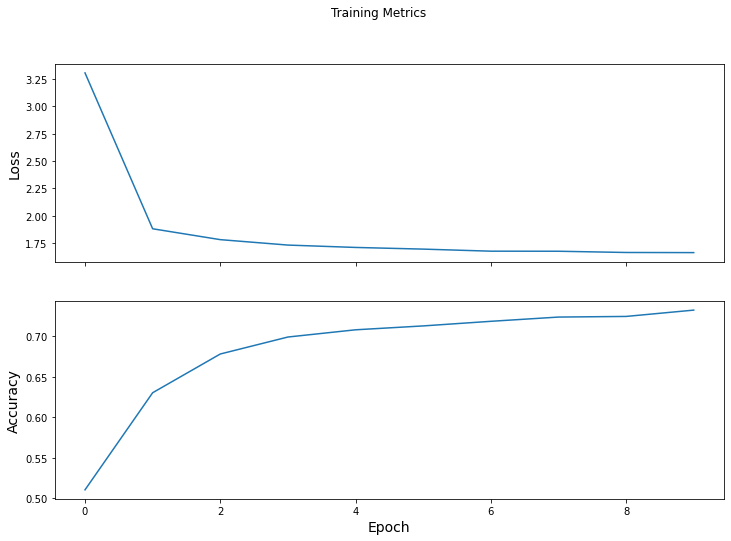

In [39]:
# Plot the training loss and accuracy
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [40]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [42]:
# Initialize a new model

# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

# Keep results for plotting
train_loss_results, train_accuracy_results = [], []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs): # Start the training
    
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    # Training loop
    
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model,x,y,weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Compute current loss
        epoch_loss_avg(loss_value)
        # Compare predicted label to actual label
        epoch_accuracy(to_categorical(y), model(x))
        
    # End of epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    print(f"Epoch: {epoch}, Loss: {epoch_loss_avg.result()}, Accuracy: {epoch_accuracy.result()}")
    
    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch: 0, Loss: 1.6514270305633545, Accuracy: 0.7374749779701233
Epoch: 1, Loss: 1.6379778385162354, Accuracy: 0.7402582764625549
Epoch: 2, Loss: 1.6504753828048706, Accuracy: 0.7438209652900696
Epoch: 3, Loss: 1.634434700012207, Accuracy: 0.746604323387146
Epoch: 4, Loss: 1.637373447418213, Accuracy: 0.7529503703117371
Epoch: 5, Loss: 1.6269783973693848, Accuracy: 0.7540636658668518
Epoch: 6, Loss: 1.6288955211639404, Accuracy: 0.7531729936599731
Epoch: 7, Loss: 1.6199449300765991, Accuracy: 0.7543976902961731
Epoch: 8, Loss: 1.6285101175308228, Accuracy: 0.7555110454559326
Epoch: 9, Loss: 1.6135129928588867, Accuracy: 0.7572923898696899
Duration :78.852


#### Redefine the grad function using the @tf.function decorator

In [44]:
# Use the @tf.function decorator

# Define a function to compute the forward and backward pass
@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Train the model

In [45]:
# Re-run the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

# Keep results for plotting
train_loss_results, train_accuracy_results = [], []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs): # Start the training
    
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    # Training loop
    
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model,x,y,weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Compute current loss
        epoch_loss_avg(loss_value)
        # Compare predicted label to actual label
        epoch_accuracy(to_categorical(y), model(x))
        
    # End of epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    print(f"Epoch: {epoch}, Loss: {epoch_loss_avg.result()}, Accuracy: {epoch_accuracy.result()}")
    
    
print("Duration :{:.3f}".format(time.time() - start_time))

Epoch: 0, Loss: 1.6162071228027344, Accuracy: 0.7599643468856812
Epoch: 1, Loss: 1.6237835884094238, Accuracy: 0.7610777020454407
Epoch: 2, Loss: 1.6170074939727783, Accuracy: 0.7584056854248047
Epoch: 3, Loss: 1.6075067520141602, Accuracy: 0.7637497186660767
Epoch: 4, Loss: 1.6278434991836548, Accuracy: 0.7608550190925598
Epoch: 5, Loss: 1.6061352491378784, Accuracy: 0.7607437372207642
Epoch: 6, Loss: 1.601076364517212, Accuracy: 0.7623023986816406
Epoch: 7, Loss: 1.6154212951660156, Accuracy: 0.7610777020454407
Epoch: 8, Loss: 1.601122498512268, Accuracy: 0.7616344094276428
Epoch: 9, Loss: 1.6027650833129883, Accuracy: 0.7621910572052002
Duration :48.709


#### Print the autograph code

In [46]:
# Use tf.autograph.to_code to see the generated code

tf.autograph.to_code

<function tensorflow.python.autograph.impl.api.to_code(entity, recursive=True, experimental_optional_features=None)>